# Author: [Your Name]

# Tricell Tracker Notebook (v3 copy)

Interactive three-step pipeline to detect and track tricellular junctions.

## Workflow

**Step 1 — Detect Frame 0**
- Runs detection pipeline on frame 0: Gaussian blur → ridge enhancement → threshold → binarize → skeletonize → find degree≥3 junctions
- Outputs: `overlay_0000.png`, in-memory `pts0_px`

**Step 2 — Manual Adjust**
- Review/edit frame-0 detections interactively
- Click to select/deselect/add points; Save writes `pts0_manual_adjusted.csv` and `overlay_0000_manual.png`

**Step 3 — Track Frames 1..N**
- Tracks junctions across frames using local search around previous positions
- Outputs: per-frame overlays and `detections_vertices_with_IDs.csv` (FRAME, ID, x_um, y_um, step_um, cum_um)

## Key Cells
- **Parameters**: Set `STACK_PATH`, `PIXEL_UM`, sigma, threshold mode, cleaning parameters, `OUT_DIR`
- **Helpers**: Core functions (blur, threshold, skeletonize, trace arms, annotate, etc.) — run first after kernel restart
- **Pipeline Viewer**: Visualize processing steps

## Outputs (in `OUT_DIR`)
`overlay_*.png`, `pts0_manual_adjusted.csv`, `detections_vertices_with_IDs.csv`, `tracks_*.csv`

## 1) Set paths and parameters

In [9]:
from pathlib import Path
from PIL import Image, ImageSequence
import tkinter as tk
from tkinter import filedialog

# ---- INPUT ---- Choose TIFF file interactively
print("Please select your TIFF file...")
root = tk.Tk()
root.withdraw()  # Hide the main window
root.attributes('-topmost', True)  # Bring dialog to front

# 智能初始目录: 优先使用上次打开文件的文件夹
default_initial_dir = "/Users/apple/Desktop/Ian_lab/"  # 默认备用目录
if 'STACK_PATH' in globals():
    try:
        prev_stack_path = globals()['STACK_PATH']
        if prev_stack_path:  # 确保不是空字符串
            prev_path = Path(prev_stack_path).expanduser()
            if prev_path.exists() and prev_path.is_file():
                default_initial_dir = str(prev_path.parent)
                print(f"使用上次文件所在目录: {default_initial_dir}")
            elif prev_path.parent.exists():
                default_initial_dir = str(prev_path.parent)
                print(f"使用上次目录(文件已移除): {default_initial_dir}")
    except Exception:
        pass

STACK_PATH = filedialog.askopenfilename(
    title="Select TIFF stack file",
    filetypes=[
        ("TIFF files", "*.tif *.tiff"),
        ("All files", "*.*")
    ],
    initialdir=default_initial_dir
)

root.destroy()

if not STACK_PATH:
    raise ValueError("No file selected! Please run this cell again and select a TIFF file.")

print(f"Selected file: {STACK_PATH}")

# ---- CALIBRATION ----
PIXEL_UM = 0.25     # µm per pixel(change every time)
FRAME_INTERVAL_SEC = 1204.738   # time interval per frame in SECONDS (change every time based on your acquisition settings)

# Convert seconds to minutes for display purposes
FRAME_INTERVAL_MIN = FRAME_INTERVAL_SEC / 60  # convert to minutes

# Count TIFF slices and set per-frame duration
slice_count = None
try:
    with Image.open(STACK_PATH) as _im:
        slice_count = getattr(_im, "n_frames", None)
        if not slice_count or slice_count <= 0:
            slice_count = sum(1 for _ in ImageSequence.Iterator(_im))
except FileNotFoundError:
    print("Warning: STACK_PATH not found yet; DT_SEC will use FRAME_INTERVAL_SEC until the file exists.")
except Exception as exc:
    print(f"Warning: could not determine slice count ({exc}); using FRAME_INTERVAL_SEC as fallback.")

if slice_count and slice_count > 0:
    TOTAL_FRAME_COUNT = int(slice_count)
    DT_SEC = float(FRAME_INTERVAL_SEC)
    DT_PER_FRAME_SEC = DT_SEC
else:
    TOTAL_FRAME_COUNT = None
    DT_SEC = float(FRAME_INTERVAL_SEC)
    DT_PER_FRAME_SEC = DT_SEC

# ---- PREPROCESS ----
SIGMA_UM   = 1.0    # Gaussian sigma in µm
USE_RIDGE  = True   # Sato ridge enhancement

# ---- DETECTOR ----
MULTIPASS      = True      # use p90 + mean union (recommended)
THRESHOLD_MODE = "mean"    # only used if MULTIPASS=False
MIN_INTENSITY  = 0.03      # minimum allowed intensity floor (0..1) applied after thresholding
MIN_OBJ_PIX    = 25        # remove tiny specks before skeletonizing
MIN_ARM_UM     = 1.2       # min branch length to count (µm)
MIN_ANGLE_DEG  = 20        # min angular separation between arms (deg)
CIRCLE_UM      = 1.2       # overlay circle radius & verification annulus outer radius (µm)

# ---- TRACKING (robust) ----
MAX_LINK_UM      = 3.0     # gating radius for assignment (µm)
MAX_MISS_FRAMES  = 5       # allow up to N missed detections while keeping the track alive
Q_POS            = 0.2     # process noise (position), tune up for more erratic motion
R_MEAS           = 0.5     # measurement noise (µm)

# ---- OUTPUT ----
stack_path = Path(STACK_PATH).expanduser()
if not stack_path.name:
    raise AssertionError("STACK_PATH must point to a TIFF file (set the path above).")
try:
    stack_path = stack_path.resolve(strict=False)
except TypeError:
    try:
        stack_path = stack_path.resolve()
    except FileNotFoundError:
        stack_path = stack_path.absolute()
out_dir_path = stack_path.parent / f"{stack_path.stem}_output"
out_dir_path.mkdir(parents=True, exist_ok=True)
OUT_DIR = str(out_dir_path)
STACK_PATH = str(stack_path)
print("Output folder:", out_dir_path.resolve())
if slice_count and slice_count > 0:
    print(f"Detected {TOTAL_FRAME_COUNT} TIFF slices → Frame interval: {FRAME_INTERVAL_MIN:.2f} min/frame ({DT_SEC:.0f} sec/frame)")

Please select your TIFF file...
使用上次文件所在目录: /Users/apple/Desktop/Ian_lab/data/260213-EpH4 Zo1mSG NT_Pals1KO + Cellbrite postcon3dys dy3


2026-02-18 16:22:55.034 python[57660:22544205] error messaging the mach port for IMKCFRunLoopWakeUpReliable


Selected file: /Users/apple/Desktop/Ian_lab/data/260213-EpH4 Zo1mSG NT_Pals1KO + Cellbrite postcon3dys dy3/260213-EpH4 Zo1mSG NT_Pals1KO + Cellbrite post3dys dy3 004_crop_Cellbrite_KOn3.tif
Output folder: /Users/apple/Desktop/Ian_lab/data/260213-EpH4 Zo1mSG NT_Pals1KO + Cellbrite postcon3dys dy3/260213-EpH4 Zo1mSG NT_Pals1KO + Cellbrite post3dys dy3 004_crop_Cellbrite_KOn3_output
Detected 80 TIFF slices → Frame interval: 20.08 min/frame (1205 sec/frame)


## 2) Imports and helper functions

In [10]:
import numpy as np
import math
import gc
import os
import json
import functools
import cv2
import concurrent.futures as fut
from math import atan2, degrees, hypot
from pathlib import Path
from PIL import Image, ImageDraw, ImageSequence
from scipy.ndimage import distance_transform_edt
from scipy.optimize import linear_sum_assignment
from skimage import filters, measure, morphology, exposure
from skimage.measure import label, regionprops
from skimage.morphology import skeletonize, remove_small_objects, dilation
from skimage.morphology import medial_axis
from skimage.morphology import thin
from skimage.morphology import opening, closing
from skimage.morphology import remove_small_holes
from skimage.morphology import erosion
from skimage.morphology import disk
from skimage.morphology import cube
from skimage.morphology import ball
from skimage import morphology as morph
from skimage.filters.rank import entropy
from skimage.util import img_as_ubyte
from skimage.feature import canny
from skimage.filters import sobel
from skimage.filters import threshold_otsu
from skimage.filters import threshold_mean
from skimage.filters import rank
from skimage.morphology import area_opening

## 3) Detection (multi-pass) with refined centers

In [11]:
# --- I/O helpers ---

def to_gray01(arr):
    arr = np.asarray(arr, dtype=np.float32)
    if arr.ndim == 3:
        if arr.shape[2] == 1:
            arr = arr[..., 0]
        else:
            # perceptual luminance for RGB
            arr = 0.2126 * arr[..., 0] + 0.7152 * arr[..., 1] + 0.0722 * arr[..., 2]
    arr_min = float(arr.min())
    arr_max = float(arr.max())
    if not np.isfinite(arr_min) or not np.isfinite(arr_max):
        return np.zeros_like(arr, dtype=np.float32)
    denom = arr_max - arr_min
    if denom <= 1e-12:
        return np.zeros_like(arr, dtype=np.float32)
    norm = (arr - arr_min) / denom
    return np.clip(norm, 0.0, 1.0).astype(np.float32)

def read_frames(stack_path):
    """Load frames from a multi-page TIFF specified by STACK_PATH and return float images in [0,1]."""
    path = Path(stack_path).expanduser()
    if not path.is_file():
        raise FileNotFoundError(f"STACK_PATH not found: {path}")
    frames = []
    with Image.open(path) as im:
        for fr in ImageSequence.Iterator(im):
            frames.append(to_gray01(np.array(fr)))
    return frames

# --- Preprocessing helpers ---

def gaussian_blur(img, sigma_px):
    """Apply a Gaussian blur using OpenCV (works on float images)."""
    return cv2.GaussianBlur(img.astype(np.float32), (0, 0), sigmaX=float(sigma_px), sigmaY=float(sigma_px))

def ridge_enhance(img, enable=True):
    """Enhance junction-like ridges using Sato filter and normalize to 0..1."""
    if not enable:
        return img
    try:
        rid = filters.sato(img, sigmas=tuple(np.linspace(1, 3, 5)), black_ridges=False)
        rid = (rid - rid.min()) / max(1e-12, (rid.max() - rid.min()))
        return rid.astype(np.float32)
    except Exception:
        return img

def threshold_mean_or_otsu(img, mode="mean"):
    """Threshold helper supporting mean, otsu, or percentile (e.g., 'p90')."""
    if mode == "mean":
        thr = float(img.mean())
    elif mode == "otsu":
        try:
            thr = float(threshold_otsu(img))
        except Exception:
            thr = float(img.mean())
    elif mode.startswith("p"):
        try:
            thr = float(np.percentile(img, float(mode[1:])))
        except Exception:
            thr = float(img.mean())
    else:
        thr = float(img.mean())
    out = img.copy()
    out[out < thr] = 0.0
    return out

def binarize_and_bridge(img):
    """Convert to binary mask and bridge small gaps using morphology."""
    bw = (img > 0).astype(np.uint8)
    kernel_close = np.ones((3, 3), np.uint8)
    kernel_open = np.ones((2, 2), np.uint8)
    bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel_close, iterations=2)
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, kernel_open, iterations=1)
    return bw

def skeletonize_mask(bw, min_size=25):
    """Remove tiny components and skeletonize the mask."""
    clean = remove_small_objects(bw.astype(bool), min_size=min_size)
    return skeletonize(clean).astype(np.uint8)

# --- Skeleton utilities ---

def neighbors8(skel, y, x):
    h, w = skel.shape
    for dy in (-1, 0, 1):
        for dx in (-1, 0, 1):
            if dy == 0 and dx == 0:
                continue
            yy, xx = y + dy, x + dx
            if 0 <= yy < h and 0 <= xx < w and skel[yy, xx]:
                yield yy, xx

def degree_map(skel):
    deg = np.zeros_like(skel, dtype=np.uint8)
    ys, xs = np.where(skel)
    for y, x in zip(ys, xs):
        deg[y, x] = sum(1 for _ in neighbors8(skel, y, x))
    return deg

def trace_arm_coords(skel, deg, y0, x0, y1, x1, max_len=40):
    """Follow an arm of the skeleton starting from the seed segment."""
    py, px = y0, x0
    cy, cx = y1, x1
    steps = 0
    coords = [(y0, x0), (y1, x1)]
    while steps < max_len:
        nxts = [
            (ny, nx)
            for ny, nx in neighbors8(skel, cy, cx)
            if (ny, nx) != (py, px)
        ]
        if not nxts:
            break
        v1 = (cy - py, cx - px)
        best = nxts[0]
        best_turn = 1e9
        for ny, nx in nxts:
            v2 = (ny - cy, nx - cx)
            turn = (v1[0] - v2[0]) ** 2 + (v1[1] - v2[1]) ** 2
            if turn < best_turn:
                best_turn, best = turn, (ny, nx)
        py, px, cy, cx = cy, cx, best[0], best[1]
        steps += 1
        coords.append((cy, cx))
        if deg[cy, cx] >= 3:
            break
    return coords

def fit_line_pca(coords):
    if len(coords) < 2:
        return None
    xy = np.array([[c[1], c[0]] for c in coords], dtype=float)
    p = xy.mean(axis=0)
    C = np.cov(xy.T)
    eigvals, eigvecs = np.linalg.eigh(C)
    v = eigvecs[:, np.argmax(eigvals)]
    v = v / (np.linalg.norm(v) + 1e-12)
    return p, v

def lsq_intersection_of_lines(lines):
    A = np.zeros((2, 2))
    b = np.zeros(2)
    for p, v in lines:
        v = v / (np.linalg.norm(v) + 1e-12)
        M = np.eye(2) - np.outer(v, v)
        A += M
        b += M @ p
    try:
        x = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        x = np.linalg.lstsq(A, b, rcond=None)[0]
    return x  # [x, y]

def refine_center_by_arm_intersection(skel, y0, x0, deg, search_len=15, img_raw=None, bg_percentile=10):
    neighs = [
        (ny, nx)
        for ny, nx in neighbors8(skel, int(round(y0)), int(round(x0)))
    ]
    if len(neighs) < 3:
        return float(x0), float(y0)
    arms = []
    for ny, nx in neighs:
        coords = trace_arm_coords(
            skel,
            deg,
            int(round(y0)),
            int(round(x0)),
            ny,
            nx,
            max_len=search_len,
        )
        if len(coords) >= 3:
            arms.append(coords[:search_len])
    if len(arms) < 3:
        return float(x0), float(y0)
    lines = []
    for coords in arms[:3]:
        fv = fit_line_pca(coords)
        if fv is not None:
            lines.append(fv)
    if len(lines) < 2:
        return float(x0), float(y0)
    x, y = lsq_intersection_of_lines(lines)
    if img_raw is not None:
        try:
            x_refined, y_refined = _intensity_centroid_5x5(img_raw, x, y, bg_percentile=bg_percentile)
            return float(x_refined), float(y_refined)
        except Exception:
            pass
    return float(x), float(y)

def _intensity_centroid_5x5(img, x0, y0, bg_percentile=10):
    h, w = img.shape
    x0i = int(round(x0))
    y0i = int(round(y0))
    x_min = max(0, x0i - 2)
    x_max = min(w, x0i + 3)
    y_min = max(0, y0i - 2)
    y_max = min(h, y0i + 3)
    crop = img[y_min:y_max, x_min:x_max].astype(float)
    if crop.size == 0:
        return x0, y0
    bg = np.percentile(crop, bg_percentile)
    crop_sub = np.maximum(crop - bg, 0.0)
    total = crop_sub.sum()
    if total < 1e-9:
        return x0, y0
    yy, xx = np.ogrid[0:crop_sub.shape[0], 0:crop_sub.shape[1]]
    cx_local = (crop_sub * xx).sum() / total
    cy_local = (crop_sub * yy).sum() / total
    x_refined = x_min + cx_local
    y_refined = y_min + cy_local
    return float(x_refined), float(y_refined)

def verify_tribranch_in_circle(skel, x, y, r_inner=3, r_outer=8, min_sep_deg=18):
    h, w = skel.shape
    Y, X = np.ogrid[:h, :w]
    dist2 = (X - x) ** 2 + (Y - y) ** 2
    ring = (dist2 <= r_outer * r_outer) & (dist2 > r_inner * r_inner)
    inner_touch = dist2 <= (r_inner + 1) * (r_inner + 1)
    ring_skel = skel.astype(bool) & ring
    if not ring_skel.any():
        return False
    lbl = label(ring_skel, connectivity=2)
    angles = []
    for r in regionprops(lbl):
        rr, cc = r.coords[:, 0], r.coords[:, 1]
        if not np.any(inner_touch[rr, cc]):
            continue
        idx = np.argmin((cc - x) ** 2 + (rr - y) ** 2)
        yy, xx = rr[idx], cc[idx]
        ang = math.degrees(math.atan2(-(yy - y), (xx - x)))
        angles.append(ang)
    if len(angles) < 3:
        return False
    chosen = []
    for a in sorted(angles):
        if all(abs((a - b + 180) % 360 - 180) >= min_sep_deg for b in chosen):
            chosen.append(a)
        if len(chosen) >= 3:
            return True
    return False

def detect_tricells_from_mask(skel, min_arm_len_px=8, min_angle_sep=20):
    """Return raw candidate centers (x, y) along with the degree map."""
    deg = degree_map(skel)
    branch = (deg >= 3).astype(np.uint8)
    lbl = label(dilation(branch, morph.rectangle(5, 5)) > 0, connectivity=2)

    raw = []
    for r in regionprops(lbl):
        y0, x0 = r.centroid
        y0i, x0i = int(round(y0)), int(round(x0))
        neighs = [(ny, nx) for ny, nx in neighbors8(skel, y0i, x0i)]
        if not neighs:
            continue
        arms_ok = 0
        for ny, nx in neighs:
            coords = trace_arm_coords(
                skel,
                deg,
                y0i,
                x0i,
                ny,
                nx,
                max_len=int(round(min_arm_len_px + 5)),
            )
            if len(coords) >= int(round(min_arm_len_px)):
                arms_ok += 1
        if arms_ok >= 3:
            raw.append((x0, y0))
    return raw, deg

def dedupe_points(pts, r=6):
    out = []
    for x, y in pts:
        if all((x - x2) ** 2 + (y - y2) ** 2 > r * r for x2, y2 in out):
            out.append((x, y))
    return out

def annotate_points(img_gray, points_px, circle_r_px=8, ids=None):
    """Draw circles (and optional IDs) onto a grayscale image."""
    im = Image.fromarray((img_gray * 255).astype(np.uint8)).convert("RGB")
    overlay = Image.new("RGBA", im.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)
    r = int(circle_r_px)
    w, h = im.size
    for idx, (x, y) in enumerate(points_px):
        xi, yi = int(round(x)), int(round(y))
        draw.ellipse((xi - r, yi - r, xi + r, yi + r), outline=(255, 0, 0, 255), width=2)
        if ids is not None and idx < len(ids):
            lab = str(ids[idx])
            try:
                tw, th = draw.textsize(lab)
            except Exception:
                tw, th = (8 * len(lab), 12)
            margin = 4
            tx = xi + r + margin
            if tx + tw + margin > w:
                tx = xi - r - tw - margin
            ty = yi - th // 2
            ty = max(2, min(h - th - 2, ty))
            rect = (tx - 2, ty - 2, tx + tw + 2, ty + th + 2)
            draw.rectangle(rect, fill=(0, 0, 0, 200))
            draw.text((tx, ty), lab, fill=(255, 255, 0, 255))
    return Image.alpha_composite(im.convert("RGBA"), overlay)

def detect_refined_vertices(
    img,
    sigma_px,
    min_obj_size,
    min_arm_len_px,
    min_angle_sep,
    circle_r_px,
    use_ridge=True,
    mode="mean",
    img_raw=None,
    bg_percentile=10,
):
    img_blur = gaussian_blur(img, sigma_px)
    img_enh = ridge_enhance(img_blur, enable=use_ridge)
    img_thr = threshold_mean_or_otsu(img_enh, mode=mode)
    bw = binarize_and_bridge(img_thr)
    skel = skeletonize_mask(bw, min_size=min_obj_size)

    raw, deg = detect_tricells_from_mask(
        skel,
        min_arm_len_px=min_arm_len_px,
        min_angle_sep=min_angle_sep,
    )
    pts = []
    for (x0, y0) in raw:
        xr, yr = refine_center_by_arm_intersection(
            skel,
            y0,
            x0,
            deg,
            search_len=int(round(min_arm_len_px)) + 10,
            img_raw=img_raw,
            bg_percentile=bg_percentile,
        )
        if verify_tribranch_in_circle(
            skel,
            xr,
            yr,
            r_inner=int(max(2, circle_r_px * 0.35)),
            r_outer=int(max(6, circle_r_px)),
            min_sep_deg=max(15, min_angle_sep - 2),
        ):
            pts.append((xr, yr))

    def _double_check(skel, deg, existing_pts, min_arm_len_px, min_angle_sep, circle_r_px, img_raw=None, bg_percentile=10):
        cand = []
        ys, xs = np.where(deg >= 3)
        for y, x in zip(ys, xs):
            xr, yr = refine_center_by_arm_intersection(
                skel,
                y,
                x,
                deg,
                search_len=int(round(min_arm_len_px)) + 10,
                img_raw=img_raw,
                bg_percentile=bg_percentile,
            )
            if verify_tribranch_in_circle(
                skel,
                xr,
                yr,
                r_inner=int(max(2, circle_r_px * 0.35)),
                r_outer=int(max(6, circle_r_px)),
                min_sep_deg=max(15, min_angle_sep - 2),
            ):
                cand.append((xr, yr))
        new_pts = []
        for (x, y) in cand:
            too_close = False
            for (ex, ey) in existing_pts:
                if (x - ex) ** 2 + (y - ey) ** 2 <= 6 * 6:
                    too_close = True
                    break
            if not too_close:
                new_pts.append((x, y))
        merged = existing_pts + new_pts
        return dedupe_points(merged, r=6)

    pts2 = _double_check(skel, deg, pts, min_arm_len_px, min_angle_sep, circle_r_px, img_raw=img_raw, bg_percentile=bg_percentile)
    return pts2

def multipass_detect(img, sigma_px, min_obj_size, min_arm_len_px, min_angle_sep, circle_r_px):
    pts_all = []
    for mode in ["p90", "mean"]:
        pts = detect_refined_vertices(
            img,
            sigma_px,
            min_obj_size,
            min_arm_len_px,
            min_angle_sep,
            circle_r_px,
            use_ridge=True,
            mode=mode,
            img_raw=img,
        )
        pts_all += pts
    return dedupe_points(pts_all, r=6)


## 4) Robust tracker (Kalman + Hungarian + memory)

In [12]:
# Define the `tracks` DataFrame template used by downstream analysis/plotting.
# Each row represents one tracked vertex at a particular frame with motion stats.
import math
import pandas as pd
import numpy as _np
cols = [
    "FRAME", "TRACK_ID", "x_um", "y_um",
    "dx_um", "dy_um", "step_um", "cum_um",
    "t_sec", "net_um", "inst_speed_um_per_sec"
 ]
# empty template (will be populated by the tracker). Keep columns ordered for consistency.
tracks = pd.DataFrame(columns=cols)

# empty summary template (will be computed from tracks when available)
summary = pd.DataFrame(columns=['TRACK_ID','n_points','total_time_sec','total_path_um','net_disp_um','avg_speed_um_per_sec'])

# Helper: derive seconds-per-frame using the frame interval setting.
def _compute_seconds_per_frame(frame_interval_sec=None, frame_labels=None, fallback=1.0):
    """Return seconds per frame derived from FRAME_INTERVAL_SEC setting."""
    if frame_interval_sec is None:
        if 'FRAME_INTERVAL_SEC' in globals():
            frame_interval_sec = globals()['FRAME_INTERVAL_SEC']
        else:
            frame_interval_sec = globals().get('DT_SEC', fallback)
    try:
        frame_interval_sec = float(frame_interval_sec)
    except Exception:
        frame_interval_sec = float(fallback)
    frame_count = None
    if 'frames' in globals():
        try:
            frame_count = len(globals()['frames'])
        except Exception:
            frame_count = None
    if frame_count is None or frame_count <= 0:
        stack_path = globals().get('STACK_PATH')
        if stack_path:
            try:
                from PIL import Image, ImageSequence
                n_frames = None
                with Image.open(stack_path) as im:
                    n_frames = getattr(im, "n_frames", None)
                    if not n_frames or n_frames <= 0:
                        n_frames = sum(1 for _ in ImageSequence.Iterator(im))
                if n_frames and n_frames > 0:
                    frame_count = int(n_frames)
            except Exception:
                pass
    if (frame_count is None or frame_count <= 0) and frame_labels is not None:
        try:
            series = pd.Series(frame_labels).dropna()
            if not series.empty:
                frame_count = int(series.max()) + 1
                frame_count = max(frame_count, int(series.nunique()))
        except Exception:
            try:
                arr = _np.asarray(frame_labels, dtype=float)
                if arr.size:
                    frame_count = int(_np.nanmax(arr)) + 1
            except Exception:
                frame_count = None
    if frame_count is None or frame_count <= 0:
        frame_count = 1
    if frame_interval_sec <= 0:
        dt = float(fallback)
    else:
        dt = frame_interval_sec
    if not _np.isfinite(dt) or dt <= 0:
        dt = float(fallback)
    globals()['DT_PER_FRAME_SEC'] = float(dt)
    globals()['FRAME_INTERVAL_SEC'] = float(frame_interval_sec)
    globals()['DT_SEC'] = float(dt)
    globals()['TOTAL_FRAME_COUNT'] = int(frame_count)
    return float(dt)

# Helper: finalize/compute motion statistics for a tracks DataFrame produced by a tracker.
def finalize_tracks(tracks_df):
    """Compute dx/dy, step, cumulative path, net displacement and instantaneous speed.
    Input: tracks_df with at least ['FRAME','TRACK_ID','x_um','y_um']
    Returns: a new DataFrame with computed columns appended.
    """
    if tracks_df is None or len(tracks_df) == 0:
        return tracks_df.copy() if tracks_df is not None else pd.DataFrame(columns=cols)
    T = tracks_df.sort_values(['TRACK_ID','FRAME']).copy()
    # numeric conversions (safe if already numeric)
    T['x_um'] = T['x_um'].astype(float)
    T['y_um'] = T['y_um'].astype(float)
    # displacements per-frame per-track
    T['dx_um'] = T.groupby('TRACK_ID')['x_um'].diff().fillna(0.0)
    T['dy_um'] = T.groupby('TRACK_ID')['y_um'].diff().fillna(0.0)
    T['step_um'] = _np.hypot(T['dx_um'], T['dy_um'])
    # cumulative path length per track
    T['cum_um'] = T.groupby('TRACK_ID')['step_um'].cumsum().fillna(0.0)
    # time in seconds for each frame based on frame interval
    frame_labels = T['FRAME'] if 'FRAME' in T.columns else None
    dt = _compute_seconds_per_frame(frame_labels=frame_labels)
    if 'FRAME' in T.columns:
        T['t_sec'] = T['FRAME'].astype(float) * dt
    else:
        T['t_sec'] = _np.arange(len(T), dtype=float) * dt
    # net displacement from first observed point of each track
    x0 = T.groupby('TRACK_ID')['x_um'].transform('first')
    y0 = T.groupby('TRACK_ID')['y_um'].transform('first')
    T['net_um'] = _np.hypot(T['x_um'] - x0, T['y_um'] - y0)
    # instantaneous speed (avoid divide-by-zero)
    dt_per_frame = T.groupby('TRACK_ID')['t_sec'].diff()
    with _np.errstate(divide='ignore', invalid='ignore'):
        T['inst_speed_um_per_sec'] = T['step_um'] / dt_per_frame.replace(0, _np.nan)
    # fill NaNs for first frames with 0.0 where appropriate
    T['inst_speed_um_per_sec'] = T['inst_speed_um_per_sec'].fillna(0.0)
    T['cum_um'] = T['cum_um'].fillna(0.0)
    return T

# Helper: compute a condensed per-TRACK_ID summary of motion statistics (sorted by total path length).
def compute_summary(tracks_df):
    """Return a DataFrame with one row per TRACK_ID containing:
    ['TRACK_ID','n_points','total_time_sec','total_path_um','net_disp_um','avg_speed_um_per_sec'] sorted by total_path_um desc.
    If tracks_df is empty, returns an empty DataFrame with the above columns.
    """
    cols_s = ['TRACK_ID','n_points','total_time_sec','total_path_um','net_disp_um','avg_speed_um_per_sec']
    if tracks_df is None or len(tracks_df) == 0:
        return pd.DataFrame(columns=cols_s)
    T = finalize_tracks(tracks_df)
    stats = []
    for tid, g in T.groupby('TRACK_ID'):
        g = g.sort_values('FRAME')
        n_points = len(g)
        total_time = float((g['t_sec'].iloc[-1] - g['t_sec'].iloc[0])) if n_points > 1 else 0.0
        total_path = float(g['cum_um'].iloc[-1]) if n_points > 0 else 0.0
        net_disp = float(g['net_um'].iloc[-1]) if n_points > 0 else 0.0
        avg_speed = (total_path / total_time) if total_time > 0 else float('nan')
        stats.append({
            'TRACK_ID': int(tid),
            'n_points': int(n_points),
            'total_time_sec': float(total_time),
            'total_path_um': float(total_path),
            'net_disp_um': float(net_disp),
            'avg_speed_um_per_sec': float(avg_speed)
        })
    df = pd.DataFrame(stats).sort_values('total_path_um', ascending=False).reset_index(drop=True)
    return df

# Helper: compute per-track MSD and RMSD from origin (frame-0 position).
def compute_rmsd_per_track(tracks_df, xcol="x_um", ycol="y_um"):
    """Return per-TRACK_ID RMSD (µm) and MSD (µm²) relative to the first recorded position."""
    required_cols = {'TRACK_ID', xcol, ycol}
    if tracks_df is None or len(tracks_df) == 0:
        return pd.DataFrame(columns=['TRACK_ID','RMSD_um','MSD_um2','n_points_rmsd'])
    if not required_cols.issubset(set(tracks_df.columns)):
        return pd.DataFrame(columns=['TRACK_ID','RMSD_um','MSD_um2','n_points_rmsd'])
    df = tracks_df.copy()
    if 'FRAME' not in df.columns:
        df = df.reset_index(drop=True)
        df['FRAME'] = df.index
    df[xcol] = df[xcol].astype(float)
    df[ycol] = df[ycol].astype(float)
    results = []
    for tid, g in df.groupby('TRACK_ID'):
        g_sorted = g.sort_values('FRAME')
        if g_sorted.empty:
            continue
        x0 = float(g_sorted.iloc[0][xcol])
        y0 = float(g_sorted.iloc[0][ycol])
        dx = g_sorted[xcol] - x0
        dy = g_sorted[ycol] - y0
        sq = dx.pow(2) + dy.pow(2)
        msd = float(sq.mean()) if len(sq) else float('nan')
        rmsd = math.sqrt(msd) if msd >= 0 and not math.isnan(msd) else float('nan')
        results.append({'TRACK_ID': int(tid), 'RMSD_um': rmsd, 'MSD_um2': msd, 'n_points_rmsd': int(len(g_sorted))})
    return pd.DataFrame(results)

# Helper: merge per-track RMSD/MSD with an existing summary DataFrame.
def merge_summary_with_rmsd(summary_df, rmsd_df):
    """Append RMSD/MSD columns to the supplied summary DataFrame (left join on TRACK_ID)."""
    if summary_df is None or len(summary_df) == 0:
        return rmsd_df.copy() if rmsd_df is not None else pd.DataFrame()
    if rmsd_df is None or len(rmsd_df) == 0:
        return summary_df.copy()
    merged = summary_df.merge(rmsd_df, on='TRACK_ID', how='left')
    return merged

# Provide an empty `summary` variable (compute after tracker runs):
# summary = compute_summary(tracks)  # call after populating `tracks`

# ========== Kalman Filter Track Class ==========
class Track:
    def __init__(self, tid, x_um, y_um, q_pos_um, r_meas_um):
        self.tid = tid
        self.x = np.array([[x_um],[y_um],[0.0],[0.0]], dtype=float)  # [x,y,vx,vy]
        self.P = np.eye(4)
        self.Q = np.array([[q_pos_um,0,0,0],[0,q_pos_um,0,0],[0,0,q_pos_um,0],[0,0,0,q_pos_um]], dtype=float)
        self.R = np.array([[r_meas_um,0],[0,r_meas_um]], dtype=float)
        self.F = np.array([[1,0,1,0],[0,1,0,1],[0,0,1,0],[0,0,0,1]], dtype=float)
        self.H = np.array([[1,0,0,0],[0,1,0,0]], dtype=float)
        self.age = 0
        self.miss = 0
        self.history = []

    def predict(self):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.x[:2].ravel()

    def update(self, z_um):
        z = np.asarray(z_um, dtype=float).reshape(2,1)
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        I = np.eye(4)
        self.P = (I - K @ self.H) @ self.P
        self.miss = 0

    def mark_missed(self):
        self.miss += 1

def robust_track(frames_pts_um, max_link_um=3.0, max_miss=5, q_pos_um=0.2, r_meas_um=0.5, dt_min=0.5):
    tracks = []
    next_id = 0

    for f, pts in enumerate(frames_pts_um):
        pts = np.array(pts, dtype=float)
        preds = []
        for t in tracks:
            px, py = t.predict()
            preds.append([px, py])
        preds = np.array(preds, dtype=float) if tracks else np.zeros((0,2))

        if len(tracks) and len(pts):
            D = np.linalg.norm(preds[:, None, :] - pts[None, :, :], axis=2)
        else:
            D = np.zeros((len(tracks), len(pts)))

        if D.size:
            ridx, cidx = linear_sum_assignment(D)
        else:
            ridx, cidx = [], []
        assigned_tracks = set(); assigned_dets = set()
        for r,c in zip(ridx, cidx):
            if D[r,c] <= max_link_um:
                t = tracks[r]
                t.update(pts[c])
                assigned_tracks.add(r); assigned_dets.add(c)

        for r, t in enumerate(tracks):
            if r not in assigned_tracks:
                t.mark_missed()

        for j, p in enumerate(pts):
            if j not in assigned_dets:
                t = Track(next_id, p[0], p[1], q_pos_um=q_pos_um, r_meas_um=r_meas_um)
                tracks.append(t); next_id += 1

        alive = []
        for t in tracks:
            t.age += 1
            x_um, y_um = t.x[0,0], t.x[1,0]
            t.history.append((f, x_um, y_um))
            if t.miss <= max_miss:
                alive.append(t)
        tracks = alive

    rows = []
    for t in tracks:
        for (f, x_um, y_um) in t.history:
            rows.append((f, t.tid, x_um, y_um))
    return pd.DataFrame(rows, columns=["FRAME","TRACK_ID","x_um","y_um"])


## 5) Run detection + robust tracking

## Step 1 — Detect frame 0

Run order: Step 1 → Step 2 → Step 3

Detect tricellular junctions on frame 0 and save an overlay. Run this first.
- Outputs written to `OUT_DIR`: `overlay_0000.png`, plus in-memory `pts0_px` used by later steps.
- Downstream files produced after full pipeline: `detections_vertices_with_IDs.csv`, `tracks_per_frame.csv`, `tracks_summary.csv`, `tracks_summary_with_RMSD.csv`.

In [14]:
from pathlib import Path
import pandas as pd

sigma_px = SIGMA_UM / PIXEL_UM
min_arm_px = MIN_ARM_UM / PIXEL_UM
circle_px = CIRCLE_UM / PIXEL_UM

RADIUS_EXPAND_UM = float(globals().get("RADIUS_EXPAND_UM", 1.0))
RADIUS_EXPAND_PX = RADIUS_EXPAND_UM / PIXEL_UM
globals()["RADIUS_EXPAND_UM"] = RADIUS_EXPAND_UM
globals()["RADIUS_EXPAND_PX"] = RADIUS_EXPAND_PX

frames = read_frames(STACK_PATH)
if not frames:
    raise AssertionError("No frames were loaded from STACK_PATH; verify the TIFF stack path before continuing.")
globals()["frames"] = frames
print(f"Loaded {len(frames)} frames.")

pts0_px = multipass_detect(frames[0], sigma_px, MIN_OBJ_PIX, min_arm_px, MIN_ANGLE_DEG, circle_px)
globals()["pts0_px"] = pts0_px
ids = list(range(1, len(pts0_px) + 1))
print(f"Detected {len(pts0_px)} tricellular junctions on frame 0.")

rows = []
overlays = []
globals()["rows"] = rows
globals()["overlays"] = overlays

if pts0_px:
    Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
    for idx, tid in enumerate(ids):
        x_px, y_px = pts0_px[idx]
        rows.append({
            "FRAME": 0,
            "TRACK_ID": int(tid),
            "x_um": float(x_px) * PIXEL_UM,
            "y_um": float(y_px) * PIXEL_UM,
            "step_um": 0.0,
            "cum_um": 0.0,
        })
    try:
        overlay = annotate_points(frames[0], pts0_px, circle_r_px=int(round(circle_px)), ids=ids)
        overlay_path = Path(OUT_DIR) / "overlay_0000.png"
        overlay.save(overlay_path)
        overlays.append(str(overlay_path))
        print(f"Saved overlay to {overlay_path.resolve()}")
    except Exception as overlay_err:
        print("Failed to save overlay_0000.png:", overlay_err)

    try:
        from IPython.display import display
        detections_df = pd.DataFrame({
            "TRACK_ID": ids,
            "x_px": [p[0] for p in pts0_px],
            "y_px": [p[1] for p in pts0_px],
            "x_um": [p[0] * PIXEL_UM for p in pts0_px],
            "y_um": [p[1] * PIXEL_UM for p in pts0_px],
        })
        print("Frame 0 detections (up to 50 rows)")
        display(detections_df.head(50))
    except Exception as display_err:
        print("Preview unavailable:", display_err)
else:
    print("No tricellular junctions detected on frame 0.")

print("Run Step 2 (manual adjust) to review or edit pts0_px before continuing to tracking.")

Loaded 80 frames.
Detected 207 tricellular junctions on frame 0.
Saved overlay to /Users/apple/Desktop/Ian_lab/data/260213-EpH4 Zo1mSG NT_Pals1KO + Cellbrite postcon3dys dy3/260213-EpH4 Zo1mSG NT_Pals1KO + Cellbrite post3dys dy3 004_crop_Cellbrite_KOn3_output/overlay_0000.png
Frame 0 detections (up to 50 rows)


,TRACK_ID,x_px,y_px,x_um,y_um
0,1,484.533058,12.990894,121.133264,3.247724
1,2,9.334504,22.769031,2.333626,5.692258
2,3,415.374533,29.725200,103.843633,7.431300
3,4,414.150015,39.733722,103.537504,9.933431
4,5,211.297354,105.197411,52.824338,26.299353
5,6,176.297152,191.247350,44.074288,47.811837
6,7,305.795524,218.065124,76.448881,54.516281
7,8,10.633233,238.023854,2.658308,59.505963
8,9,450.401809,267.590653,112.600452,66.897663
9,10,358.798412,280.886521,89.699603,70.221630


Run Step 2 (manual adjust) to review or edit pts0_px before continuing to tracking.


## Step 2 — Manual adjust (frame 0)

Interactively select, remove or add points on the frame-0 image. Click "Save" to write `pts0_manual_adjusted.csv` (used by Step 3). Run this after Step 1.
- After saving, rerun Step 3 to regenerate `detections_vertices_with_IDs.csv`, `tracks_per_frame.csv`, `tracks_summary.csv`, `tracks_summary_with_RMSD.csv`.

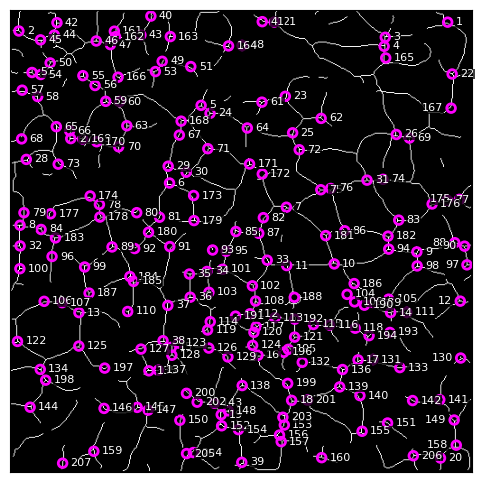

In [ ]:
import ipywidgets as W
from IPython.display import display, clear_output
from PIL import Image
from scipy.ndimage import convolve
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Manual adjuster for frame 0 detections
# - To deselect (remove) points, enter their IDs in the box below (comma or space separated) and press 'Deselect by IDs' (show a preview first to check)
# - You can also paste pixel coordinates (x,y) in the text box and press 'Add coords' (each coordinate will be refined before adding)
# - Press 'Preview current' to view a preview overlay of currently kept points
# - Press 'Preview fullcoords' to generate a full-image figure with pixel axes, grid, and annotated kept points (saved to OUT_DIR)
# - Press 'Show first image with selected IDs' to display the original first frame with the kept points and IDs (saved to OUT_DIR)
# - Press Save to write `pts0_manual_adjusted.csv` (used by Step 3). The notebook will update the in-memory `pts0_px` so Step 3 uses the adjusted points.

# Preconditions
assert 'frames' in globals() and len(frames) > 0, (
    "frames not found or empty. Run Step 1 (Detect frame 0) first so frames are loaded into the kernel.")

# recompute skeleton for frame 0 to display
sigma_px = SIGMA_UM / PIXEL_UM
img0 = frames[0]
img_blur = gaussian_blur(img0, sigma_px)
img_enh  = ridge_enhance(img_blur, enable=USE_RIDGE)
img_thr  = threshold_mean_or_otsu(img_enh, mode=THRESHOLD_MODE)
try:
    img_thr[img_thr < float(MIN_INTENSITY)] = 0.0
except Exception:
    pass
bw0 = binarize_and_bridge(img_thr)
skel0 = skeletonize_mask(bw0, min_size=MIN_OBJ_PIX if 'MIN_OBJ_PIX' in globals() else 25)

# initial points (use existing pts0_px if present, else run detection)
try:
    orig_pts = [(float(x), float(y)) for x,y in pts0_px]
except Exception:
    try:
        orig_pts = multipass_detect(img0, sigma_px, MIN_OBJ_PIX, MIN_ARM_UM/PIXEL_UM, MIN_ANGLE_DEG, CIRCLE_UM/PIXEL_UM)
    except Exception:
        orig_pts = []

pts = list(orig_pts)  # mutable list of (x,y)
keep = [True] * len(pts)  # whether point is kept/selected (True=kept)
selected_idx = None     # index of currently selected point (None if none)

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(skel0, cmap='gray')
ax.set_title('Frame 0 skeleton — click an existing circle to select it; click empty area to add a new vertex')
scat = None
labels = []
patches = []

circle_px = CIRCLE_UM / PIXEL_UM

# local refinement function: use the same local-skeleton + arm-intersection strategy as detection
def _refine_coord(xf, yf, win_px=None):
    """Refine an approximate pixel coordinate (xf,yf) to a tricellular junction center using local skeleton.
    Strategy:
    - crop a local window around the input point from the global skel0
    - find nearest degree-3 skeleton pixel (candidate vertex)
    - call the global refine_center_by_arm_intersection with tribranch verification
    - only accept if it passes verify_tribranch_in_circle
    - fallback to centroiding of local skeleton pixels if refinement fails
    Returns (x_refined, y_refined) in pixel coordinates (float).
    """
    try:
        x0 = float(xf); y0 = float(yf)
        nx = skel0.shape[1]; ny = skel0.shape[0]
        if win_px is None:
            win_px = max(20, int(round(circle_px * 6)))
        # integer bbox in global coords
        x0i = int(round(x0)); y0i = int(round(y0))
        x0a = max(0, x0i - win_px); x0b = min(nx, x0i + win_px + 1)
        y0a = max(0, y0i - win_px); y0b = min(ny, y0i + win_px + 1)
        local_skel = skel0[y0a:y0b, x0a:x0b].astype(np.uint8)
        if local_skel.size == 0 or local_skel.sum() == 0:
            print(f"  ⚠ No skeleton found near ({x0:.1f}, {y0:.1f})")
            return None, None
        
        # compute degree map on local window
        deg_global = degree_map(skel0)
        deg_local = deg_global[y0a:y0b, x0a:x0b]
        
        # find degree >= 3 pixels (potential vertices)
        ys_rel, xs_rel = np.nonzero(deg_local >= 3)
        if len(xs_rel) == 0:
            print(f"  ⚠ No tricellular junction (degree≥3) found near ({x0:.1f}, {y0:.1f})")
            # fallback to any skeleton pixel
            ys_rel, xs_rel = np.nonzero(local_skel)
            if len(xs_rel) == 0:
                return None, None
        
        # find the nearest candidate to the input point
        rel_x = x0 - x0a; rel_y = y0 - y0a
        d2 = (xs_rel - rel_x)**2 + (ys_rel - rel_y)**2
        nearest_idx = int(np.argmin(d2))
        seed_x_rel = int(xs_rel[nearest_idx]); seed_y_rel = int(ys_rel[nearest_idx])
        seed_x = seed_x_rel + x0a; seed_y = seed_y_rel + y0a
        
        # attempt to refine using global routine with tribranch verification
        try:
            xr, yr = refine_center_by_arm_intersection(
                skel0, seed_y, seed_x, deg_global, 
                search_len=max(8, int(round(circle_px * 2))),
                img_raw=img0,
                bg_percentile=10
            )
            
            # Verify it's a valid tricellular junction
            if xr is not None and not (np.isnan(xr) or np.isnan(yr)):
                is_valid = verify_tribranch_in_circle(
                    skel0, xr, yr,
                    r_inner=int(max(2, circle_px * 0.35)),
                    r_outer=int(max(6, circle_px)),
                    min_sep_deg=MIN_ANGLE_DEG
                )
                
                if is_valid:
                    print(f"  ✓ Found valid vertex at ({xr:.2f}, {yr:.2f}) near input ({x0:.1f}, {y0:.1f})")
                    return float(xr), float(yr)
                else:
                    print(f"  ⚠ Refined position ({xr:.2f}, {yr:.2f}) failed tribranch verification")
        except Exception as e:
            print(f"  ⚠ Refinement failed: {e}")
        
        # centroid fallback: compute mean of local skeleton pixel locations
        ys_all, xs_all = np.nonzero(local_skel)
        if len(xs_all) > 0:
            cx = xs_all.mean() + x0a; cy = ys_all.mean() + y0a
            print(f"  ⚠ Using centroid fallback at ({cx:.2f}, {cy:.2f})")
            return float(cx), float(cy)
        else:
            return None, None
    except Exception as e:
        print(f"  ❌ Error in _refine_coord: {e}")
        return None, None

# helper: reorder kept points top-to-bottom then left-to-right and rewrite pts/keep to match
def reorder_kept_points():
    global pts, keep, selected_idx, pts0_px
    kept = [p for i,p in enumerate(pts) if keep[i]]
    if not kept:
        pts = []
        keep = []
        pts0_px = []
        selected_idx = None
        return
    kept_sorted = sorted(kept, key=lambda p: (p[1], p[0]))
    pts = kept_sorted.copy()
    keep = [True] * len(pts)
    selected_idx = None
    try:
        pts0_px = [(float(x), float(y)) for x,y in pts]
    except Exception:
        pass

# redraw function
def redraw():
    global scat, labels, patches, fig, ax, skel0, pts, keep, selected_idx, circle_px
    ax.clear()
    ax.imshow(skel0, cmap='gray')
    ax.set_xticks([]); ax.set_yticks([])
    for p in list(patches):
        try: p.remove()
        except Exception: pass
    patches.clear()
    for t in list(labels):
        try: t.remove()
        except Exception: pass
    labels.clear()

    h_img, w_img = skel0.shape
    margin = 4
    for i,(x,y) in enumerate(pts):
        kept = keep[i]
        edgecol = 'magenta' if kept else 'red'
        circ = plt.Circle((x, y), circle_px, fill=False, edgecolor=edgecol, linewidth=2)
        ax.add_patch(circ)
        patches.append(circ)
        lab = str(i+1)
        est_text_w = max(8, 6 * len(lab))
        if (x + circle_px + margin + est_text_w) > w_img:
            tx = x - circle_px - margin; ha = 'right'
        else:
            tx = x + circle_px + margin; ha = 'left'
        ty = y
        txt = ax.text(tx, ty, lab, color='white', fontsize=8, ha=ha, va='center', bbox=dict(facecolor='black', edgecolor='none', alpha=0.75, pad=0.3))
        labels.append(txt)
    if selected_idx is not None and 0 <= selected_idx < len(pts):
        sx, sy = pts[selected_idx]
        sel_circ = plt.Circle((sx, sy), circle_px*1.6, fill=False, edgecolor='yellow', linewidth=2)
        ax.add_patch(sel_circ)
        patches.append(sel_circ)
    fig.canvas.draw_idle()

# click handler
tol_px = max(6, circle_px*1.5)

def on_click(event):
    global selected_idx
    if event.inaxes != ax: return
    if event.button != 1: return
    if event.xdata is None or event.ydata is None: return
    x = float(event.xdata); y = float(event.ydata)
    best_idx = None; best_d2 = 1e12
    for i,(px,py) in enumerate(pts):
        d2 = (px - x)**2 + (py - y)**2
        if d2 < best_d2:
            best_d2 = d2; best_idx = i
    if best_idx is not None and best_d2 <= (tol_px**2):
        selected_idx = best_idx
    else:
        with outw:
            outw.clear_output()
            print(f"Adding new vertex near ({x:.1f}, {y:.1f})...")
            rx, ry = _refine_coord(x, y)
            if rx is not None and ry is not None:
                pts.append((rx,ry)); keep.append(True); selected_idx = len(pts)-1
            else:
                print(f"❌ Could not find valid vertex at clicked location")
                selected_idx = None
    redraw()

cid = fig.canvas.mpl_connect('button_press_event', on_click)

# widgets
outw = W.Output()
coords_text = W.Textarea(placeholder='x_px,y_px per line', description='Add coords')
deselect_text = W.Textarea(placeholder='IDs comma/space separated', description='Deselect IDs')
btn_add_coords = W.Button(description='Add coords')
btn_deselect_ids = W.Button(description='Deselect by IDs')
btn_preview_current = W.Button(description='Preview current')
btn_preview_fullcoords = W.Button(description='Preview full coords')
btn_show_on_image = W.Button(description='Show on image')
btn_save = W.Button(description='Save pts0', button_style='success')

controls = W.VBox([
    W.HBox([coords_text, btn_add_coords, deselect_text, btn_deselect_ids]),
    W.HBox([btn_preview_current, btn_preview_fullcoords, btn_show_on_image, btn_save]),
])

# callbacks
def _add_coords(_):
    txt = coords_text.value.strip()
    if not txt:
        with outw:
            outw.clear_output(); print('No coords to add')
        return
    added_count = 0
    with outw:
        outw.clear_output()
        print(f"Processing {len(txt.splitlines())} coordinate(s)...")
        for line in txt.splitlines():
            line = line.strip()
            if not line: continue
            try:
                parts = [p.strip() for p in line.replace(',', ' ').split()]
                x = float(parts[0]); y = float(parts[1])
                print(f"\n  Input: ({x:.1f}, {y:.1f})")
                rx, ry = _refine_coord(x, y)
                if rx is not None and ry is not None:
                    pts.append((rx,ry)); keep.append(True)
                    added_count += 1
                else:
                    print(f"  ❌ Could not find valid vertex near ({x:.1f}, {y:.1f})")
            except Exception as e:
                print(f'  ❌ Failed to parse/add coord: {line} → {e}')
        print(f"\n✓ Successfully added {added_count} valid vertex/vertices")
    coords_text.value = ''
    redraw()

btn_add_coords.on_click(_add_coords)

def _deselect_ids(_):
    txt = deselect_text.value.strip()
    if not txt:
        return
    parts = [p.strip() for p in txt.replace(',', ' ').split()]
    ids = []
    for p in parts:
        try: ids.append(int(p)-1)
        except Exception: pass
    for i in ids:
        if 0 <= i < len(keep): keep[i] = False
    deselect_text.value = ''
    # after deletion, reorder kept points top-to-bottom (then left-to-right)
    reorder_kept_points()
    redraw()

btn_deselect_ids.on_click(_deselect_ids)

def _preview_current(_):
    kept = [p for i,p in enumerate(pts) if keep[i]]
    try:
        ov = annotate_points(img0, kept, circle_r_px=int(round(circle_px)), ids=[i+1 for i in range(len(kept))])
    except Exception:
        ov = None
    with outw:
        outw.clear_output()
        if ov is not None:
            display(ov)
        else:
            print('Preview failed to render overlay')

btn_preview_current.on_click(_preview_current)

def _preview_fullcoords(_):
    global pts, keep, selected_idx, pts0_px
    # collect kept points and sort by y (top->bottom), then x (left->right)
    kept = [p for i,p in enumerate(pts) if keep[i]]
    kept_sorted = sorted(kept, key=lambda p: (p[1], p[0]))
    h, w = img0.shape
    fig2, ax2 = plt.subplots(figsize=(8,8))
    # show image with pixel axes (origin upper) and explicit extent so axes correspond to pixel coords
    ax2.imshow(img0, cmap='gray', origin='upper', extent=[0, w-1, h-1, 0])
    xs = [p[0] for p in kept_sorted]; ys = [p[1] for p in kept_sorted]
    ax2.scatter(xs, ys, s=40, facecolors='none', edgecolors='yellow')
    for idx,(x,y) in enumerate(kept_sorted):
        # IDs are assigned according to spatial sort: top-to-bottom, left-to-right
        ax2.text(x, y, str(idx+1), color='white', fontsize=8, bbox=dict(facecolor='black', alpha=0.6, pad=0.3))
    ax2.set_title('Full coords (µm axes)')
    # set a reasonable number of ticks (~8-10) depending on image size
    import numpy as _np
    nticks = 10
    xticks = _np.linspace(0, max(0, w-1), min(nticks, w)).astype(int)
    yticks = _np.linspace(0, max(0, h-1), min(nticks, h)).astype(int)
    ax2.set_xticks(xticks)
    ax2.set_yticks(yticks)
    ax2.set_xlabel('X (µm)')
    ax2.set_ylabel('Y (µm)')
    # secondary axes for micrometers if PIXEL_UM is available
    try:
        conv = float(PIXEL_UM)
        ax2_secondary_x = ax2.secondary_xaxis('top', functions=(lambda x: x*conv, lambda u: u/conv))
        ax2_secondary_y = ax2.secondary_yaxis('right', functions=(lambda y: y*conv, lambda u: u/conv))
        ax2_secondary_x.set_xlabel('X (µm)')
        ax2_secondary_y.set_ylabel('Y (µm)')
        # set ticks on secondary to mirror primary ticks (they'll automatically convert)
        ax2_secondary_x.set_xticks(xticks)
        ax2_secondary_y.set_yticks(yticks)
    except Exception:
        pass
    ax2.grid(color='white', linestyle='--', alpha=0.35)
    # save fullcoords overlay image and pts csv so subsequent processing uses updated vertices
    Path(OUT_DIR).mkdir(exist_ok=True)
    out_img_path = Path(OUT_DIR) / 'overlay_0000_fullcoords.png'
    out_csv_path = Path(OUT_DIR) / 'pts0_manual_adjusted.csv'
    try:
        fig2.tight_layout()
        fig2.savefig(out_img_path, dpi=150)
    except Exception as e:
        with outw:
            print('Failed to save fullcoords overlay image:', e)
    try:
        rows = []
        # save using the sorted ordering so IDs correspond to spatial order
        for p in kept_sorted:
            rows.append({'x_px': float(p[0]), 'y_px': float(p[1]), 'x_um': float(p[0])*PIXEL_UM, 'y_um': float(p[1])*PIXEL_UM})
        if rows:
            df = pd.DataFrame(rows)
            df.to_csv(out_csv_path, index=False)
            # update global pts0_px so Step 3 uses this by default
            pts0_px = [(float(r['x_px']), float(r['y_px'])) for _, r in df.iterrows()]
            # also update local pts and keep arrays to reflect sorted ordering
            pts = [(float(r['x_px']), float(r['y_px'])) for _, r in df.iterrows()]
            keep = [True] * len(pts)
            selected_idx = None
    except Exception as e:
        with outw:
            print('Failed to save pts CSV:', e)
    with outw:
        outw.clear_output()
        try:
            display(fig2)
            print('Saved fullcoords overlay to', out_img_path)
            print('Saved adjusted pts CSV to', out_csv_path)
        except Exception:
            print('Preview displayed but save messages may not have printed')
    try: plt.close(fig2)
    except Exception: pass

btn_preview_fullcoords.on_click(_preview_fullcoords)

def _show_on_image(_):
    kept = [p for i,p in enumerate(pts) if keep[i]]
    # ensure IDs are spatially ordered for display/save
    kept_sorted = sorted(kept, key=lambda p: (p[1], p[0]))
    try:
        ov = annotate_points(img0, kept_sorted, circle_r_px=int(round(circle_px)), ids=list(range(1, len(kept_sorted)+1)))
    except Exception as e:
        ov = None
    out_path = Path(OUT_DIR) / 'overlay_0000_selected_on_image.png'
    Path(OUT_DIR).mkdir(exist_ok=True)
    with outw:
        outw.clear_output()
        if ov is not None:
            try:
                ov.save(out_path)
                print('Saved:', out_path)
                display(ov)
            except Exception as e:
                print('Failed to save overlay:', e)
        else:
            print('Overlay generation failed')

btn_show_on_image.on_click(_show_on_image)

def _save_pts(_):
    global pts0_px, pts, keep, selected_idx
    rows = []
    kept = [p for i,p in enumerate(pts) if keep[i]]
    # sort kept points by y (top->bottom), then x (left->right) and assign IDs accordingly
    kept_sorted = sorted(kept, key=lambda p: (p[1], p[0]))
    for p in kept_sorted:
        x_px, y_px = float(p[0]), float(p[1])
        rows.append({'x_px': x_px, 'y_px': y_px, 'x_um': x_px*PIXEL_UM, 'y_um': y_px*PIXEL_UM})
    if not rows:
        with outw:
            outw.clear_output(); print('No points to save')
        return
    df = pd.DataFrame(rows)
    out_path = Path(OUT_DIR) / 'pts0_manual_adjusted.csv'
    Path(OUT_DIR).mkdir(exist_ok=True)
    df.to_csv(out_path, index=False)
    # update global pts0_px and save manual overlay
    pts0_px = [(float(r['x_px']), float(r['y_px'])) for _, r in df.iterrows()]
    # also update the local pts and keep arrays so UI reflects new ordering
    pts = pts0_px.copy()
    keep = [True] * len(pts)
    selected_idx = None
    try:
        ov = annotate_points(img0, pts0_px, circle_r_px=int(round(circle_px)), ids=list(range(1, len(pts0_px)+1)))
        ov.save(Path(OUT_DIR) / 'overlay_0000_manual.png')
    except Exception:
        pass
    with outw:
        outw.clear_output(); print('Saved manual-adjusted pts0 to', out_path)

btn_save.on_click(_save_pts)

# show controls and output
display(W.VBox([controls, outw]))
# draw initial
redraw()


## Step 3 — Track frames 1..N

Run order: Step 1 → Step 2 → Step 3

Apply local-search tracking to later frames using the saved frame-0 points (from Step 2). Run this after Step 2.
- Outputs: per-frame overlays with IDs plus `detections_vertices_with_IDs.csv`, `tracks_per_frame.csv`, `tracks_summary.csv`, and `tracks_summary_with_RMSD.csv`.

In [16]:
# ---- Subsequent frames: improved local search around previous centers (cached descriptors + miss tolerance) ----
# This upgraded tracker caches local descriptors, computes candidate descriptors in parallel,
# and tolerates up to MAX_MISS_FRAMES consecutive misses before marking a track as persistently lost.
# OPTIMIZED VERSION: 1) Reuses skeletons from Step 1 (no redundant computation), 2) Adaptive search radius
assert 'frames' in globals(), 'frames must be loaded (run the detection cell first)'

import concurrent.futures
import os
from IPython.display import display

sigma_px    = SIGMA_UM / PIXEL_UM
min_arm_px  = MIN_ARM_UM / PIXEL_UM
circle_px   = CIRCLE_UM / PIXEL_UM

# number of workers for parallel descriptor computation (bounded)
N_WORKERS = min(8, max(1, (os.cpu_count() or 2)))

# ==== OPTIMIZATION 1: Cache global skeletons (reuse from Step 1) ====
# Try to load pre-computed skeletons from all_skeletons to avoid redundant computation
global_skeleton_cache = {}
if 'all_skeletons' in globals() and all_skeletons is not None and len(all_skeletons) == len(frames):
    print(f'✓ Reusing {len(all_skeletons)} skeleton frames from Step 1 (skipping ridge enhancement and skeletonization)')
    for idx, skel in enumerate(all_skeletons):
        global_skeleton_cache[idx] = skel
else:
    print('⚠ all_skeletons not found or length mismatch, will compute skeletons on-the-fly (slower)')

# ==== OPTIMIZATION 2: Adaptive search radius ====
INITIAL_SEARCH_RADIUS_PX = max(circle_px + RADIUS_EXPAND_PX, circle_px * 1.2)  # Initial large radius
LOCKED_SEARCH_RADIUS_PX = max(circle_px * 0.8, 6.0)  # Smaller radius after stabilization
LOCK_AFTER_FRAMES = 3  # Consider locked after 3 consecutive detections

# Track stability state
track_stability = {i: {'consecutive_hits': 0, 'is_locked': False} for i in range(1, len(pts0_px) + 1)}

# load manual-adjusted pts0 if available
csv_path = Path(OUT_DIR) / 'pts0_manual_adjusted.csv'
if csv_path.exists():
    try:
        df_pts = pd.read_csv(csv_path)
        if 'TRACK_ID' in df_pts.columns:
            ids0 = [int(x) for x in df_pts['TRACK_ID'].tolist()]
        elif 'ID' in df_pts.columns:
            ids0 = [int(x) for x in df_pts['ID'].tolist()]
        else:
            ids0 = list(range(1, len(df_pts) + 1))
        if 'x_px' in df_pts.columns and 'y_px' in df_pts.columns:
            pts0_px = [(float(r['x_px']), float(r['y_px'])) for _, r in df_pts.iterrows()]
        elif 'x_um' in df_pts.columns and 'y_um' in df_pts.columns:
            pts0_px = [(float(r['x_um'])/PIXEL_UM, float(r['y_um'])/PIXEL_UM) for _, r in df_pts.iterrows()]
        else:
            raise AssertionError('pts0_manual_adjusted.csv must contain either x_px/y_px or x_um/y_um columns')
        print('Loaded manual-adjusted pts0 from', csv_path)
    except Exception as e:
        print('Failed to load manual-adjusted CSV, falling back to detected pts0_px:', e)
        if 'pts0_px' not in globals():
            raise AssertionError('pts0_px not found: run Step 1 then Step 2 first')
        else:
            ids0 = list(range(1, len(pts0_px)+1))
else:
    if 'pts0_px' not in globals():
        raise AssertionError('pts0_px missing: run Step 1 (detection) and Step 2 (manual adjust) first')
    else:
        ids0 = list(range(1, len(pts0_px)+1))
        print('No manual-adjusted CSV found — using detected pts0_px')

# build mapping ID -> previous center (px)
ids = ids0.copy()
# canonical initial track ids (frame 0) - keep a copy for final CSV consistency
initial_track_ids = ids.copy()
prev_centers_px = {ids[idx]: (pts0_px[idx][0], pts0_px[idx][1]) for idx in range(len(ids))}

# Initialize stability tracker
track_stability = {i: {'consecutive_hits': 0, 'is_locked': False} for i in ids}

# --- NEW: apply canonical remapping BEFORE saving overlays/doing tracking ---
try:
    import pandas as _pd
    frame0_rows = []
    for iid in ids:
        x0_px, y0_px = prev_centers_px[iid]
        frame0_rows.append({'TRACK_ID': int(iid), 'x_um': float(x0_px) * PIXEL_UM, 'y_um': float(y0_px) * PIXEL_UM})
    frame0_df = _pd.DataFrame(frame0_rows)
    # determine spatial ordering (top->bottom then left->right)
    sorted_ids = frame0_df.sort_values(['y_um','x_um'])['TRACK_ID'].tolist()
    # If spatial ordering differs from initial ids, remap so overlays use the canonical ordering
    if len(sorted_ids) == len(initial_track_ids) and sorted_ids != initial_track_ids:
        remap = {old: new for old, new in zip(sorted_ids, initial_track_ids)}
        # rebuild prev_centers_px with new keys (canonical ids)
        new_prev = {}
        for old_id, coord in prev_centers_px.items():
            new_id = int(remap.get(int(old_id), int(old_id)))
            new_prev[new_id] = coord
        prev_centers_px = new_prev
        # update ids to canonical order
        ids = initial_track_ids.copy()
        # Sync update stability tracker
        new_stability = {}
        for old_id, state in track_stability.items():
            new_id = int(remap.get(int(old_id), int(old_id)))
            new_stability[new_id] = state
        track_stability = new_stability
        print('Applied canonical TRACK_ID remapping before tracking and overlay saving')
except Exception:
    # if anything fails, continue with original ids (no remap)
    pass

# cumulative distances
cum_by_id = {i: 0.0 for i in ids}
rows = []
overlays = []

# descriptor cache: keys are (frame_index, xi, yi) where xi,yi are integer-rounded coords
descriptor_cache = {}

# Optimized skeleton retrieval function (prioritize cache)
def _get_global_skeleton(frame_idx, img):
    if frame_idx in global_skeleton_cache:
        return global_skeleton_cache[frame_idx]
    # If cache miss, compute on-the-fly (only when all_skeletons unavailable)
    try:
        blur = gaussian_blur(img, sigma_px)
        enh  = ridge_enhance(blur, enable=USE_RIDGE)
        thr  = threshold_mean_or_otsu(enh, mode=THRESHOLD_MODE)
        bw   = binarize_and_bridge(thr)
        skel = skeletonize_mask(bw, min_size=max(6, int(round(min_arm_px))))
    except Exception:
        skel = (img > img.mean()).astype(np.uint8)
    global_skeleton_cache[frame_idx] = skel
    return skel

# miss tolerance counters: allow up to MAX_MISS_FRAMES consecutive misses before declaring lost
miss_counts = {i: 0 for i in ids}
lost_flags = {i: False for i in ids}

# helper: compute a lightweight local skeleton-based descriptor around a pixel (hist of angles + arm count)
def _compute_local_descriptor_for_frame(frame_idx, img, x_px, y_px, win_px=None, nbins=8):
    key = (int(frame_idx), int(round(x_px)), int(round(y_px)))
    if key in descriptor_cache:
        return descriptor_cache[key]
    try:
        x0 = float(x_px); y0 = float(y_px)
        h,w = img.shape
        if win_px is None:
            win_px = max(12, int(round(circle_px*3)))
        x0i = int(round(x0)); y0i = int(round(y0))
        xa = max(0, x0i - win_px); xb = min(w, x0i + win_px + 1)
        ya = max(0, y0i - win_px); yb = min(h, y0i + win_px + 1)
        crop = img[ya:yb, xa:xb].astype(float)
        if crop.size == 0:
            desc = {'hist': np.zeros(nbins), 'arm_count': 0, 'mean_r': 0.0}
            descriptor_cache[key] = desc
            return desc
        # build local processed skeleton using existing helpers if available
        try:
            blur = gaussian_blur(crop, sigma_px)
            enh  = ridge_enhance(blur, enable=USE_RIDGE)
            thr  = threshold_mean_or_otsu(enh, mode=THRESHOLD_MODE)
            bw_local = binarize_and_bridge(thr)
            skel_local = skeletonize_mask(bw_local, min_size=max(6, int(round(min_arm_px))))
        except Exception:
            skel_local = (crop > crop.mean()).astype(np.uint8)
        ys, xs = np.nonzero(skel_local)
        if len(xs) == 0:
            desc = {'hist': np.zeros(nbins), 'arm_count': 0, 'mean_r': 0.0}
            descriptor_cache[key] = desc
            return desc
        rel_x = x0 - xa; rel_y = y0 - ya
        dxs = xs - rel_x; dys = ys - rel_y
        rs = np.hypot(dxs, dys)
        angs = (np.degrees(np.arctan2(dys, dxs)) + 360.0) % 360.0
        hist, _ = np.histogram(angs, bins=nbins, range=(0.0,360.0))
        if hist.sum() > 0:
            hist = hist.astype(float) / max(1.0, hist.sum())
        else:
            hist = hist.astype(float)
        mean_r = float(rs.mean()) / float(max(1.0, win_px))
        arm_count = 0
        try:
            deg = degree_map(skel_local)
            if len(ys) > 0:
                nearest = int(np.argmin(rs))
                ay = int(ys[nearest]); ax = int(xs[nearest])
                arm_count = int(deg[ay, ax]) if deg is not None else 0
                arm_count = max(0, min(10, arm_count))
        except Exception:
            arm_count = 0
        desc = {'hist': hist, 'arm_count': arm_count, 'mean_r': mean_r}
        descriptor_cache[key] = desc
        return desc
    except Exception:
        desc = {'hist': np.zeros(nbins), 'arm_count': 0, 'mean_r': 0.0}
        descriptor_cache[key] = desc
        return desc

# helper: find candidate centers within search radius by inspecting local skeleton degrees
# returns list of (x_px, y_px)
# 优化版:使用自适应搜索半径
def _find_candidates_near(frame_idx, img, prev_x_px, prev_y_px, search_r_px):
    try:
        h,w = img.shape
        r = int(max(6, round(search_r_px)))
        x0i = int(round(prev_x_px)); y0i = int(round(prev_y_px))
        xa = max(0, x0i - r); xb = min(w, x0i + r + 1)
        ya = max(0, y0i - r); yb = min(h, y0i + r + 1)
        crop = img[ya:yb, xa:xb].astype(float)
        if crop.size == 0:
            return []
        try:
            blur = gaussian_blur(crop, sigma_px)
            enh  = ridge_enhance(blur, enable=USE_RIDGE)
            thr  = threshold_mean_or_otsu(enh, mode=THRESHOLD_MODE)
            bw_local = binarize_and_bridge(thr)
            skel_local = skeletonize_mask(bw_local, min_size=max(6, int(round(min_arm_px))))
        except Exception:
            skel_local = (crop > crop.mean()).astype(np.uint8)
        cand_coords = []
        try:
            deg_local = degree_map(skel_local)
            ys, xs = np.nonzero((deg_local >= 3))
            for yy, xx in zip(ys, xs):
                global_x = float(xx + xa); global_y = float(yy + ya)
                try:
                    skel_global = _get_global_skeleton(frame_idx, img)  # 使用优化的缓存函数
                    deg_global = degree_map(skel_global)
                    xr, yr = refine_center_by_arm_intersection(
                        skel_global, 
                        int(round(global_y)), 
                        int(round(global_x)), 
                        deg_global, 
                        search_len=max(6, int(round(circle_px))),
                        img_raw=img,
                    )
                    if xr is not None and not (np.isnan(xr) or np.isnan(yr)):
                        cand_coords.append((float(xr), float(yr)))
                        continue
                except Exception:
                    pass
                cand_coords.append((global_x, global_y))
        except Exception:
            pass
        if not cand_coords:
            ys2, xs2 = np.nonzero(skel_local)
            if len(xs2) > 0:
                cx = float(xs2.mean()) + xa; cy = float(ys2.mean()) + ya
                cand_coords = [(cx, cy)]
        uniq = []
        for x,y in cand_coords:
            too_close = False
            for ux,uy in uniq:
                if (x-ux)**2 + (y-uy)**2 <= (2.0**2):
                    too_close = True; break
            if not too_close:
                uniq.append((x,y))
        return uniq
    except Exception:
        return []

# build initial descriptors for frame 0 (canonical appearance)
prev_desc = {}
for i in ids:
    x0_px, y0_px = prev_centers_px[i]
    prev_desc[i] = _compute_local_descriptor_for_frame(0, frames[0], x0_px, y0_px)

# save frame 0 rows and overlay
for idx, i in enumerate(ids):
    x_px, y_px = prev_centers_px[i]
    rows.append({"FRAME": 0, "TRACK_ID": int(i), "x_um": x_px*PIXEL_UM, "y_um": y_px*PIXEL_UM, "step_um": 0.0, "cum_um": 0.0})
try:
    ov = annotate_points(frames[0], [prev_centers_px[i] for i in ids], circle_r_px=int(round(circle_px)), ids=ids)
    ov_path = Path(OUT_DIR) / f"overlay_{0:04d}.png"
    ov.save(ov_path)
    overlays.append(str(ov_path))
except Exception:
    pass

print('Starting improved tracking for frames 1..N with:')
print(f'  ✓ Skeleton cache: {"Enabled (reusing Step 1)" if len(global_skeleton_cache) > 0 else "Disabled (computing on-the-fly)"}')
print(f'  ✓ Adaptive search radius: initial={INITIAL_SEARCH_RADIUS_PX:.1f}px, locked={LOCKED_SEARCH_RADIUS_PX:.1f}px')
print(f'  ✓ Parallel descriptor computation: {N_WORKERS} workers')
print(f'  ✓ Miss tolerance: {MAX_MISS_FRAMES} frames')

# scoring weights (tuneable) — attempt to load optimized params if available
W_DIST = 1.0
best_path = Path(OUT_DIR)/'best_tracker_params.json'
if best_path.exists():
    try:
        import json
        bp = json.load(open(best_path))
        W_HIST = float(bp.get('W_hist', (circle_px / 4.0)))
        W_ARM  = float(bp.get('W_arm', 2.0))
        print('Loaded best tracker params from', best_path, 'W_hist=', W_HIST, 'W_ARM=', W_ARM)
    except Exception as e:
        W_HIST = (circle_px / 4.0)
        W_ARM  = 2.0
        print('Failed to load best params, using defaults:', e)
else:
    W_HIST = (circle_px / 4.0)
    W_ARM  = 2.0

# fixed defaults: auto-tune removed per user request
# W_HIST and W_ARM are set above; remove AUTO_TUNE_TRACKER grid-search to simplify

for f in range(1, len(frames)):
    img = frames[f]
    new_centers_px = {}
    
    # ==== Apply OPTIMIZATION 2: Adaptive search radius based on stability ====
    adaptive_search_radii = {}
    for i in ids:
        if track_stability[i]['is_locked']:
            adaptive_search_radii[i] = LOCKED_SEARCH_RADIUS_PX
        else:
            adaptive_search_radii[i] = INITIAL_SEARCH_RADIUS_PX
    
    # collect candidate lists for all ids first (so we can batch compute descriptors)
    per_id_candidates = {
        i: _find_candidates_near(f, img, prev_centers_px[i][0], prev_centers_px[i][1], adaptive_search_radii[i]) 
        for i in ids
    }
    
    # flatten candidate unique positions for caching
    all_cands = {}
    for i,cands in per_id_candidates.items():
        for (x,y) in cands:
            key = (int(round(x)), int(round(y)))
            all_cands[key] = (x,y)
    # compute descriptors for all unique candidates in parallel (respect cache inside function)
    with concurrent.futures.ThreadPoolExecutor(max_workers=N_WORKERS) as ex:
        futures = {ex.submit(_compute_local_descriptor_for_frame, f, img, xy[0], xy[1]): key for key, xy in all_cands.items()}
        for fut, key in futures.items():
            try:
                _ = fut.result()
            except Exception:
                if key not in descriptor_cache:
                    descriptor_cache[(f, key[0], key[1])] = {'hist': np.zeros(8), 'arm_count': 0, 'mean_r': 0.0}
    # now score candidates per id
    for i in ids:
        if lost_flags.get(i, False):
            new_centers_px[i] = prev_centers_px[i]
            rows.append({"FRAME": f, "TRACK_ID": int(i), "x_um": new_centers_px[i][0]*PIXEL_UM, "y_um": new_centers_px[i][1]*PIXEL_UM, "step_um": 0.0, "cum_um": cum_by_id.get(i, 0.0)})
            continue
        prev_x_px, prev_y_px = prev_centers_px[i]
        candidates = per_id_candidates.get(i, [])
        best_score = None
        best_cand = None
        prev_d = prev_desc.get(i, None)
        for cand in candidates:
            xr, yr = cand
            dist_px = float(np.hypot(xr - prev_x_px, yr - prev_y_px))
            key = (int(f), int(round(xr)), int(round(yr)))
            cand_d = descriptor_cache.get((f, int(round(xr)), int(round(yr))))
            if cand_d is None:
                cand_d = _compute_local_descriptor_for_frame(f, img, xr, yr)
            hist_diff = float(np.linalg.norm((prev_d['hist'] if prev_d else np.zeros_like(cand_d['hist'])) - cand_d['hist']))
            arm_diff = float(abs((prev_d['arm_count'] if prev_d else 0) - cand_d['arm_count']))
            score = W_DIST * dist_px + W_HIST * hist_diff + W_ARM * arm_diff
            if best_score is None or score < best_score:
                best_score = score
                best_cand = (xr, yr, cand_d, dist_px)
        
        # Update stability state
        if best_cand is None:
            new_centers_px[i] = (prev_x_px, prev_y_px)
            step_um = 0.0
            # Miss: decrease stability
            track_stability[i]['consecutive_hits'] = max(0, track_stability[i]['consecutive_hits'] - 1)
            track_stability[i]['is_locked'] = track_stability[i]['consecutive_hits'] >= LOCK_AFTER_FRAMES
        else:
            xr, yr, cand_d, dist_px = best_cand
            if dist_px <= adaptive_search_radii[i] * 1.0:  # Within search radius
                new_centers_px[i] = (float(xr), float(yr))
                prev_desc[i] = cand_d
                step_um = float(dist_px) * PIXEL_UM
                # Hit: increase stability
                track_stability[i]['consecutive_hits'] += 1
                if track_stability[i]['consecutive_hits'] >= LOCK_AFTER_FRAMES:
                    track_stability[i]['is_locked'] = True
            else:
                new_centers_px[i] = (prev_x_px, prev_y_px)
                step_um = 0.0
                # Distance too far, count as miss
                track_stability[i]['consecutive_hits'] = max(0, track_stability[i]['consecutive_hits'] - 1)
                track_stability[i]['is_locked'] = track_stability[i]['consecutive_hits'] >= LOCK_AFTER_FRAMES
        
        cum_by_id[i] = cum_by_id.get(i, 0.0) + step_um
        rows.append({"FRAME": f, "TRACK_ID": int(i), "x_um": new_centers_px[i][0]*PIXEL_UM, "y_um": new_centers_px[i][1]*PIXEL_UM, "step_um": step_um, "cum_um": cum_by_id[i]})
    
    pts_list = [new_centers_px[i] for i in ids]
    try:
        ov = annotate_points(img, pts_list, circle_r_px=int(round(circle_px)), ids=ids)
        ov_path = Path(OUT_DIR) / f"overlay_{f:04d}.png"
        ov.save(ov_path)
        overlays.append(str(ov_path))
    except Exception:
        pass
    prev_centers_px = new_centers_px
    
    # Print stability stats every 10 frames
    if (f % 10 == 0) or (f == len(frames) - 1):
        locked_count = sum(1 for state in track_stability.values() if state['is_locked'])
        print(f"  Frame {f}/{len(frames)-1}: {locked_count}/{len(ids)} tracks locked")

# write CSV
summary_with_rmsd_df = None
if rows:
    det_df = pd.DataFrame(rows)
    Path(OUT_DIR).mkdir(exist_ok=True)
    if 'TRACK_ID' in det_df.columns:
        det_df['TRACK_ID'] = det_df['TRACK_ID'].astype(int)
    try:
        if 0 in det_df['FRAME'].values:
            frame0 = det_df[det_df['FRAME'] == 0].copy()
            if set(frame0['TRACK_ID'].unique()) == set(initial_track_ids):
                sorted_ids = frame0.sort_values(['y_um', 'x_um'])['TRACK_ID'].tolist()
                if sorted_ids != initial_track_ids:
                    remap = {old: new for old, new in zip(sorted_ids, initial_track_ids)}
                    det_df['TRACK_ID'] = det_df['TRACK_ID'].map(lambda v: int(remap.get(int(v), int(v))))
                    print('Remapped TRACK_IDs to match canonical frame-0 ordering')
            else:
                sorted_ids = frame0.sort_values(['y_um', 'x_um'])['TRACK_ID'].tolist()
                remap = {}
                for idx, old in enumerate(sorted_ids):
                    if idx < len(initial_track_ids):
                        remap[old] = initial_track_ids[idx]
                if remap:
                    det_df['TRACK_ID'] = det_df['TRACK_ID'].map(lambda v: int(remap.get(int(v), int(v))))
                    print('Adjusted TRACK_IDs to align with initial_track_ids (best effort)')
    except Exception as e:
        print('TRACK_ID remapping step failed:', e)

    cols = [c for c in ["FRAME","TRACK_ID","x_um","y_um","step_um","cum_um"] if c in det_df.columns]
    det_df.to_csv(Path(OUT_DIR)/"detections_vertices_with_IDs.csv", index=False, columns=cols)
    
    # Print final statistics
    print(f"\n{'='*60}")
    print(f"✓ Tracking complete! Detection records: {len(det_df)} rows")
    print(f"✓ Overlays saved: {len(overlays)} images")
    locked_count = sum(1 for state in track_stability.values() if state['is_locked'])
    print(f"✓ Final locked tracks: {locked_count}/{len(ids)}")
    print(f"✓ Skeleton cache hits: {len(global_skeleton_cache)} frames")
    print(f"✓ Output directory: {Path(OUT_DIR).resolve()}")
    print(f"{'='*60}\n")
    
    print("Detections with IDs (sample)")
    try:
        display(det_df.head(200))
    except Exception:
        print(det_df.head(200))
    try:
        tracks = finalize_tracks(det_df.copy())
        summary = compute_summary(tracks)
        Path(OUT_DIR).mkdir(exist_ok=True)
        tracks_path = Path(OUT_DIR)/"tracks_per_frame.csv"
        summary_path = Path(OUT_DIR)/"tracks_summary.csv"
        tracks.to_csv(tracks_path, index=False)
        summary.to_csv(summary_path, index=False)
        print(f"Saved tracks_per_frame.csv ({len(tracks)} rows)")
        print(f"Saved tracks_summary.csv ({len(summary)} rows)")
        rmsd_df = compute_rmsd_per_track(tracks)
        summary_with_rmsd = merge_summary_with_rmsd(summary, rmsd_df)
        summary_with_rmsd_path = Path(OUT_DIR)/"tracks_summary_with_RMSD.csv"
        summary_with_rmsd.to_csv(summary_with_rmsd_path, index=False)
        summary_with_rmsd_df = summary_with_rmsd
        print(f"Saved tracks_summary_with_RMSD.csv ({len(summary_with_rmsd)} rows)")
        if len(summary_with_rmsd):
            print("RMSD summary (first 50 rows)")
            try:
                display(summary_with_rmsd.head(50))
            except Exception:
                print(summary_with_rmsd.head(50))
        else:
            print('tracks_summary_with_RMSD.csv is empty (no TRACK_ID rows).')
    except Exception as e:
        print('Post-processing tracks/summary failed:', e)
else:
    print('No rows were recorded; did you run the detection cell?')

⚠ all_skeletons not found or length mismatch, will compute skeletons on-the-fly (slower)
Loaded manual-adjusted pts0 from /Users/apple/Desktop/Ian_lab/data/260213-EpH4 Zo1mSG NT_Pals1KO + Cellbrite postcon3dys dy3/260213-EpH4 Zo1mSG NT_Pals1KO + Cellbrite post3dys dy3 004_crop_Cellbrite_KOn3_output/pts0_manual_adjusted.csv
Starting improved tracking for frames 1..N with:
  ✓ Skeleton cache: Disabled (computing on-the-fly)
  ✓ Adaptive search radius: initial=8.8px, locked=6.0px
  ✓ Parallel descriptor computation: 8 workers
  ✓ Miss tolerance: 5 frames
  Frame 10/79: 204/204 tracks locked
  Frame 20/79: 204/204 tracks locked
  Frame 30/79: 204/204 tracks locked
  Frame 40/79: 204/204 tracks locked
  Frame 50/79: 204/204 tracks locked
  Frame 60/79: 204/204 tracks locked
  Frame 70/79: 204/204 tracks locked
  Frame 79/79: 204/204 tracks locked

✓ Tracking complete! Detection records: 16320 rows
✓ Overlays saved: 80 images
✓ Final locked tracks: 204/204
✓ Skeleton cache hits: 79 frames
✓ 

,FRAME,TRACK_ID,x_um,y_um,step_um,cum_um
0,0,1,38.902423,1.566547,0.0,0.0
1,0,2,69.759508,3.107967,0.0,0.0
2,0,3,73.095977,3.216165,0.0,0.0
3,0,4,12.882491,3.383219,0.0,0.0
4,0,5,2.333626,5.692258,0.0,0.0
...,...,...,...,...,...,...
195,0,196,123.517882,120.441692,0.0,0.0
196,0,197,23.107837,122.131854,0.0,0.0
197,0,198,50.688499,122.480567,0.0,0.0
198,0,199,48.786754,122.767389,0.0,0.0


Saved tracks_per_frame.csv (16320 rows)
Saved tracks_summary.csv (204 rows)
Saved tracks_summary_with_RMSD.csv (204 rows)
RMSD summary (first 50 rows)


,TRACK_ID,n_points,total_time_sec,total_path_um,net_disp_um,avg_speed_um_per_sec,RMSD_um,MSD_um2,n_points_rmsd
0,105,80,95174.302,56.645717,4.991149,0.000595,2.260665,5.110604,80
1,114,80,95174.302,55.251902,10.730051,0.000581,6.535510,42.712890,80
2,38,80,95174.302,54.297965,7.797939,0.000571,4.688893,21.985716,80
3,58,80,95174.302,52.458041,1.062240,0.000551,1.419975,2.016330,80
4,163,80,95174.302,51.623932,4.929713,0.000542,2.961870,8.772676,80
5,11,80,95174.302,51.133981,2.601452,0.000537,4.439366,19.707972,80
6,157,80,95174.302,50.552391,1.185467,0.000531,1.163784,1.354393,80
7,55,80,95174.302,50.457947,9.665460,0.000530,6.909414,47.740001,80
8,143,80,95174.302,50.334308,9.657939,0.000529,5.046317,25.465315,80
9,156,80,95174.302,50.043606,2.742300,0.000526,2.621707,6.873346,80


## 5.5) Vertex Movement Analysis

Analyze total distance and average speed for each tracked vertex, with trajectory visualization on the first frame.


Total vertices tracked: 204
Total observation time: 95174.30 seconds (1586.24 minutes)



,TRACK_ID,Total_Distance_um,Time_Span_sec,Time_Span_min,Avg_Speed_um_per_sec,Avg_Speed_um_per_min,Net_Displacement_um,N_Frames,Start_X_um,Start_Y_um,End_X_um,End_Y_um
104,105,56.645717,95174.302,1586.238367,0.000595,0.035711,4.991149,80,2.613287,71.549629,3.250000,76.500000
113,114,55.251902,95174.302,1586.238367,0.000581,0.034832,10.730051,80,21.782869,78.311420,32.232143,80.750000
37,38,54.297965,95174.302,1586.238367,0.000571,0.034231,7.797939,80,86.078657,29.904735,93.875000,30.062500
57,58,52.458041,95174.302,1586.238367,0.000551,0.033071,1.062240,80,43.691958,43.156348,42.781250,43.703125
162,163,51.623932,95174.302,1586.238367,0.000542,0.032545,4.929713,80,26.102206,99.088505,25.375000,103.964286
...,...,...,...,...,...,...,...,...,...,...,...,...
179,180,27.820334,95174.302,1586.238367,0.000292,0.017539,7.365950,80,5.452668,109.921223,10.300000,104.375000
75,76,26.960398,95174.302,1586.238367,0.000283,0.016996,3.357068,80,41.301693,57.283728,44.125000,59.100000
88,89,25.391405,95174.302,1586.238367,0.000267,0.016007,3.847004,80,123.107574,64.349202,126.846154,63.442308
76,77,24.045127,95174.302,1586.238367,0.000253,0.015159,5.436648,80,70.070777,57.410179,73.250000,53.000000



Statistics saved to: /Users/apple/Desktop/Ian_lab/data/260213-EpH4 Zo1mSG NT_Pals1KO + Cellbrite postcon3dys dy3/260213-EpH4 Zo1mSG NT_Pals1KO + Cellbrite post3dys dy3 004_crop_Cellbrite_KOn3_output/vertex_movement_statistics.csv

Generating trajectory visualization on first frame...
Trajectory visualization saved to: /Users/apple/Desktop/Ian_lab/data/260213-EpH4 Zo1mSG NT_Pals1KO + Cellbrite postcon3dys dy3/260213-EpH4 Zo1mSG NT_Pals1KO + Cellbrite post3dys dy3 004_crop_Cellbrite_KOn3_output/vertex_trajectories_on_first_frame.png


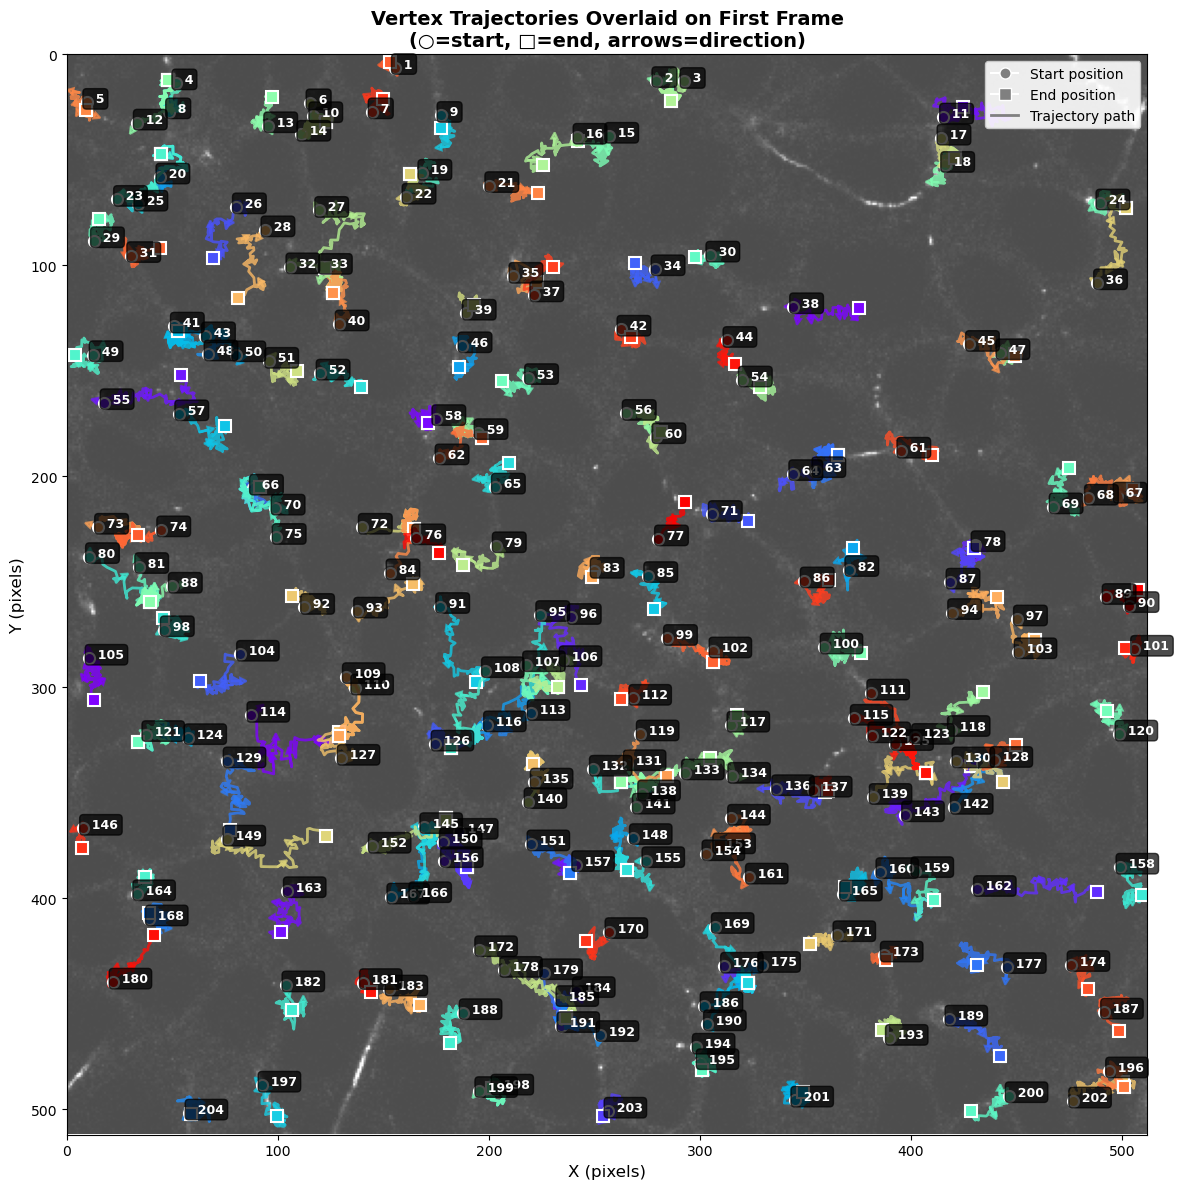

Speed distribution plot saved to: /Users/apple/Desktop/Ian_lab/data/260213-EpH4 Zo1mSG NT_Pals1KO + Cellbrite postcon3dys dy3/260213-EpH4 Zo1mSG NT_Pals1KO + Cellbrite post3dys dy3 004_crop_Cellbrite_KOn3_output/vertex_speed_distribution.png


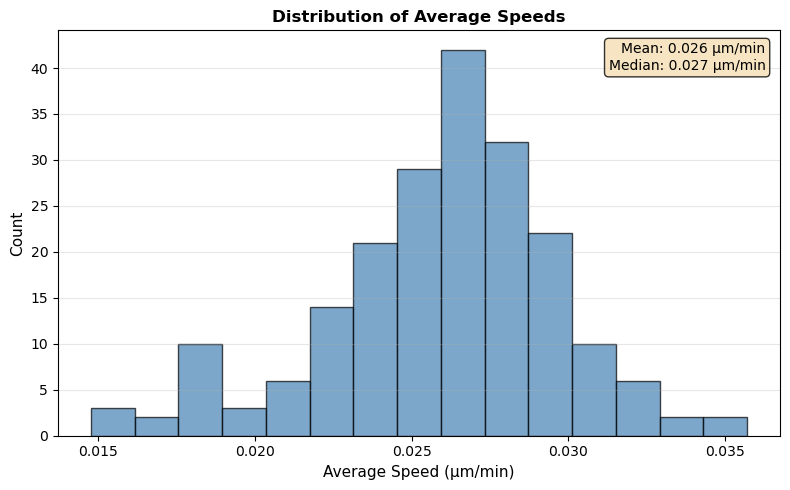


Movement analysis complete!


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path
from IPython.display import display

# Ensure we have tracking data
if 'rows' not in globals() or not rows:
    print("No tracking data found. Please run Step 3 first.")
else:
    # Create DataFrame from tracking data
    df_tracks = pd.DataFrame(rows)
    
    # Compute per-vertex statistics
    vertex_stats = []
    for track_id in df_tracks['TRACK_ID'].unique():
        track_data = df_tracks[df_tracks['TRACK_ID'] == track_id].sort_values('FRAME')
        
        if len(track_data) < 2:
            continue
        
        # Calculate total distance moved (cumulative sum of step distances)
        total_distance = track_data['step_um'].sum()
        
        # Calculate time span
        time_span_sec = (track_data['FRAME'].max() - track_data['FRAME'].min()) * DT_PER_FRAME_SEC
        time_span_min = time_span_sec / 60  # convert to minutes
        
        # Calculate average speed
        avg_speed = total_distance / time_span_sec if time_span_sec > 0 else 0
        avg_speed_per_min = total_distance / time_span_min if time_span_min > 0 else 0
        
        # Get start and end positions
        start_x = track_data.iloc[0]['x_um']
        start_y = track_data.iloc[0]['y_um']
        end_x = track_data.iloc[-1]['x_um']
        end_y = track_data.iloc[-1]['y_um']
        
        # Net displacement (straight-line distance from start to end)
        net_displacement = np.sqrt((end_x - start_x)**2 + (end_y - start_y)**2)
        
        vertex_stats.append({
            'TRACK_ID': int(track_id),
            'Total_Distance_um': total_distance,
            'Time_Span_sec': time_span_sec,
            'Time_Span_min': time_span_min,
            'Avg_Speed_um_per_sec': avg_speed,
            'Avg_Speed_um_per_min': avg_speed_per_min,
            'Net_Displacement_um': net_displacement,
            'N_Frames': len(track_data),
            'Start_X_um': start_x,
            'Start_Y_um': start_y,
            'End_X_um': end_x,
            'End_Y_um': end_y
        })
    
    df_stats = pd.DataFrame(vertex_stats).sort_values('Total_Distance_um', ascending=False)
    
    # Display statistics table
    print(f"{'='*80}\n")
    print(f"Total vertices tracked: {len(df_stats)}")
    total_time_sec = df_tracks['FRAME'].max() * DT_PER_FRAME_SEC
    total_time_min = total_time_sec / 60
    print(f"Total observation time: {total_time_sec:.2f} seconds ({total_time_min:.2f} minutes)\n")
    
    display(df_stats)
    
    # Save statistics to CSV
    OUT_DIR_PATH = Path(OUT_DIR)
    stats_csv_path = OUT_DIR_PATH / 'vertex_movement_statistics.csv'
    df_stats.to_csv(stats_csv_path, index=False)
    print(f"\nStatistics saved to: {stats_csv_path}")
    
    # ===== VISUALIZATION: Trajectories on First Frame =====
    print("\nGenerating trajectory visualization on first frame...")
    
    # Get first frame
    if 'frames' in globals() and len(frames) > 0:
        first_frame = frames[0]
        
        # Create figure
        fig, ax = plt.subplots(figsize=(12, 12))
        
        # Display first frame
        ax.imshow(first_frame, cmap='gray', alpha=0.7)
        
        # Define colormap for tracks
        import matplotlib.cm as cm
        n_tracks = len(df_stats)
        colors = cm.rainbow(np.linspace(0, 1, n_tracks))
        
        # Plot each track
        for idx, (_, row) in enumerate(df_stats.iterrows()):
            track_id = int(row['TRACK_ID'])  # Convert to integer (no decimal)
            track_data = df_tracks[df_tracks['TRACK_ID'] == row['TRACK_ID']].sort_values('FRAME')
            
            # Convert to pixels for plotting
            x_coords = track_data['x_um'].values / PIXEL_UM
            y_coords = track_data['y_um'].values / PIXEL_UM
            
            color = colors[idx]
            
            # Plot trajectory line
            ax.plot(x_coords, y_coords, '-', color=color, linewidth=2, alpha=0.8, label=f'ID {track_id}')
            
            # Add arrows to show direction
            # Add arrow every N points to avoid clutter
            arrow_interval = max(1, len(x_coords) // 5)
            for i in range(0, len(x_coords) - 1, arrow_interval):
                dx = x_coords[i + 1] - x_coords[i]
                dy = y_coords[i + 1] - y_coords[i]
                if np.sqrt(dx**2 + dy**2) > 1:  # Only draw arrow if movement is significant
                    ax.arrow(x_coords[i], y_coords[i], dx, dy, 
                            head_width=3, head_length=3, fc=color, ec=color, 
                            alpha=0.7, linewidth=1.5)
            
            # Mark start position with circle
            ax.plot(x_coords[0], y_coords[0], 'o', color=color, markersize=8, 
                   markeredgecolor='white', markeredgewidth=1.5)
            
            # Mark end position with square
            ax.plot(x_coords[-1], y_coords[-1], 's', color=color, markersize=8,
                   markeredgecolor='white', markeredgewidth=1.5)
            
            # Add track ID label at start position (using integer, no decimal)
            ax.text(x_coords[0], y_coords[0], f'  {track_id}', 
                   color='white', fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
        
        ax.set_xlim(0, first_frame.shape[1])
        ax.set_ylim(first_frame.shape[0], 0)
        ax.set_xlabel('X (pixels)', fontsize=12)
        ax.set_ylabel('Y (pixels)', fontsize=12)
        ax.set_title('Vertex Trajectories Overlaid on First Frame\n(○=start, □=end, arrows=direction)', 
                    fontsize=14, fontweight='bold')
        
        # Add legend with custom handles
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
                  markersize=8, label='Start position'),
            Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', 
                  markersize=8, label='End position'),
            Line2D([0], [0], color='gray', linewidth=2, label='Trajectory path')
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=10, framealpha=0.9)
        
        plt.tight_layout()
        
        # Save figure
        trajectory_img_path = OUT_DIR_PATH / 'vertex_trajectories_on_first_frame.png'
        fig.savefig(trajectory_img_path, dpi=150, bbox_inches='tight')
        print(f"Trajectory visualization saved to: {trajectory_img_path}")
        
        plt.show()
        
        # ===== Additional Plot: Speed Distribution =====
        fig2, ax1 = plt.subplots(1, 1, figsize=(8, 5))
        
        # Histogram of average speeds (in µm/min)
        ax1.hist(df_stats['Avg_Speed_um_per_min'], bins=15, color='steelblue', 
                edgecolor='black', alpha=0.7)
        ax1.set_xlabel('Average Speed (µm/min)', fontsize=11)
        ax1.set_ylabel('Count', fontsize=11)
        ax1.set_title('Distribution of Average Speeds', fontsize=12, fontweight='bold')
        ax1.grid(axis='y', alpha=0.3)
        
        # Add statistics text box
        mean_speed = df_stats['Avg_Speed_um_per_min'].mean()
        median_speed = df_stats['Avg_Speed_um_per_min'].median()
        stats_text = f'Mean: {mean_speed:.3f} µm/min\nMedian: {median_speed:.3f} µm/min'
        ax1.text(0.98, 0.97, stats_text, transform=ax1.transAxes, 
                fontsize=10, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.tight_layout()
        
        # Save figure
        speed_dist_path = OUT_DIR_PATH / 'vertex_speed_distribution.png'
        fig2.savefig(speed_dist_path, dpi=150, bbox_inches='tight')
        print(f"Speed distribution plot saved to: {speed_dist_path}")
        
        plt.show()
    else:
        print("First frame not available for visualization. Run Step 1 first.")
    
    print(f"\n{'='*80}")
    print("Movement analysis complete!")
    print(f"{'='*80}")

## 5.6) Compare Average Speed Distribution between NT and Pals1 KO Groups

SIMPLIFIED FOLDER SELECTION

📁 INSTRUCTIONS:
  1. Confirm or set the base directory
  2. Enter only folder NAMES (not full paths)
  3. Paste multiple folder names at once!

Current base directory: /Users/apple/Desktop/Ian_lab/data
✓ Using: /Users/apple/Desktop/Ian_lab/data

📂 Available folders in data:
   1. 000_Pals1_KO_cell_height
   2. 20250910_KOPals1-sg1c4-ZO1-CB650-TJ_003_0002_crop53x54_output
   3. 250919-EpH4 P6Z3E10+KOCV2-mCrb3sg1.3_2
   4. 250919-EpH4 P6Z3E10+KOCV2-mCrb3sg1.3_2.1 Zo1-mSG dy5 012-MaxIP_crop02
   5. 250919-EpH4 P6Z3E10+KOCV2-mCrb3sg1.3_2.1 Zo1-mSG dy5 012-MaxIP_crop02_analysis
   6. 250919-EpH4 P6Z3E10+KOCV2-mCrb3sg1.3_2_analysis
   7. 250919-EpH4 P6Z3E10+KOCV2-mCrb3sg1.3_n2_analysis
   8. 250925--EpH4 P6Z3E10+KO CV2-mCrb3sg1.3 2.1 Zo1-mSG dy3 007-MaxIP_crop_2,1n2
   9. 250925--EpH4 P6Z3E10+KO CV2-mCrb3sg1.3 2.1 Zo1-mSG dy3 007-MaxIP_crop_2,1n2_analysis
  10. 250930--EpH4 NT_KO +CellBrite Zo1-mSG dy3 002_crop-MaxIPNT_cropn1_analysis
  11. 250930--EpH4 NT_KO +Ce

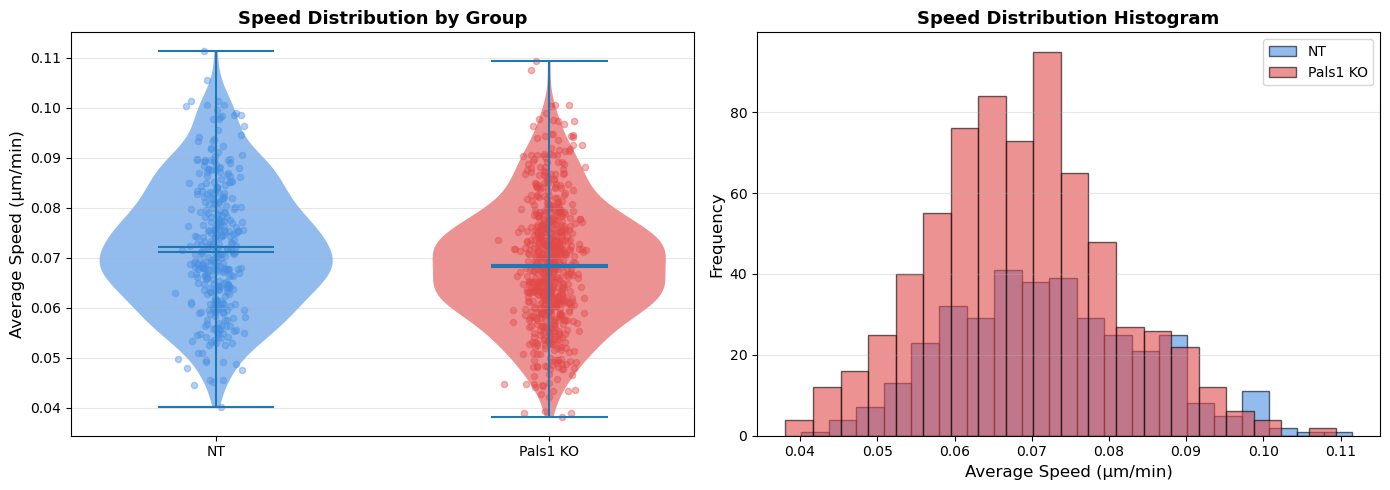


DISPERSION ANALYSIS

✅ Dispersion figure saved: /Users/apple/Desktop/Ian_lab/data/group_comparison_results/dispersion_comparison_NT_vs_Pals1KO.png


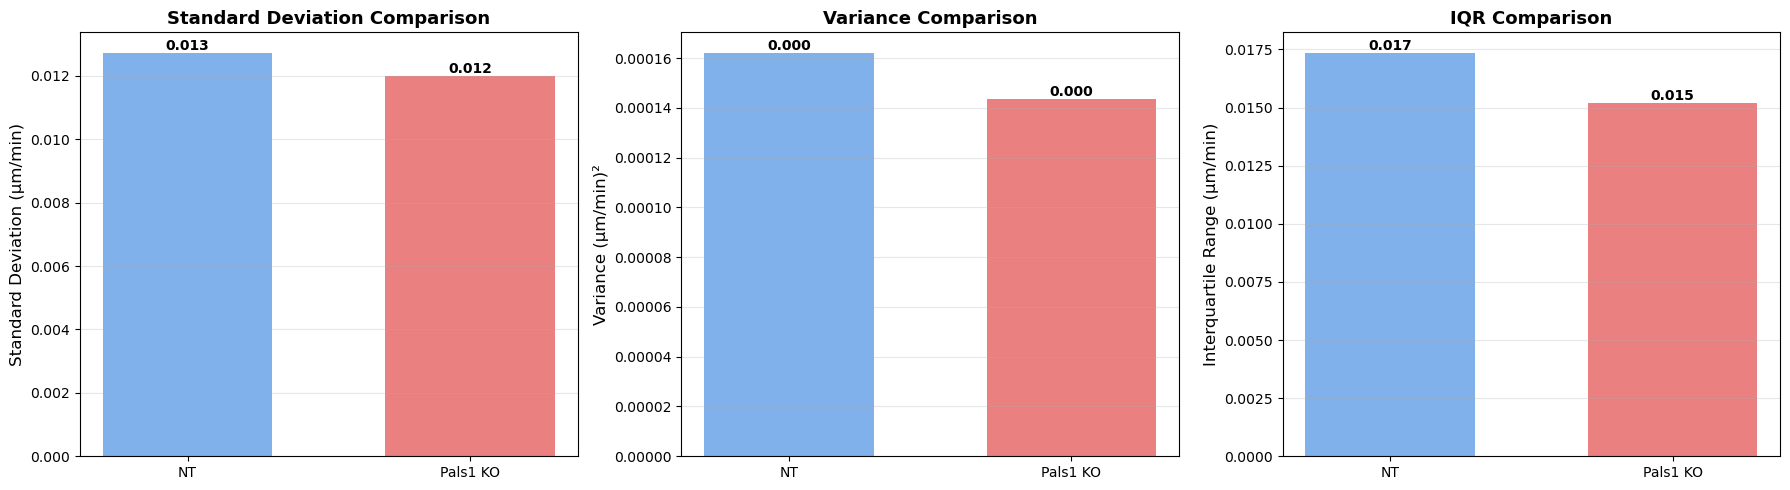


--------------------------------------------------------------------------------
DISPERSION MEASURES
--------------------------------------------------------------------------------

NT Group:
  Standard Deviation: 0.0127 µm/min
  Variance: 0.0002 (µm/min)²
  IQR: 0.0174 µm/min
  Range: 0.0713 µm/min
  Coefficient of Variation (CV): 17.65%

Pals1 KO Group:
  Standard Deviation: 0.0120 µm/min
  Variance: 0.0001 (µm/min)²
  IQR: 0.0152 µm/min
  Range: 0.0714 µm/min
  Coefficient of Variation (CV): 17.47%

--------------------------------------------------------------------------------
VARIANCE COMPARISON TESTS
--------------------------------------------------------------------------------


NameError: name 'nt_speeds_clean' is not defined

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
from glob import glob

# ===== Simplified folder name input =====
print("="*80)
print("SIMPLIFIED FOLDER SELECTION")
print("="*80)
print("\n📁 INSTRUCTIONS:")
print("  1. Confirm or set the base directory")
print("  2. Enter only folder NAMES (not full paths)")
print("  3. Paste multiple folder names at once!")
print("="*80)

# Step 1: Set base directory
default_base = '/Users/apple/Desktop/Ian_lab/data'
print(f"\nCurrent base directory: {default_base}")
change_base = input("Change base directory? (y/n, default=n): ").strip().lower()

if change_base == 'y':
    new_base = input("Enter new base directory path: ").strip()
    if new_base and Path(new_base).exists():
        base_dir = Path(new_base)
        print(f"✓ Using: {base_dir}")
    else:
        print(f"⚠ Directory not found, using default: {default_base}")
        base_dir = Path(default_base)
else:
    base_dir = Path(default_base)
    print(f"✓ Using: {base_dir}")

# Show available folders
print(f"\n📂 Available folders in {base_dir.name}:")
try:
    subdirs = [d.name for d in base_dir.iterdir() if d.is_dir()]
    subdirs.sort()
    for i, dirname in enumerate(subdirs[:20], 1):  # Show first 20
        print(f"  {i:2d}. {dirname}")
    if len(subdirs) > 20:
        print(f"  ... and {len(subdirs) - 20} more")
except Exception as e:
    print(f"  ⚠ Could not list folders: {e}")

# Function to process folder names
def get_csv_files_from_names(group_name, base_directory):
    """Get CSV files by entering folder names (not full paths)"""
    print(f"\n{'='*80}")
    print(f"SELECT {group_name.upper()} GROUP FOLDERS")
    print(f"{'='*80}")
    print("Enter folder NAMES (one per line or comma-separated)")
    print("Examples:")
    print("  NT_sample1")
    print("  NT_sample2, NT_sample3")
    print("\nPress Enter twice (empty line) when done.\n")
    
    lines = []
    print(f"Enter {group_name} folder names:")
    
    while True:
        try:
            line = input()
            if not line.strip():
                if len(lines) == 0:
                    print("  (Waiting for input...)")
                    continue
                else:
                    break
            lines.append(line)
        except EOFError:
            break
    
    # Parse folder names
    folder_names = []
    for line in lines:
        for name in line.split(','):
            name = name.strip()
            if name:
                folder_names.append(name)
    
    # Find CSV files
    csv_files = []
    print(f"\n📂 Processing {len(folder_names)} folder(s)...")
    
    for i, folder_name in enumerate(folder_names, 1):
        folder_path = base_directory / folder_name
        
        if not folder_path.exists():
            print(f"  {i}. ✗ Folder not found: {folder_name}")
            continue
        
        if not folder_path.is_dir():
            print(f"  {i}. ⚠ Not a directory: {folder_name}")
            continue
        
        # Look for CSV file
        csv_file = folder_path / 'vertex_movement_statistics.csv'
        
        if csv_file.exists():
            csv_files.append(csv_file)
            print(f"  {i}. ✓ {folder_name}/vertex_movement_statistics.csv")
        else:
            # Try alternative CSV files
            alt_csvs = list(folder_path.glob('*statistics*.csv'))
            if alt_csvs:
                csv_files.append(alt_csvs[0])
                print(f"  {i}. ✓ {folder_name}/{alt_csvs[0].name}")
            else:
                print(f"  {i}. ✗ No statistics CSV in: {folder_name}")
    
    return csv_files

# Selection method choice
print("\n" + "="*80)
print("SELECTION METHOD")
print("="*80)
print("1. Quick entry (enter folder names)")
print("2. Auto-search (find all CSVs, assign by numbers)")
print("="*80)

choice = input("\nEnter 1 or 2 (default=1): ").strip() or '1'

if choice == '2':
    # Auto-search method
    print(f"\n🔍 Searching for CSV files in: {base_dir}")
    print("This may take a moment...\n")
    
    search_pattern = str(base_dir / '**/vertex_movement_statistics.csv')
    all_csv_files = glob(search_pattern, recursive=True)
    
    if not all_csv_files:
        print("⚠ No 'vertex_movement_statistics.csv' found!")
        print("Trying alternative pattern...")
        search_pattern = str(base_dir / '**/*statistics*.csv')
        all_csv_files = glob(search_pattern, recursive=True)
    
    if all_csv_files:
        print(f"✓ Found {len(all_csv_files)} CSV files:\n")
        for i, csv_path in enumerate(all_csv_files, 1):
            csv_p = Path(csv_path)
            relative_path = csv_p.relative_to(base_dir) if csv_p.is_relative_to(base_dir) else csv_p
            print(f"  {i:2d}. {relative_path}")
        
        print("\n" + "="*80)
        print("ASSIGN FILES TO GROUPS")
        print("="*80)
        print("Enter file numbers for each group")
        print("Examples: 1,2,3  or  1-3  or  1,3,5-7")
        print("="*80 + "\n")
        
        nt_indices = input("NT group numbers: ").strip()
        ko_indices = input("Pals1 KO numbers: ").strip()
        
        # Parse number ranges
        def parse_numbers(text):
            nums = []
            for part in text.replace(' ', '').split(','):
                if '-' in part:
                    start, end = map(int, part.split('-'))
                    nums.extend(range(start, end + 1))
                elif part.isdigit():
                    nums.append(int(part))
            return nums
        
        nt_files = []
        ko_files = []
        
        if nt_indices:
            for idx in parse_numbers(nt_indices):
                if 1 <= idx <= len(all_csv_files):
                    nt_files.append(Path(all_csv_files[idx - 1]))
        
        if ko_indices:
            for idx in parse_numbers(ko_indices):
                if 1 <= idx <= len(all_csv_files):
                    ko_files.append(Path(all_csv_files[idx - 1]))
    else:
        print("❌ No CSV files found! Using manual entry...")
        nt_files = get_csv_files_from_names("NT", base_dir)
        ko_files = get_csv_files_from_names("Pals1 KO", base_dir)
else:
    # Quick folder name entry (default)
    print("\n📝 Quick entry mode")
    nt_files = get_csv_files_from_names("NT", base_dir)
    ko_files = get_csv_files_from_names("Pals1 KO", base_dir)

# Display summary
print("\n" + "="*80)
print("FILE SELECTION SUMMARY")
print("="*80)
print(f"\n📊 NT group: {len(nt_files)} files")
for i, file_path in enumerate(nt_files, 1):
    print(f"  {i}. {file_path.parent.name}/{file_path.name}")

print(f"\n📊 Pals1 KO group: {len(ko_files)} files")
for i, file_path in enumerate(ko_files, 1):
    print(f"  {i}. {file_path.parent.name}/{file_path.name}")

print("\n" + "="*80)
print("LOADING CSV FILES...")
print("="*80)

# Load and combine data
nt_data_list = []
for i, file_path in enumerate(nt_files):
    if file_path.exists():
        df = pd.read_csv(file_path)
        df['Group'] = 'NT'
        df['Repeat'] = f'Repeat_{i+1}'
        df['Folder'] = file_path.parent.name
        nt_data_list.append(df)
        print(f"✓ Loaded NT Repeat {i+1}: {file_path.parent.name} ({len(df)} vertices)")
    else:
        print(f"✗ File not found: {file_path}")

ko_data_list = []
for i, file_path in enumerate(ko_files):
    if file_path.exists():
        df = pd.read_csv(file_path)
        df['Group'] = 'Pals1 KO'
        df['Repeat'] = f'Repeat_{i+1}'
        df['Folder'] = file_path.parent.name
        ko_data_list.append(df)
        print(f"✓ Loaded KO Repeat {i+1}: {file_path.parent.name} ({len(df)} vertices)")
    else:
        print(f"✗ File not found: {file_path}")

# Combine all data
if nt_data_list and ko_data_list:
    combined_data = pd.concat(nt_data_list + ko_data_list, ignore_index=True)
    
    # Define output directory
    output_dir = base_dir / 'group_comparison_results'
    output_dir.mkdir(parents=True, exist_ok=True)
    print(f"\n📁 Output directory: {output_dir}")
    
    # ===== Create comparison figure =====
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Color palette
    colors = {'NT': '#4A90E2', 'Pals1 KO': '#E24A4A'}
    
    # 1. Violin plot with individual points
    ax1 = axes[0]
    parts = ax1.violinplot(
        [combined_data[combined_data['Group'] == 'NT']['Avg_Speed_um_per_min'].dropna(),
         combined_data[combined_data['Group'] == 'Pals1 KO']['Avg_Speed_um_per_min'].dropna()],
        positions=[0, 1],
        widths=0.7,
        showmeans=True,
        showmedians=True
    )
    
    # Color the violin plots
    for i, pc in enumerate(parts['bodies']):
        group = ['NT', 'Pals1 KO'][i]
        pc.set_facecolor(colors[group])
        pc.set_alpha(0.6)
    
    # Add scatter points with jitter
    for i, group in enumerate(['NT', 'Pals1 KO']):
        data = combined_data[combined_data['Group'] == group]['Avg_Speed_um_per_min'].dropna()
        y = data.values
        x = np.random.normal(i, 0.04, size=len(y))
        ax1.scatter(x, y, alpha=0.4, s=20, color=colors[group])
    
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(['NT', 'Pals1 KO'])
    ax1.set_ylabel('Average Speed (µm/min)', fontsize=12)
    ax1.set_title('Speed Distribution by Group', fontsize=13, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Histogram overlay
    ax2 = axes[1]
    nt_speeds = combined_data[combined_data['Group'] == 'NT']['Avg_Speed_um_per_min'].dropna()
    ko_speeds = combined_data[combined_data['Group'] == 'Pals1 KO']['Avg_Speed_um_per_min'].dropna()
    
    ax2.hist(nt_speeds, bins=20, alpha=0.6, label='NT', color=colors['NT'], edgecolor='black')
    ax2.hist(ko_speeds, bins=20, alpha=0.6, label='Pals1 KO', color=colors['Pals1 KO'], edgecolor='black')
    ax2.set_xlabel('Average Speed (µm/min)', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Speed Distribution Histogram', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    # Save figure
    comparison_path = output_dir / 'speed_comparison_NT_vs_Pals1KO.png'
    fig.savefig(comparison_path, dpi=300, bbox_inches='tight')
    print(f"\n✅ Figure saved: {comparison_path}")
    
    plt.show()
    
    # ===== Dispersion Analysis Figure =====
    print("\n" + "="*80)
    print("DISPERSION ANALYSIS")
    print("="*80)
    
    fig2, axes2 = plt.subplots(1, 3, figsize=(18, 5))
    
    # Calculate dispersion measures
    nt_std = nt_speeds.std()
    ko_std = ko_speeds.std()
    nt_var = nt_speeds.var()
    ko_var = ko_speeds.var()
    nt_iqr = nt_speeds.quantile(0.75) - nt_speeds.quantile(0.25)
    ko_iqr = ko_speeds.quantile(0.75) - ko_speeds.quantile(0.25)
    
    # 1. Standard Deviation comparison
    ax1_disp = axes2[0]
    x_pos = np.array([0, 1])
    std_values = [nt_std, ko_std]
    bars1 = ax1_disp.bar(x_pos, std_values, color=[colors['NT'], colors['Pals1 KO']], alpha=0.7, width=0.6)
    ax1_disp.set_xticks(x_pos)
    ax1_disp.set_xticklabels(['NT', 'Pals1 KO'])
    ax1_disp.set_ylabel('Standard Deviation (µm/min)', fontsize=12)
    ax1_disp.set_title('Standard Deviation Comparison', fontsize=13, fontweight='bold')
    ax1_disp.grid(axis='y', alpha=0.3)
    
    # Add values on top of bars
    for i, (bar, val) in enumerate(zip(bars1, std_values)):
        height = bar.get_height()
        ax1_disp.text(bar.get_x() + bar.get_width()/2., height,
                     f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 2. Variance comparison
    ax2_disp = axes2[1]
    var_values = [nt_var, ko_var]
    bars2 = ax2_disp.bar(x_pos, var_values, color=[colors['NT'], colors['Pals1 KO']], alpha=0.7, width=0.6)
    ax2_disp.set_xticks(x_pos)
    ax2_disp.set_xticklabels(['NT', 'Pals1 KO'])
    ax2_disp.set_ylabel('Variance (µm/min)²', fontsize=12)
    ax2_disp.set_title('Variance Comparison', fontsize=13, fontweight='bold')
    ax2_disp.grid(axis='y', alpha=0.3)
    
    for i, (bar, val) in enumerate(zip(bars2, var_values)):
        height = bar.get_height()
        ax2_disp.text(bar.get_x() + bar.get_width()/2., height,
                     f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 3. IQR comparison
    ax3_disp = axes2[2]
    iqr_values = [nt_iqr, ko_iqr]
    bars3 = ax3_disp.bar(x_pos, iqr_values, color=[colors['NT'], colors['Pals1 KO']], alpha=0.7, width=0.6)
    ax3_disp.set_xticks(x_pos)
    ax3_disp.set_xticklabels(['NT', 'Pals1 KO'])
    ax3_disp.set_ylabel('Interquartile Range (µm/min)', fontsize=12)
    ax3_disp.set_title('IQR Comparison', fontsize=13, fontweight='bold')
    ax3_disp.grid(axis='y', alpha=0.3)
    
    for i, (bar, val) in enumerate(zip(bars3, iqr_values)):
        height = bar.get_height()
        ax3_disp.text(bar.get_x() + bar.get_width()/2., height,
                     f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    
    # Save dispersion figure
    dispersion_path = output_dir / 'dispersion_comparison_NT_vs_Pals1KO.png'
    fig2.savefig(dispersion_path, dpi=300, bbox_inches='tight')
    print(f"\n✅ Dispersion figure saved: {dispersion_path}")
    
    plt.show()
    
    # Print dispersion statistics
    print("\n" + "-"*80)
    print("DISPERSION MEASURES")
    print("-"*80)
    print(f"\nNT Group:")
    print(f"  Standard Deviation: {nt_std:.4f} µm/min")
    print(f"  Variance: {nt_var:.4f} (µm/min)²")
    print(f"  IQR: {nt_iqr:.4f} µm/min")
    print(f"  Range: {nt_speeds.max() - nt_speeds.min():.4f} µm/min")
    print(f"  Coefficient of Variation (CV): {(nt_std/nt_speeds.mean())*100:.2f}%")
    
    print(f"\nPals1 KO Group:")
    print(f"  Standard Deviation: {ko_std:.4f} µm/min")
    print(f"  Variance: {ko_var:.4f} (µm/min)²")
    print(f"  IQR: {ko_iqr:.4f} µm/min")
    print(f"  Range: {ko_speeds.max() - ko_speeds.min():.4f} µm/min")
    print(f"  Coefficient of Variation (CV): {(ko_std/ko_speeds.mean())*100:.2f}%")
    
    # Statistical tests for comparing variances
    print("\n" + "-"*80)
    print("VARIANCE COMPARISON TESTS")
    print("-"*80)
    
    # Levene's test (more robust to non-normality)
    levene_stat, levene_p = stats.levene(nt_speeds_clean, ko_speeds_clean)
    print(f"\nLevene's Test (equality of variances):")
    print(f"  Statistic = {levene_stat:.4f}")
    print(f"  p-value = {levene_p:.4e}")
    print(f"  Interpretation: {'Variances are significantly different' if levene_p < 0.05 else 'No significant difference in variances'}")
    
    # F-test for variance (assumes normality)
    f_stat = nt_var / ko_var if nt_var > ko_var else ko_var / nt_var
    df1 = len(nt_speeds) - 1
    df2 = len(ko_speeds) - 1
    f_pvalue = 2 * min(stats.f.cdf(f_stat, df1, df2), 1 - stats.f.cdf(f_stat, df1, df2))
    print(f"\nF-test for variance:")
    print(f"  F-statistic = {f_stat:.4f}")
    print(f"  p-value = {f_pvalue:.4e}")
    print(f"  Interpretation: {'Variances are significantly different' if f_pvalue < 0.05 else 'No significant difference in variances'}")
    
    # Ratio comparison
    print(f"\nVariance Ratio (larger/smaller): {max(nt_var, ko_var) / min(nt_var, ko_var):.2f}x")
    print(f"SD Ratio (larger/smaller): {max(nt_std, ko_std) / min(nt_std, ko_std):.2f}x")
    
    if nt_std > ko_std:
        print(f"\n➤ NT group shows {((nt_std/ko_std - 1) * 100):.1f}% greater spread than Pals1 KO")
    else:
        print(f"\n➤ Pals1 KO group shows {((ko_std/nt_std - 1) * 100):.1f}% greater spread than NT")
    
    # ===== Statistical Analysis =====
    print("\n" + "="*80)
    print("STATISTICAL ANALYSIS")
    print("="*80)
    
    for group in ['NT', 'Pals1 KO']:
        group_data = combined_data[combined_data['Group'] == group]['Avg_Speed_um_per_min'].dropna()
        n_repeats = combined_data[combined_data['Group'] == group]['Repeat'].nunique()
        print(f"\n{group}:")
        print(f"  n = {len(group_data)} vertices ({n_repeats} repeats)")
        print(f"  Mean ± SD: {group_data.mean():.4f} ± {group_data.std():.4f} µm/min")
        print(f"  Median [IQR]: {group_data.median():.4f} [{group_data.quantile(0.25):.4f}-{group_data.quantile(0.75):.4f}]")
    
    print("\n" + "-"*80)
    print("STATISTICAL TESTS")
    print("-"*80)
    
    nt_speeds_clean = combined_data[combined_data['Group'] == 'NT']['Avg_Speed_um_per_min'].dropna()
    ko_speeds_clean = combined_data[combined_data['Group'] == 'Pals1 KO']['Avg_Speed_um_per_min'].dropna()
    
    statistic_mw, pvalue_mw = stats.mannwhitneyu(nt_speeds_clean, ko_speeds_clean, alternative='two-sided')
    print(f"\nMann-Whitney U test:")
    print(f"  U-statistic = {statistic_mw:.2f}")
    print(f"  p-value = {pvalue_mw:.4e}")
    
    statistic_t, pvalue_t = stats.ttest_ind(nt_speeds_clean, ko_speeds_clean)
    print(f"\nIndependent t-test:")
    print(f"  t-statistic = {statistic_t:.4f}")
    print(f"  p-value = {pvalue_t:.4e}")
    
    pooled_std = np.sqrt((nt_speeds_clean.std()**2 + ko_speeds_clean.std()**2) / 2)
    cohens_d = (nt_speeds_clean.mean() - ko_speeds_clean.mean()) / pooled_std
    print(f"\nEffect size (Cohen's d): {cohens_d:.4f}")
    
    print("\n" + "="*80)
    
    # Save combined data
    combined_csv_path = output_dir / 'combined_speed_data_all_groups.csv'
    combined_data.to_csv(combined_csv_path, index=False)
    print(f"✅ Data saved: {combined_csv_path}")
    
else:
    print("\n" + "="*80)
    print("⚠️ ERROR: Insufficient data!")
    print("="*80)
    if not nt_data_list:
        print(f"\n✗ No NT data loaded ({len(nt_files)} files selected)")
    if not ko_data_list:
        print(f"\n✗ No KO data loaded ({len(ko_files)} files selected)")
    print("\n" + "="*80)

## 6) Plot trajectories + cumulative plots + summary csv

In [4]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from IPython.display import display, Image

OUT = Path(globals().get("OUT_DIR", "."))
OUT.mkdir(parents=True, exist_ok=True)

DPI = int(globals().get("DPI", 300))
FIGSIZE_TRAJ = globals().get("FIGSIZE_TRAJ", (8, 8))
FIGSIZE_CUM = globals().get("FIGSIZE_CUM", (8, 5))
FIGSIZE_SPEED = globals().get("FIGSIZE_SPEED", (10, 5))
FIGSIZE_MSD = globals().get("FIGSIZE_MSD", (7, 5))
FIGSIZE_RMSD = globals().get("FIGSIZE_RMSD", (8, 5))
MSD_FIT_LAGS = int(globals().get("MSD_FIT_LAGS", 4))

det_csv = OUT / "detections_vertices_with_IDs.csv"
tracks_csv = OUT / "tracks_per_frame.csv"

if "tracks" not in globals() or tracks is None or len(tracks) == 0:
    if det_csv.exists():
        tracks = pd.read_csv(det_csv)
        print("Loaded tracks from detections_vertices_with_IDs.csv (canonical Step 3 output)")
    elif tracks_csv.exists():
        tracks = pd.read_csv(tracks_csv)
        print("Loaded tracks from tracks_per_frame.csv")
    else:
        raise AssertionError("tracks DataFrame not found in kernel and no Step-3 CSVs on disk.")
else:
    if det_csv.exists():
        try:
            tracks = pd.read_csv(det_csv)
            print("Replaced in-kernel tracks with detections_vertices_with_IDs.csv to ensure ID consistency")
        except Exception as err:
            print("Failed to reload detections_vertices_with_IDs.csv, using in-kernel tracks:", err)

if "TRACK_ID" not in tracks.columns and "ID" in tracks.columns:
    tracks["TRACK_ID"] = tracks["ID"]

if "TRACK_ID" not in tracks.columns:
    raise AssertionError("tracks DataFrame requires TRACK_ID column.")

if "FRAME" not in tracks.columns:
    tracks["FRAME"] = tracks.index

pixel_um = float(globals().get("PIXEL_UM", 1.0))

if "x_um" not in tracks.columns and "x_px" in tracks.columns:
    tracks["x_um"] = tracks["x_px"].astype(float) * pixel_um
    tracks["y_um"] = tracks["y_px"].astype(float) * pixel_um
elif "x_um" in tracks.columns and "y_um" in tracks.columns:
    tracks["x_um"] = tracks["x_um"].astype(float)
    tracks["y_um"] = tracks["y_um"].astype(float)
else:
    raise AssertionError("tracks DataFrame is missing x_um / y_um columns after preprocessing.")

if "TRACK_ID" in tracks.columns:
    tracks["TRACK_ID"] = tracks["TRACK_ID"].astype(int)

tracks = tracks.sort_values(["TRACK_ID", "FRAME"]).reset_index(drop=True)
tracks = finalize_tracks(tracks)
globals()["tracks"] = tracks

try:
    summary = compute_summary(tracks)
except Exception as err:
    print("compute_summary failed:", err)
    summary = pd.DataFrame()

try:
    rmsd_df = compute_rmsd_per_track(tracks)
    summary = merge_summary_with_rmsd(summary, rmsd_df)
except Exception as err:
    print("RMSD computation for exports failed:", err)

summary_with_rmsd_path = OUT / "tracks_summary_with_RMSD.csv"
summary.to_csv(summary_with_rmsd_path, index=False)
print(f"Saved summary with RMSD: {summary_with_rmsd_path} ({len(summary)} tracks)")

summary_path = OUT / "tracks_summary_export.csv"
summary.to_csv(summary_path, index=False)
print(f"Saved legacy summary export: {summary_path} ({len(summary)} tracks)")

summary_with_rmsd_df = summary.copy()
globals()["summary_with_rmsd_df"] = summary_with_rmsd_df
globals()["summary"] = summary
try:
    display(summary.head(20))
except Exception:
    print(summary.head())

if tracks.empty:
    raise AssertionError("tracks DataFrame is empty after processing; nothing to plot.")

unique_ids = sorted(tracks["TRACK_ID"].unique())
num_colors = max(3, len(unique_ids))
try:
    cmap = mpl.colormaps["tab20"].resampled(num_colors)
except Exception:
    try:
        cmap = plt.get_cmap("tab20", num_colors)
    except TypeError:
        cmap = plt.get_cmap("tab20")
        if hasattr(cmap, "resampled"):
            cmap = cmap.resampled(num_colors)
color_map = {tid: mpl.colors.to_hex(cmap(i % cmap.N)) for i, tid in enumerate(unique_ids)}

px_per_um = 1.0 / pixel_um if pixel_um else 1.0
tracks_px = tracks.copy()
tracks_px["x_px"] = tracks_px["x_um"] * px_per_um
tracks_px["y_px"] = tracks_px["y_um"] * px_per_um

def _resolve_base_frame():
    frames_obj = globals().get("frames")
    if isinstance(frames_obj, list) and len(frames_obj):
        return frames_obj[0]
    stack_path = globals().get("STACK_PATH")
    if stack_path:
        try:
            frame_list = read_frames(stack_path)
            if isinstance(frame_list, list) and len(frame_list):
                return frame_list[0]
        except Exception as err:
            print("Failed to load STACK_PATH for overlay:", err)
    return None

base_frame = _resolve_base_frame()

if base_frame is not None:
    fig_overlay, ax_overlay = plt.subplots(figsize=FIGSIZE_TRAJ)
    if getattr(base_frame, "ndim", 2) == 2:
        ax_overlay.imshow(base_frame, cmap="gray")
    else:
        ax_overlay.imshow(base_frame)
    for tid in unique_ids:
        g = tracks_px[tracks_px["TRACK_ID"] == tid]
        if g.empty:
            continue
        ax_overlay.plot(g["x_px"], g["y_px"], marker="o", markersize=2.5, linewidth=1.5, color=color_map.get(tid, "#ffcc00"), label=str(tid))
    ax_overlay.set_title("Trajectories overlaid on frame 0")
    ax_overlay.set_xticks([])
    ax_overlay.set_yticks([])
    if hasattr(base_frame, "shape") and len(base_frame.shape) >= 2:
        ax_overlay.set_xlim(0, base_frame.shape[1])
        ax_overlay.set_ylim(base_frame.shape[0], 0)
    if len(unique_ids) <= 12:
        ax_overlay.legend(title="TRACK_ID", bbox_to_anchor=(1.05, 1.0), loc="upper left", fontsize="small")
    plt.tight_layout()
    overlay_png = OUT / "all_trajectories_overlay.png"
    fig_overlay.savefig(overlay_png, dpi=DPI, bbox_inches="tight")
    print(f"Saved trajectories overlay PNG: {overlay_png}")
    try:
        display(Image(str(overlay_png)))
    except Exception:
        pass
    plt.close(fig_overlay)
else:
    print("Warning: No base frame available; skipping trajectories overlay export.")

fig_xy, ax_xy = plt.subplots(figsize=FIGSIZE_TRAJ)
for tid in unique_ids:
    g = tracks[tracks["TRACK_ID"] == tid]
    if g.empty:
        continue
    ax_xy.plot(g["x_um"], g["y_um"], marker="o", markersize=3, linewidth=1.25, color=color_map.get(tid, "#333333"), label=str(tid))
ax_xy.set_xlabel("X (µm)")
ax_xy.set_ylabel("Y (µm)")
ax_xy.set_title("All trajectories (x vs y)")
ax_xy.set_aspect("equal", adjustable="datalim")
if len(unique_ids) <= 12:
    ax_xy.legend(title="TRACK_ID", bbox_to_anchor=(1.05, 1.0), loc="upper left", fontsize="small")
plt.tight_layout()
traj_png = OUT / "all_trajectories.png"
fig_xy.savefig(traj_png, dpi=DPI, bbox_inches="tight")
print(f"Saved high-res trajectories PNG: {traj_png}")
try:
    display(Image(str(traj_png)))
except Exception:
    pass
plt.close(fig_xy)

use_time = "t_min" in tracks.columns and np.isfinite(tracks["t_min"]).any()
xlabel = "Time (min)" if use_time else "Frame"

fig_cum, ax_cum = plt.subplots(figsize=FIGSIZE_CUM)
for tid in unique_ids:
    g = tracks[tracks["TRACK_ID"] == tid]
    if g.empty:
        continue
    xvals = g["t_min"] if use_time else g["FRAME"]
    ax_cum.plot(xvals, g["cum_um"], marker=".", markersize=3, linewidth=1.0, color=color_map.get(tid, "#333333"), label=str(tid))
ax_cum.set_xlabel(xlabel)
ax_cum.set_ylabel("Cumulative distance (µm)")
ax_cum.set_title("Cumulative distance per TRACK_ID")
if len(unique_ids) <= 12:
    ax_cum.legend(title="TRACK_ID", bbox_to_anchor=(1.05, 1.0), loc="upper left", fontsize="small")
plt.tight_layout()
cum_png = OUT / "cumulative_distance.png"
fig_cum.savefig(cum_png, dpi=DPI, bbox_inches="tight")
print(f"Saved high-res cumulative PNG: {cum_png}")
try:
    display(Image(str(cum_png)))
except Exception:
    pass
plt.close(fig_cum)

speed_df = tracks[["TRACK_ID", "inst_speed_um_per_min"]].replace([np.inf, -np.inf], np.nan).dropna()
grouped_speeds = [(tid, speed_df[speed_df["TRACK_ID"] == tid]["inst_speed_um_per_min"].to_numpy()) for tid in unique_ids]
grouped_speeds = [(tid, arr) for tid, arr in grouped_speeds if arr.size > 0]

if grouped_speeds:
    labels = [str(tid) for tid, _ in grouped_speeds]
    data = [arr for _, arr in grouped_speeds]
    fig_speed, axes_speed = plt.subplots(1, 2, figsize=FIGSIZE_SPEED, sharey=True)
    boxplot = axes_speed[0].boxplot(data, labels=labels, patch_artist=True)
    axes_speed[0].set_title("Instantaneous speed — boxplot")
    axes_speed[0].set_ylabel("Speed (µm/min)")
    axes_speed[0].tick_params(axis="x", rotation=45)
    for patch, tid in zip(boxplot["boxes"], [tid for tid, _ in grouped_speeds]):
        patch.set_facecolor(color_map.get(tid, "#999999"))
        patch.set_alpha(0.7)
    violin = axes_speed[1].violinplot(data, showmeans=True, showextrema=False)
    for body, tid in zip(violin["bodies"], [tid for tid, _ in grouped_speeds]):
        body.set_facecolor(color_map.get(tid, "#999999"))
        body.set_alpha(0.7)
    axes_speed[1].set_title("Instantaneous speed — violin")
    axes_speed[1].set_xticks(range(1, len(labels) + 1))
    axes_speed[1].set_xticklabels(labels, rotation=45, ha="right")
    axes_speed[1].set_ylabel("Speed (µm/min)")
    plt.tight_layout()
    speed_png = OUT / "speed_distribution.png"
    fig_speed.savefig(speed_png, dpi=DPI, bbox_inches="tight")
    print(f"Saved speed distribution PNG: {speed_png}")
    try:
        display(Image(str(speed_png)))
    except Exception:
        pass
    plt.close(fig_speed)
else:
    print("No instantaneous speed data available; skipping speed distribution export.")

rmsd_plot_df = summary_with_rmsd_df[["TRACK_ID", "RMSD_um"]].dropna() if isinstance(summary_with_rmsd_df, pd.DataFrame) else pd.DataFrame()
if not rmsd_plot_df.empty:
    rmsd_plot_df = rmsd_plot_df.sort_values("RMSD_um", ascending=False)
    fig_rmsd, ax_rmsd = plt.subplots(figsize=FIGSIZE_RMSD)
    colors = [color_map.get(tid, "#777777") for tid in rmsd_plot_df["TRACK_ID"]]
    ax_rmsd.bar(rmsd_plot_df["TRACK_ID"].astype(str), rmsd_plot_df["RMSD_um"], color=colors, alpha=0.85)
    ax_rmsd.set_xlabel("TRACK_ID")
    ax_rmsd.set_ylabel("RMSD (µm)")
    ax_rmsd.set_title("Root mean squared displacement per track")
    ax_rmsd.tick_params(axis="x", rotation=45)
    for label in ax_rmsd.get_xticklabels():
        label.set_horizontalalignment("right")
    plt.tight_layout()
    rmsd_png = OUT / "rmsd_per_track.png"
    fig_rmsd.savefig(rmsd_png, dpi=DPI, bbox_inches="tight")
    print(f"Saved RMSD bar plot PNG: {rmsd_png}")
    try:
        display(Image(str(rmsd_png)))
    except Exception:
        pass
    plt.close(fig_rmsd)
else:
    print("No RMSD data available; skipping RMSD export.")

def compute_msd(tracks_df, max_lag=None):
    tracks_df = tracks_df.sort_values(["TRACK_ID", "FRAME"])
    groups = [(tid, g.copy()) for tid, g in tracks_df.groupby("TRACK_ID")]
    if not groups:
        return np.array([]), np.array([]), None
    if max_lag is None:
        max_lag = min(20, max(len(g) for _, g in groups) - 1)
    max_lag = max(1, max_lag)
    diffs = []
    if "t_min" in tracks_df.columns:
        diffs = tracks_df.groupby("TRACK_ID")["t_min"].diff().replace([np.inf, -np.inf], np.nan).dropna().to_numpy()
    dt = float(np.median(diffs)) if len(diffs) else float(globals().get("DT_PER_FRAME_MIN", globals().get("DT_MIN", 1.0)))
    if not np.isfinite(dt) or dt <= 0:
        dt = 1.0
    msd_accum = {}
    for tid, g in groups:
        coords = g[["x_um", "y_um"]].to_numpy(dtype=float)
        n = len(coords)
        if n < 2:
            continue
        local_max = min(max_lag, n - 1)
        for lag in range(1, local_max + 1):
            disp = coords[lag:] - coords[:-lag]
            if disp.size == 0:
                continue
            sq = np.sum(disp**2, axis=1)
            if sq.size == 0:
                continue
            msd_accum.setdefault(lag, []).append(float(np.mean(sq)))
    if not msd_accum:
        return np.array([]), np.array([]), dt
    lag_indices = sorted(msd_accum.keys())
    lag_times = np.asarray(lag_indices, dtype=float) * float(dt)
    msd_values = np.asarray([np.mean(msd_accum[idx]) for idx in lag_indices], dtype=float)
    return lag_times, msd_values, dt

lag_times, msd_values, dt_est = compute_msd(tracks)

if lag_times.size:
    fig_msd, ax_msd = plt.subplots(figsize=FIGSIZE_MSD)
    ax_msd.plot(lag_times, msd_values, marker="o", linestyle="-", color="#1f77b4", label="MSD")
    slope = None
    fit_points = min(max(2, MSD_FIT_LAGS), lag_times.size)
    if fit_points >= 2:
        coeffs = np.polyfit(lag_times[:fit_points], msd_values[:fit_points], 1)
        slope, intercept = coeffs
        fit_curve = np.poly1d(coeffs)(lag_times)
        ax_msd.plot(lag_times, fit_curve, linestyle="--", color="#ff7f0e", label=f"Linear fit (first {fit_points} lags)")
        if slope is not None:
            diffusion_coeff = slope / 4.0
            print(f"MSD linear fit slope: {slope:.3f} µm²/min; estimated diffusion coefficient ≈ {diffusion_coeff:.3f} µm²/min")
    ax_msd.set_xlabel("Lag time (min)")
    ax_msd.set_ylabel("MSD (µm²)")
    ax_msd.set_title("Mean squared displacement")
    ax_msd.grid(True, alpha=0.3)
    ax_msd.legend()
    plt.tight_layout()
    msd_png = OUT / "msd_curve.png"
    fig_msd.savefig(msd_png, dpi=DPI, bbox_inches="tight")
    print(f"Saved MSD curve PNG: {msd_png}")
    try:
        display(Image(str(msd_png)))
    except Exception:
        pass
    plt.close(fig_msd)
else:
    print("Insufficient data to compute MSD curves; skipping MSD export.")

print("Trajectory, cumulative, speed, RMSD, and MSD exports complete.")

AssertionError: tracks DataFrame not found in kernel and no Step-3 CSVs on disk.

## 7) Inspect a single track (time series)

In [ ]:
import ipywidgets as W
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as _np
import traceback
from pathlib import Path
import pandas as pd

# Prefer canonical Step-3 outputs to ensure TRACK_ID consistency
OUT = Path(globals().get('OUT_DIR', '.'))
det_csv = OUT / 'detections_vertices_with_IDs.csv'
tracks_csv = OUT / 'tracks_per_frame.csv'
if 'tracks' not in globals() or tracks is None or len(tracks) == 0:
    if det_csv.exists():
        tracks = pd.read_csv(det_csv)
        print('Loaded tracks from detections_vertices_with_IDs.csv (canonical Step 3 output)')
    elif tracks_csv.exists():
        tracks = pd.read_csv(tracks_csv)
        print('Loaded tracks from tracks_per_frame.csv')
    else:
        print('No tracks available on disk or in kernel. Run tracking first.')
else:
    # prefer disk canonical file if present
    if det_csv.exists():
        try:
            df_det = pd.read_csv(det_csv)
            tracks = df_det
            print('Replaced in-kernel tracks with detections_vertices_with_IDs.csv to ensure ID consistency')
        except Exception:
            pass

# Backwards compat: if tracks uses 'ID' column, copy to TRACK_ID
if 'TRACK_ID' not in tracks.columns and 'ID' in tracks.columns:
    tracks['TRACK_ID'] = tracks['ID']

# enforce integer ids
if 'TRACK_ID' in tracks.columns:
    try:
        tracks['TRACK_ID'] = tracks['TRACK_ID'].astype(int)
    except Exception:
        tracks['TRACK_ID'] = tracks['TRACK_ID'].fillna(-1).astype(int)

track_ids = sorted(tracks['TRACK_ID'].unique().tolist()) if 'TRACK_ID' in tracks.columns else []
if len(track_ids) == 0:
    print('No tracks available.')
else:
    tid_dd = W.Dropdown(description='Track ID', options=track_ids, value=track_ids[0])
    btn = W.Button(description='Show', button_style='success')
    out = W.Output()

    def _ensure_columns(g):
        g = g.copy()
        # ensure t_min exists
        if 't_min' not in g.columns:
            if 'FRAME' in g.columns:
                frame_labels = g['FRAME'].to_numpy()
            else:
                frame_labels = _np.arange(len(g), dtype=int)
                g['FRAME'] = frame_labels
            if '_compute_minutes_per_frame' in globals():
                dt = _compute_minutes_per_frame(frame_labels=frame_labels)
            else:
                try:
                    total_duration = float(globals().get('DT_MIN', 1.0))
                except Exception:
                    total_duration = 1.0
                if frame_labels.size:
                    frame_count = int(_np.nanmax(frame_labels)) + 1
                    frame_count = max(frame_count, int(_np.unique(frame_labels).size))
                else:
                    frame_count = 1
                dt = total_duration / frame_count if frame_count else 1.0
            g['t_min'] = _np.asarray(frame_labels, dtype=float) * float(dt)
        # ensure step_um exists
        if 'step_um' not in g.columns or g['step_um'].isnull().all():
            if set(['x_um','y_um']).issubset(g.columns):
                xs = g['x_um'].to_numpy(); ys = g['y_um'].to_numpy()
                steps = [0.0]
                for i in range(1, len(xs)):
                    steps.append(_np.hypot(xs[i]-xs[i-1], ys[i]-ys[i-1]))
                g['step_um'] = steps
            else:
                g['step_um'] = 0.0
        # ensure cum_um exists
        if 'cum_um' not in g.columns or g['cum_um'].isnull().all():
            g = g.sort_values('FRAME') if 'FRAME' in g.columns else g
            g['cum_um'] = g['step_um'].cumsum()
        # ensure net_um exists
        if 'net_um' not in g.columns or g['net_um'].isnull().all():
            if set(['x_um','y_um']).issubset(g.columns):
                g = g.sort_values('FRAME')
                g['net_um'] = _np.hypot(g['x_um'] - g['x_um'].iloc[0], g['y_um'] - g['y_um'].iloc[0])
            else:
                g['net_um'] = 0.0
        return g

    def show_track(tid):
        g = tracks[tracks['TRACK_ID'] == tid].sort_values('FRAME')
        g = _ensure_columns(g)
        fig, axs = plt.subplots(2,2, figsize=(10,8))
        try:
            axs[0,0].plot(g['x_um'], g['y_um'], marker='o', linewidth=1)
            if len(g) > 0:
                axs[0,0].plot(g['x_um'].iloc[0], g['y_um'].iloc[0], 's')
                axs[0,0].plot(g['x_um'].iloc[-1], g['y_um'].iloc[-1], 'o')
            axs[0,0].set_title('XY path (µm)'); axs[0,0].set_xlabel('x (µm)'); axs[0,0].set_ylabel('y (µm)')
            axs[0,0].invert_yaxis()
        except Exception:
            axs[0,0].text(0.5, 0.5, 'XY plot unavailable', ha='center', va='center')

        try:
            axs[0,1].plot(g['t_min'], g['step_um'], marker='.')
            axs[0,1].set_title('Step size per frame (µm)'); axs[0,1].set_xlabel('time (min)'); axs[0,1].set_ylabel('step (µm)')
        except Exception:
            axs[0,1].text(0.5, 0.5, 'Step plot unavailable', ha='center', va='center')

        try:
            axs[1,0].plot(g['t_min'], g['cum_um'], marker='.')
            axs[1,0].set_title('Cumulative path length (µm)'); axs[1,0].set_xlabel('time (min)'); axs[1,0].set_ylabel('cum (µm)')
        except Exception:
            axs[1,0].text(0.5, 0.5, 'Cumulative plot unavailable', ha='center', va='center')

        try:
            axs[1,1].plot(g['t_min'], g['net_um'], marker='.')
            axs[1,1].set_title('Net displacement (µm)'); axs[1,1].set_xlabel('time (min)'); axs[1,1].set_ylabel('net (µm)')
        except Exception:
            axs[1,1].text(0.5, 0.5, 'Net displacement unavailable', ha='center', va='center')

        plt.tight_layout()
        display(fig)
        plt.close(fig)

    def _on_show(_):
        with out:
            out.clear_output()
            try:
                show_track(tid_dd.value)
            except Exception:
                traceback.print_exc()

    btn.on_click(_on_show)
    display(W.HBox([tid_dd, btn]), out)

# ========== Interactive Pipeline Viewer ==========
import ipywidgets as W
from IPython.display import display

# Interactive pipeline viewer: shows original, blurred, enhanced, threshold, binarized, skeleton and overlay
assert 'frames' in globals(), "Run the detection + tracking cell (which loads `frames`) before using this viewer."

frame_slider = W.IntSlider(description='Frame', min=0, max=max(0, len(frames)-1), value=0)
mode_dd = W.Dropdown(description='Threshold', options=['mean', 'otsu', 'p90'], value='mean')
min_int_slider = W.FloatSlider(description='Min intensity', min=0.0, max=0.5, step=0.005, value=float(MIN_INTENSITY) if 'MIN_INTENSITY' in globals() else 0.03)
show_btn = W.Button(description='Show', button_style='primary')
out = W.Output()

# local helper to create a cleaned binary mask consistent with updated binarize_and_bridge behavior
def _compute_clean_binary(img_thr, min_intensity, min_obj_pix=None):
    # img_thr: float image where values below threshold are zero
    mask = (img_thr > 0) & (img_thr >= float(min_intensity))
    bw = (mask.astype(np.uint8) * 255)
    if bw.dtype == np.uint8 and bw.size > 0:
        try:
            bw = cv2.medianBlur(bw, 3)
        except Exception:
            pass
    bw = (bw > 127).astype(np.uint8)
    bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=2)
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN,  np.ones((2,2), np.uint8), iterations=1)
    if min_obj_pix is None:
        try:
            min_obj_pix = int(max(1, MIN_OBJ_PIX))
        except NameError:
            min_obj_pix = 25
    clean = remove_small_objects(bw.astype(bool), min_size=min_obj_pix)
    return clean.astype(np.uint8)

# helper to compute and show pipeline for a single frame
import numpy as _np
from PIL import Image

def show_pipeline(frame_idx, mode='mean', min_intensity=None):
    with out:
        out.clear_output()
        img = frames[frame_idx]
        sigma_px = SIGMA_UM / PIXEL_UM
        # steps
        img_blur = gaussian_blur(img, sigma_px)
        img_enh  = ridge_enhance(img_blur, enable=USE_RIDGE)
        img_thr  = threshold_mean_or_otsu(img_enh, mode=mode)
        # enforce slider min intensity on the thresholded image
        if min_intensity is not None:
            img_thr = img_thr.copy()
            img_thr[img_thr < float(min_intensity)] = 0.0
        bw       = _compute_clean_binary(img_thr, min_intensity, min_obj_pix=MIN_OBJ_PIX if 'MIN_OBJ_PIX' in globals() else None)
        skel     = skeletonize_mask(bw, min_size=MIN_OBJ_PIX if 'MIN_OBJ_PIX' in globals() else 25)
        # detections for overlay (single-frame)
        try:
            min_arm_px = MIN_ARM_UM / PIXEL_UM
        except NameError:
            min_arm_px = 1.0
        try:
            if MULTIPASS:
                pts_px = multipass_detect(img, sigma_px, MIN_OBJ_PIX, min_arm_px, MIN_ANGLE_DEG, CIRCLE_UM/PIXEL_UM)
            else:
                pts_px = detect_refined_vertices(img, sigma_px, MIN_OBJ_PIX, min_arm_px, MIN_ANGLE_DEG, CIRCLE_UM/PIXEL_UM, use_ridge=USE_RIDGE, mode=mode)
        except Exception:
            pts_px = []
        try:
            ov = annotate_points(img, pts_px, circle_r_px=int(round(CIRCLE_UM/PIXEL_UM)))
            # convert PIL.Image to array for matplotlib
            ov_arr = _np.array(ov.convert('RGBA')) if isinstance(ov, Image.Image) else None
        except Exception:
            ov = None
            ov_arr = None

        # prepare subplots: 2 rows x 4 cols to include overlay as a subplot
        import matplotlib.pyplot as plt
        fig, axs = plt.subplots(2, 4, figsize=(16, 8))
        axs = axs.ravel()

        # fill images with graceful fallbacks
        try:
            axs[0].imshow(img, cmap='gray'); axs[0].set_title('Original'); axs[0].axis('off')
        except Exception:
            axs[0].text(0.5,0.5,'Original unavailable', ha='center')
            axs[0].axis('off')
        try:
            axs[1].imshow(img_blur, cmap='gray'); axs[1].set_title('Blurred'); axs[1].axis('off')
        except Exception:
            axs[1].text(0.5,0.5,'Blurred unavailable', ha='center'); axs[1].axis('off')
        try:
            axs[2].imshow(img_enh, cmap='gray'); axs[2].set_title('Ridge-enhanced'); axs[2].axis('off')
        except Exception:
            axs[2].text(0.5,0.5,'Enhanced unavailable', ha='center'); axs[2].axis('off')
        try:
            axs[3].imshow(img_thr, cmap='gray'); axs[3].set_title(f'Threshold ({mode})'); axs[3].axis('off')
        except Exception:
            axs[3].text(0.5,0.5,'Threshold unavailable', ha='center'); axs[3].axis('off')

        try:
            axs[4].imshow(bw, cmap='gray'); axs[4].set_title('Binarized (min intensity enforced)'); axs[4].axis('off')
        except Exception:
            axs[4].text(0.5,0.5,'Binarized unavailable', ha='center'); axs[4].axis('off')
        try:
            axs[5].imshow(skel, cmap='gray'); axs[5].set_title('Skeleton'); axs[5].axis('off')
        except Exception:
            axs[5].text(0.5,0.5,'Skeleton unavailable', ha='center'); axs[5].axis('off')

        # overlay with circles as a subplot
        try:
            if ov_arr is not None:
                axs[6].imshow(ov_arr)
            elif ov is not None:
                axs[6].imshow(_np.array(ov))
            else:
                axs[6].text(0.5,0.5,'Overlay unavailable', ha='center')
            axs[6].set_title('Overlay (detected vertices)'); axs[6].axis('off')
        except Exception:
            axs[6].text(0.5,0.5,'Overlay render failed', ha='center'); axs[6].axis('off')

        # spare panel: show skeleton overlaid on original for clarity
        try:
            combined = None
            if isinstance(img, _np.ndarray) and skel is not None:
                # make RGB composite: original as gray, skeleton in red
                orig_rgb = _np.stack([img, img, img], axis=-1)
                sk_mask = (skel > 0)
                orig_rgb = orig_rgb.astype(_np.float32)
                orig_rgb[sk_mask, 0] = 255.0  # red channel
                combined = orig_rgb.astype(_np.uint8)
            if combined is not None:
                axs[7].imshow(combined)
                axs[7].set_title('Skeleton on original')
            else:
                axs[7].text(0.5,0.5,'Combined unavailable', ha='center')
            axs[7].axis('off')
        except Exception:
            axs[7].text(0.5,0.5,'Combined render failed', ha='center'); axs[7].axis('off')

        plt.tight_layout()
        plt.show()

# widget callbacks
show_btn.on_click(lambda _ : show_pipeline(frame_slider.value, mode_dd.value, min_int_slider.value))

# interactive layout
controls = W.HBox([frame_slider, mode_dd, min_int_slider, show_btn])
display(W.VBox([controls, out]))
# show initial
show_pipeline(frame_slider.value, mode_dd.value, min_int_slider.value)


No tracks available on disk or in kernel. Run tracking first.


NameError: name 'tracks' is not defined

## 9) Laser Ablation Recoil Analysis — Bi-Exponential Fitting (v05-Compatible)

This step analyzes laser ablation experiments by:
1. Using v3's vertex detection method to identify tricellular junctions
2. Tracking two vertices before and after ablation
3. Fitting recoil dynamics to a bi-exponential model: **d(t) = x₀ + Δx₁·(1 - e^(-t/τ₁)) + Δx₂·(1 - e^(-t/τ₂))**
4. Extracting mechanical parameters:
   - **Δx₁, Δx₂**: displacement (µm) - total distance traveled in fast/slow phases
   - **τ₁, τ₂**: relaxation time constants (s)
   - Uses **displacement parameters** (Δx) instead of velocity (v₀) to match v05 code

In [ ]:
# Laser Ablation Recoil Analysis with Bi-Exponential Fitting
# Integrated vE25 methodology with v3 vertex detection

import ipywidgets as W
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import imageio
import tifffile

# Check prerequisites
assert 'frames' in globals() and len(frames) > 0, "Load image stack first (frames not found)"
assert 'PIXEL_UM' in globals(), "PIXEL_UM not defined - check Step 1"
assert 'DT_PER_FRAME_MIN' in globals(), "DT_PER_FRAME_MIN not defined - check Step 1"

# Convert time unit to seconds
DT_PER_FRAME_SEC = DT_PER_FRAME_MIN * 60.0

# --- Parameters (matching vE25 naming for compatibility) ---
ABLATION_DETECT_RADIUS_PX = 12     # Initial search radius (pixels) - INCREASED for better accuracy
ABLATION_LATE_RADIUS_PX = 12       # Search radius after threshold (pixels) - INCREASED from 4 to 12
ABLATION_LATE_FRAME_THRESH = 100   # Frame threshold for switching radius - INCREASED to keep wide search
ABLATION_EARLY_MAX_STEP_UM = 3.0   # Max jump early (µm)
ABLATION_LATE_MAX_STEP_UM = 2.0    # Max jump late (µm) - INCREASED from 0.6 to 2.0
ABLATION_REFINE_WINDOW = 5         # Window size for intensity-weighted centroid refinement
ABLATION_BG_PERCENTILE = 10        # Background percentile for subtraction
ABLATION_SG_WINDOW = 7             # Savitzky-Golay window
ABLATION_SG_POLY = 2               # Savitzky-Golay polynomial order
ABLATION_MAX_ITER = 6              # Max iterations for recursive fit
ABLATION_OUTLIER_SIGMA = 1.5       # Outlier threshold (sigma)

# Convert to pixels
ablation_early_max_step_px = ABLATION_EARLY_MAX_STEP_UM / PIXEL_UM
ablation_late_max_step_px = ABLATION_LATE_MAX_STEP_UM / PIXEL_UM

# Bi-exponential model: d(t) = v01*tau1*(1 - exp(-t/tau1)) + v02*tau2*(1 - exp(-t/tau2))
def biexp_model(t, v01, tau1, v02, tau2):
    """
    Bi-exponential recoil model
    v01, v02: initial velocities of fast and slow phases (µm/s)
    tau1, tau2: time constants (s)
    """
    return v01 * tau1 * (1 - np.exp(-t/tau1)) + v02 * tau2 * (1 - np.exp(-t/tau2))

# Simple single-exponential fallback model
def single_exp_model(t, v0, tau):
    """
    Single-exponential recoil model (fallback if biexp fails)
    v0: initial velocity (µm/s)
    tau: time constant (s)
    """
    return v0 * tau * (1 - np.exp(-t / tau))

def refine_position_intensity_weighted(img, x_px, y_px, window_size=5, bg_percentile=10):
    """
    Refine position using intensity-weighted centroid with background subtraction
    
    Parameters:
    -----------
    img : ndarray
        Raw image
    x_px, y_px : float
        Initial position estimate
    window_size : int
        Size of window around position (default: 5 for 5×5)
    bg_percentile : float
        Percentile for background estimation (default: 10)
    
    Returns:
    --------
    (x_refined, y_refined) : tuple
        Refined position using brightness-weighted centroid
    """
    h, w = img.shape
    half_win = window_size // 2
    
    # Get window bounds
    cx, cy = int(round(x_px)), int(round(y_px))
    x_min = max(0, cx - half_win)
    x_max = min(w, cx + half_win + 1)
    y_min = max(0, cy - half_win)
    y_max = min(h, cy + half_win + 1)
    
    # Extract window
    window = img[y_min:y_max, x_min:x_max].astype(float)
    
    if window.size < 9:  # Need at least 3×3
        return (x_px, y_px)
    
    # Background subtraction using percentile
    bg_val = np.percentile(window, bg_percentile)
    window_sub = np.maximum(window - bg_val, 0)  # Subtract background, clip at 0
    
    # Calculate brightness-weighted centroid
    total_intensity = window_sub.sum()
    
    if total_intensity > 0:  # Only refine if there's signal
        yy, xx = np.ogrid[0:window_sub.shape[0], 0:window_sub.shape[1]]
        
        # Weighted centroid relative to window
        x_centroid_local = (window_sub * xx).sum() / total_intensity
        y_centroid_local = (window_sub * yy).sum() / total_intensity
        
        # Convert back to global coordinates
        x_refined = x_min + x_centroid_local
        y_refined = y_min + y_centroid_local
        
        return (x_refined, y_refined)
    else:
        return (x_px, y_px)

def detect_ablation_frame(frames_list, roi=None):
    """
    Detect ablation frame by finding sudden intensity drop
    If roi is None, user selects ROI interactively
    Returns: (ablation_frame_index, roi_coords)
    """
    from PIL import Image, ImageDraw
    
    if roi is None:
        # Interactive ROI selection
        print("Select ROI around ablation site...")
        img0 = frames_list[0]
        im_pil = Image.fromarray((img0.astype(float) / img0.max() * 255).astype(np.uint8))
        
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(im_pil, cmap='gray')
        ax.set_title('Click two corners to define ROI')
        pts = plt.ginput(2, timeout=0)
        plt.close()
        
        x0, y0 = int(min(pts[0][0], pts[1][0])), int(min(pts[0][1], pts[1][1]))
        x1, y1 = int(max(pts[0][0], pts[1][0])), int(max(pts[0][1], pts[1][1]))
        roi = (x0, y0, x1 - x0, y1 - y0)
    
    x, y, w, h = roi
    
    # Calculate mean intensity in ROI for each frame
    intensities = []
    for frame in frames_list:
        roi_crop = frame[y:y+h, x:x+w]
        intensities.append(np.mean(roi_crop))
    
    # Find frame with maximum intensity drop
    diffs = np.diff(intensities)
    ablation_idx = int(np.argmin(diffs)) + 1
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(intensities, '-o', markersize=3)
    ax.axvline(ablation_idx, color='r', linestyle='--', linewidth=2, label=f'Ablation frame {ablation_idx}')
    ax.set_xlabel('Frame #')
    ax.set_ylabel('Mean intensity in ROI')
    ax.set_title('Ablation Detection')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Ablation detected at frame {ablation_idx}")
    return ablation_idx, roi

def select_vertex_for_ablation(frame_img, sigma_px, prompt="Select vertex"):
    """
    Detect and select a vertex using v3's detection method
    Returns: (x_px, y_px)
    """
    from PIL import Image
    
    # Use v3's detection pipeline
    img_blur = gaussian_blur(frame_img, sigma_px)
    img_enh = ridge_enhance(img_blur, enable=USE_RIDGE)
    img_thr = threshold_mean_or_otsu(img_enh, mode=THRESHOLD_MODE)
    bw = binarize_and_bridge(img_thr)
    skel = skeletonize_mask(bw, min_size=MIN_OBJ_PIX)
    
    # Detect vertices
    deg = degree_map(skel)
    raw_vertices, _ = detect_tricells_from_mask(
        skel,
        min_arm_len_px=MIN_ARM_UM / PIXEL_UM,
        min_angle_sep=MIN_ANGLE_DEG
    )
    
    if len(raw_vertices) == 0:
        print("Warning: No vertices detected. Click manually.")
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(frame_img, cmap='gray')
        ax.set_title(prompt)
        pts = plt.ginput(1, timeout=0)
        plt.close()
        return (pts[0][0], pts[0][1])
    
    # Refine vertices
    min_arm_px = MIN_ARM_UM / PIXEL_UM
    circle_px = CIRCLE_UM / PIXEL_UM
    vertices_refined = []
    for (x0, y0) in raw_vertices:
        xr, yr = refine_center_by_arm_intersection(
            skel, y0, x0, deg,
            search_len=int(round(min_arm_px)) + 10,
            img_raw=frame_img,
            bg_percentile=10
        )
        if verify_tribranch_in_circle(
            skel, xr, yr,
            r_inner=int(max(2, circle_px * 0.35)),
            r_outer=int(max(6, circle_px)),
            min_sep_deg=max(15, MIN_ANGLE_DEG - 2)
        ):
            vertices_refined.append((xr, yr))
    
    # Display vertices and let user select
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(frame_img, cmap='gray')
    for i, (x, y) in enumerate(vertices_refined):
        ax.plot(x, y, 'ro', markersize=8)
        ax.text(x + 5, y, str(i), color='yellow', fontsize=12)
    ax.set_title(f'{prompt} (click on vertex or type number)')
    
    pts = plt.ginput(1, timeout=0)
    plt.close()
    
    # Find closest vertex to click
    click_x, click_y = pts[0]
    dists = [np.hypot(x - click_x, y - click_y) for (x, y) in vertices_refined]
    idx = np.argmin(dists)
    
    selected = vertices_refined[idx]
    print(f"  Selected vertex {idx} at ({selected[0]:.1f}, {selected[1]:.1f})")
    return selected

print("Ablation analysis tools loaded successfully!")
print("\nNext steps:")
print("1. Run ablation detection: ablation_idx, roi = detect_ablation_frame(frames)")
print("2. Select vertices before ablation")
print("3. Track and analyze recoil dynamics")

# ═══════════════════════════════════════════════════════════════
# FITTING MODELS (v05-compatible displacement parameterization)
# ═══════════════════════════════════════════════════════════════

def biexp_model(t, x0, delx1, tau1, delx2, tau2):
    """
    Bi-exponential recoil model (displacement-based, v05-compatible)
    
    d(t) = x₀ + Δx₁·(1 - e^(-t/τ₁)) + Δx₂·(1 - e^(-t/τ₂))
    
    Parameters:
    -----------
    t : array
        Time points (s)
    x0 : float
        Initial offset / baseline distance (µm)
    delx1 : float
        Fast phase displacement - total distance traveled in fast recoil (µm)
    tau1 : float
        Fast phase time constant (s)
    delx2 : float
        Slow phase displacement - total distance traveled in slow relaxation (µm)
    tau2 : float
        Slow phase time constant (s)
        
    Returns:
    --------
    d : array
        Distance at each time point (µm)
        
    Notes:
    ------
    - This uses DISPLACEMENT (Δx in µm) not velocity (v₀ in µm/s)
    - Δx represents the total distance traveled in each phase
    - Relationship to velocity: Δx = v₀·τ
    - Matches v05 code for consistency with literature
    """
    return x0 + delx1 * (1 - np.exp(-t / tau1)) + delx2 * (1 - np.exp(-t / tau2))


def single_exp_model(t, x0, delx, tau):
    """
    Single-exponential fallback model (displacement-based, v05-compatible)
    
    d(t) = x₀ + Δx·(1 - e^(-t/τ))
    
    Parameters:
    -----------
    t : array
        Time points (s)
    x0 : float
        Initial offset (µm)
    delx : float
        Total displacement (µm)
    tau : float
        Time constant (s)
        
    Returns:
    --------
    d : array
        Distance at each time point (µm)
    """
    return x0 + delx * (1 - np.exp(-t / tau))


# ═══════════════════════════════════════════════════════════════
# Main Ablation Analysis Function
# ═══════════════════════════════════════════════════════════════

def track_vertex_through_ablation(frames_list, ablation_idx, vertex_initial, vertex_label="Vertex"):
    """
    Track a single vertex through ablation event with recursive fitting
    
    Parameters:
    -----------
    frames_list : list of numpy arrays
        Image stack
    ablation_idx : int
        Frame index where ablation occurs
    vertex_initial : tuple (x_px, y_px)
        Initial vertex position
    vertex_label : str
        Label for this vertex
        
    Returns:
    --------
    results_df : pandas DataFrame
        Time series with positions, distances, fit, etc.
    fit_params : dict
        Best-fit parameters and errors (v05-compatible displacement parameters)
    """
    
    # Define time window: 20 frames before ablation to end
    start_frame = max(ablation_idx - 20, 0)
    frames_subset = frames_list[start_frame:]
    ablation_frame_local = ablation_idx - start_frame
    total_frames = len(frames_subset)
    
    # Time array (ablation at t=0, which is actually frame ablation_frame_local-1)
    times_sec = np.arange(total_frames) * DT_PER_FRAME_SEC - (ablation_frame_local - 1) * DT_PER_FRAME_SEC
    
    # Initialize tracking with v3's detection
    sigma_px = SIGMA_UM / PIXEL_UM
    x_init, y_init = vertex_initial
    positions_px = [(x_init, y_init)]
    
    # Track through time
    print(f"  Tracking {vertex_label} from frame {start_frame} to {start_frame + total_frames - 1}...")
    
    for frame_idx in range(1, total_frames):
        img_current = frames_subset[frame_idx]
        
        # Process image
        img_blur = gaussian_blur(img_current, sigma_px)
        img_enh = ridge_enhance(img_blur, enable=USE_RIDGE)
        img_thr = threshold_mean_or_otsu(img_enh, mode=THRESHOLD_MODE)
        bw = binarize_and_bridge(img_thr)
        skel = skeletonize_mask(bw, min_size=MIN_OBJ_PIX)
        deg = degree_map(skel)
        
        # Determine max step based on frame relative to ablation
        frames_since_ablation = frame_idx - ablation_frame_local
        if frames_since_ablation < ABLATION_LATE_FRAME_THRESH:
            max_step_um = ABLATION_EARLY_MAX_STEP_UM
            search_radius = ABLATION_DETECT_RADIUS_PX
        else:
            max_step_um = ABLATION_LATE_MAX_STEP_UM
            search_radius = ABLATION_LATE_RADIUS_PX
        
        max_step_px = max_step_um / PIXEL_UM
        prev_x, prev_y = positions_px[-1]
        h, w = skel.shape
        
        x_min = max(0, int(prev_x - search_radius))
        x_max = min(w, int(prev_x + search_radius))
        y_min = max(0, int(prev_y - search_radius))
        y_max = min(h, int(prev_y + search_radius))
        
        # Find candidates in search region
        deg_crop = deg[y_min:y_max, x_min:x_max]
        skel_crop = skel[y_min:y_max, x_min:x_max]
        
        cand_y, cand_x = np.where(deg_crop >= 3)
        
        if len(cand_x) == 0:
            # No candidate - use previous position
            positions_px.append((prev_x, prev_y))
            continue
        
        # Convert to global coordinates and refine
        candidates_refined = []
        for cy, cx in zip(cand_y, cand_x):
            global_x = cx + x_min
            global_y = cy + y_min
            
            try:
                # First: refine using arm intersection (sub-pixel accuracy)
                xr, yr = refine_center_by_arm_intersection(
                    skel, global_y, global_x, deg,
                    search_len=max(6, int(round(CIRCLE_UM / PIXEL_UM))),
                    img_raw=img_current,
                    bg_percentile=ABLATION_BG_PERCENTILE
                )
                
                # Second: further refine using 5×5 intensity-weighted centroid
                xr, yr = refine_position_intensity_weighted(
                    img_current, xr, yr,
                    window_size=ABLATION_REFINE_WINDOW,
                    bg_percentile=ABLATION_BG_PERCENTILE
                )
                
                # Verify it's a valid tricellular junction
                if verify_tribranch_in_circle(
                    skel, xr, yr,
                    r_inner=int(max(2, CIRCLE_UM / PIXEL_UM * 0.35)),
                    r_outer=int(max(6, CIRCLE_UM / PIXEL_UM)),
                    min_sep_deg=max(15, MIN_ANGLE_DEG - 2)
                ):
                    dist_to_prev = np.hypot(xr - prev_x, yr - prev_y)
                    candidates_refined.append((xr, yr, dist_to_prev))
            except:
                pass
        
        if len(candidates_refined) == 0:
            # No valid tricellular junction found - try fallback methods
            # Fallback 1: Try ANY skeleton point with intensity refinement (no tribranch verification)
            for cy, cx in zip(cand_y, cand_x):
                global_x = cx + x_min
                global_y = cy + y_min
                
                try:
                    # Refine using arm intersection (skip verification)
                    xr, yr = refine_center_by_arm_intersection(
                        skel, global_y, global_x, deg,
                        search_len=max(6, int(round(CIRCLE_UM / PIXEL_UM))),
                        img_raw=img_current,
                        bg_percentile=ABLATION_BG_PERCENTILE
                    )
                    
                    # Refine using intensity
                    xr, yr = refine_position_intensity_weighted(
                        img_current, xr, yr,
                        window_size=ABLATION_REFINE_WINDOW,
                        bg_percentile=ABLATION_BG_PERCENTILE
                    )
                    
                    dist_to_prev = np.hypot(xr - prev_x, yr - prev_y)
                    candidates_refined.append((xr, yr, dist_to_prev))
                except:
                    pass
            
            # Fallback 2: If still no candidates, use nearest skeleton point
            if len(candidates_refined) == 0:
                ys_skel, xs_skel = np.where(skel_crop > 0)
                if len(xs_skel) > 0:
                    # Find nearest skeleton pixel to previous position
                    dists = np.hypot(xs_skel + x_min - prev_x, ys_skel + y_min - prev_y)
                    nearest_idx = np.argmin(dists)
                    xr = float(xs_skel[nearest_idx] + x_min)
                    yr = float(ys_skel[nearest_idx] + y_min)
                    
                    # Refine using intensity-weighted centroid
                    xr, yr = refine_position_intensity_weighted(
                        img_current, xr, yr,
                        window_size=ABLATION_REFINE_WINDOW,
                        bg_percentile=ABLATION_BG_PERCENTILE
                    )
                    
                    dist_to_prev = np.hypot(xr - prev_x, yr - prev_y)
                    candidates_refined.append((xr, yr, dist_to_prev))
        
        if len(candidates_refined) == 0:
            # Still no candidate after all fallbacks - use previous position
            positions_px.append((prev_x, prev_y))
        else:
            # Choose closest candidate within max_step
            candidates_refined.sort(key=lambda c: c[2])
            best_x, best_y, best_dist = candidates_refined[0]
            
            if best_dist <= max_step_px:
                positions_px.append((best_x, best_y))
            else:
                # Too far - use previous
                positions_px.append((prev_x, prev_y))
    
    # Convert to array and calculate distances from first position
    positions_arr = np.array(positions_px)
    distances_um = np.linalg.norm(positions_arr - positions_arr[0], axis=1) * PIXEL_UM
    
    # Recursive fitting with outlier removal
    fit_um = np.zeros_like(distances_um)
    popt = None  # Initialize to None
    pcov = None  # Initialize to None
    
    for iteration in range(ABLATION_MAX_ITER):
        # Fit only post-ablation data (times_sec >= 0)
        mask_fit = times_sec >= 0
        
        # Smart initial parameter guesses (v05-compatible displacement parameters)
        if iteration == 0:
            # Use actual data to estimate parameters
            t_fit = times_sec[mask_fit]
            d_fit = distances_um[mask_fit]
            
            if len(t_fit) > 3:
                # Estimate total displacement
                d_max = np.max(d_fit) if len(d_fit) > 0 else 1.0
                
                # Estimate initial jump (first frame after ablation)
                if len(d_fit) > 1:
                    dx0 = d_fit[1] - d_fit[0]
                else:
                    dx0 = d_max * 0.5
                
                # Better initial guesses based on typical recoil dynamics
                # x0: baseline (usually ~0 since we measure from initial position)
                x0_guess = 0.0
                
                # Fast component: ~70% of total displacement, tau ~ 1-5 seconds
                delx1_guess = max(0.7 * d_max, 0.1)
                tau1_guess = max(2.0, DT_PER_FRAME_SEC * 3)
                
                # Slow component: ~30% of total displacement, tau ~ 10-50 seconds
                delx2_guess = max(0.3 * d_max, 0.05)
                tau2_guess = max(15.0, DT_PER_FRAME_SEC * 20)
                
                p0 = [x0_guess, delx1_guess, tau1_guess, delx2_guess, tau2_guess]
                
                # Parameter bounds to keep fitting realistic
                # x0: allow small offset (± 2 µm)
                # delx1, delx2 > 0 (displacements must be positive)
                # tau1 < tau2 (fast process faster than slow)
                bounds = (
                    [-2.0, 0.0, 0.1, 0.0, 1.0],  # Lower bounds: x0, delx1, tau1, delx2, tau2
                    [2.0, 100.0, 50.0, 100.0, 500.0]  # Upper bounds
                )
            else:
                # Fallback for very short data
                p0 = [0.0, 5.0, 2.0, 2.0, 20.0]
                bounds = ([-2.0, 0.0, 0.1, 0.0, 1.0], [2.0, 100.0, 50.0, 100.0, 500.0])
        
        try:
            popt, pcov = curve_fit(
                biexp_model,
                times_sec[mask_fit],
                distances_um[mask_fit],
                p0=p0,
                bounds=bounds,
                maxfev=50000  # Increased from 20000
            )
            fit_um[mask_fit] = biexp_model(times_sec[mask_fit], *popt)
        except RuntimeError as e:
            print(f"  Bi-exponential fitting failed at iteration {iteration}: {e}")
            if iteration == 0:
                # Try simpler single-exponential fit as fallback
                print(f"  Attempting single-exponential fallback...")
                try:
                    # Simpler initial guess for single exponential
                    t_fit = times_sec[mask_fit]
                    d_fit = distances_um[mask_fit]
                    
                    if len(t_fit) > 2:
                        d_max = np.max(d_fit) if len(d_fit) > 0 else 1.0
                        x0_guess = 0.0
                        delx_guess = max(0.5, d_max)
                        tau_guess = max(5.0, (t_fit[-1] - t_fit[0]) / 2)
                        
                        p0_simple = [x0_guess, delx_guess, tau_guess]
                        bounds_simple = ([-2.0, 0.0, 0.5], [2.0, 100.0, 500.0])
                        
                        popt_simple, pcov_simple = curve_fit(
                            single_exp_model,
                            t_fit,
                            d_fit,
                            p0=p0_simple,
                            bounds=bounds_simple,
                            maxfev=50000
                        )
                        
                        # Convert single-exp to bi-exp format (put all in fast component)
                        x0_fit, delx_fit, tau_fit = popt_simple
                        x0_err = np.sqrt(np.diag(pcov_simple))[0] if pcov_simple is not None else 0.0
                        delx_err = np.sqrt(np.diag(pcov_simple))[1] if pcov_simple is not None else 0.0
                        tau_err = np.sqrt(np.diag(pcov_simple))[2] if pcov_simple is not None else 0.0
                        
                        # Map to bi-exp parameters (fast component only, slow = 0)
                        popt = np.array([x0_fit, delx_fit, tau_fit, 0.0, tau_fit])
                        pcov = np.diag([x0_err**2, delx_err**2, tau_err**2, 0.0, 0.0])
                        
                        fit_um[mask_fit] = single_exp_model(t_fit, x0_fit, delx_fit, tau_fit)
                        
                        print(f"  ✓ Single-exponential fit succeeded: x0={x0_fit:.3f} µm, Δx={delx_fit:.3f} µm, tau={tau_fit:.2f} s")
                    else:
                        raise RuntimeError("Insufficient data points")
                        
                except Exception as e_simple:
                    print(f"  ⚠ Single-exponential fit also failed: {e_simple}")
                    print(f"  Using zero fit (tracking data still valid).")
                    # Return with zero fit
                    results_df = pd.DataFrame({
                        'time_s': times_sec,
                        'x_px': positions_arr[:, 0],
                        'y_px': positions_arr[:, 1],
                        'displacement_um': distances_um,
                        'fit_um': fit_um,
                        'sg_smooth_um': savgol_filter(distances_um, ABLATION_SG_WINDOW, ABLATION_SG_POLY)
                    })
                    fit_params = {
                        'x0_um': 0.0, 'x0_err': 0.0,
                        'delx1_um': 0.0, 'delx1_err': 0.0,
                        'tau1_s': 0.0, 'tau1_err': 0.0,
                        'delx2_um': 0.0, 'delx2_err': 0.0,
                        'tau2_s': 0.0, 'tau2_err': 0.0,
                        'delx_total_um': 0.0, 'delx_total_err': 0.0
                    }
                    return results_df, fit_params
            else:
                # If later iteration fails, use previous fit
                break
        
        # Check for outliers
        residuals = distances_um - fit_um
        sigma_res = np.nanstd(residuals[mask_fit])
        outlier_indices = np.where(np.abs(residuals) > ABLATION_OUTLIER_SIGMA * sigma_res)[0]
        
        if len(outlier_indices) == 0:
            print(f"  Converged after {iteration + 1} iterations")
            break
        
        # Re-track outlier frames
        print(f"  Iteration {iteration + 1}: Re-tracking {len(outlier_indices)} outlier frames")
        for out_idx in outlier_indices:
            if out_idx > 0 and out_idx < total_frames:
                # Use simple nearest-neighbor from previous frame
                img_current = frames_subset[out_idx]
                img_blur = gaussian_blur(img_current, sigma_px)
                img_enh = ridge_enhance(img_blur, enable=USE_RIDGE)
                img_thr = threshold_mean_or_otsu(img_enh, mode=THRESHOLD_MODE)
                bw = binarize_and_bridge(img_thr)
                skel = skeletonize_mask(bw, min_size=MIN_OBJ_PIX)
                deg = degree_map(skel)
                
                prev_x, prev_y = positions_arr[out_idx - 1]
                try:
                    # First: refine using arm intersection
                    xr, yr = refine_center_by_arm_intersection(
                        skel, int(prev_y), int(prev_x), deg,
                        search_len=ABLATION_DETECT_RADIUS_PX,
                        img_raw=img_current,
                        bg_percentile=ABLATION_BG_PERCENTILE
                    )
                    
                    # Second: refine using intensity
                    xr, yr = refine_position_intensity_weighted(
                        img_current, xr, yr,
                        window_size=ABLATION_REFINE_WINDOW,
                        bg_percentile=ABLATION_BG_PERCENTILE
                    )
                    
                    positions_arr[out_idx] = (xr, yr)
                    distances_um[out_idx] = np.linalg.norm(positions_arr[out_idx] - positions_arr[0]) * PIXEL_UM
                except:
                    pass
    
    # Extract parameters with uncertainties (v05-compatible displacement parameters)
    if popt is not None and pcov is not None:
        x0, delx1, tau1, delx2, tau2 = popt
        perr = np.sqrt(np.diag(pcov))
        x0_err, delx1_err, tau1_err, delx2_err, tau2_err = perr
        
        # Total displacement (sum of fast and slow components)
        delx_total = delx1 + delx2
        delx_total_err = np.sqrt(delx1_err**2 + delx2_err**2)
        
        print(f"  ✓ Fit parameters (v05-compatible):")
        print(f"    x₀ = {x0:.3f} ± {x0_err:.3f} µm")
        print(f"    Δx₁ = {delx1:.3f} ± {delx1_err:.3f} µm, τ₁ = {tau1:.2f} ± {tau1_err:.2f} s")
        print(f"    Δx₂ = {delx2:.3f} ± {delx2_err:.3f} µm, τ₂ = {tau2:.2f} ± {tau2_err:.2f} s")
        print(f"    Δx_total = {delx_total:.3f} ± {delx_total_err:.3f} µm")
        
        fit_params = {
            'x0_um': x0, 'x0_err': x0_err,
            'delx1_um': delx1, 'delx1_err': delx1_err,
            'tau1_s': tau1, 'tau1_err': tau1_err,
            'delx2_um': delx2, 'delx2_err': delx2_err,
            'tau2_s': tau2, 'tau2_err': tau2_err,
            'delx_total_um': delx_total, 'delx_total_err': delx_total_err
        }
    else:
        fit_params = {
            'x0_um': 0.0, 'x0_err': 0.0,
            'delx1_um': 0.0, 'delx1_err': 0.0,
            'tau1_s': 0.0, 'tau1_err': 0.0,
            'delx2_um': 0.0, 'delx2_err': 0.0,
            'tau2_s': 0.0, 'tau2_err': 0.0,
            'delx_total_um': 0.0, 'delx_total_err': 0.0
        }
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'time_s': times_sec,
        'x_px': positions_arr[:, 0],
        'y_px': positions_arr[:, 1],
        'displacement_um': distances_um,
        'fit_um': fit_um,
        'sg_smooth_um': savgol_filter(distances_um, ABLATION_SG_WINDOW, ABLATION_SG_POLY)
    })
    
    return results_df, fit_params

Ablation analysis tools loaded successfully!

Next steps:
1. Run ablation detection: ablation_idx, roi = detect_ablation_frame(frames)
2. Select vertices before ablation
3. Track and analyze recoil dynamics


In [ ]:
# AUTOMATED Ablation Analysis - Using Existing Track IDs
import ipywidgets as W
from IPython.display import display, clear_output

def detect_ablation_from_tracks(tracks_df, track_id_A, track_id_B, distance_threshold_um=2.0, show_plot=True):
    """
    Automatically detect ablation frame by finding sudden distance increase between two tracks
    
    Parameters:
    -----------
    tracks_df : DataFrame
        Tracking data with columns: TRACK_ID, FRAME/frame, x_um, y_um
    track_id_A, track_id_B : int
        IDs of the two vertices to analyze
    distance_threshold_um : float
        Threshold for distance jump to detect ablation (µm)
    show_plot : bool
        Whether to display the diagnostic plot (default: True)
    
    Returns:
    --------
    ablation_frame : int
        Frame index where ablation occurred
    """
    # Get frame column name
    frame_col = 'FRAME' if 'FRAME' in tracks_df.columns else 'frame'
    
    # Get tracks for both vertices
    track_A = tracks_df[tracks_df['TRACK_ID'] == track_id_A].sort_values(frame_col)
    track_B = tracks_df[tracks_df['TRACK_ID'] == track_id_B].sort_values(frame_col)
    
    # Merge on frame to get synchronized positions
    merged = pd.merge(
        track_A[[frame_col, 'x_um', 'y_um']].rename(columns={'x_um': 'xA', 'y_um': 'yA'}),
        track_B[[frame_col, 'x_um', 'y_um']].rename(columns={'x_um': 'xB', 'y_um': 'yB'}),
        on=frame_col,
        how='inner'
    )
    
    if len(merged) < 5:
        raise ValueError(f"Insufficient overlapping frames between tracks {track_id_A} and {track_id_B}")
    
    # Calculate distance between vertices at each frame
    merged['distance_um'] = np.sqrt(
        (merged['xA'] - merged['xB'])**2 + 
        (merged['yA'] - merged['yB'])**2
    )
    
    # Calculate distance change (derivative)
    merged['distance_change_um'] = merged['distance_um'].diff()
    
    # Find frame with maximum distance jump
    ablation_idx = merged['distance_change_um'].idxmax()
    ablation_frame = int(merged.loc[ablation_idx, frame_col])
    max_jump = merged.loc[ablation_idx, 'distance_change_um']
    
    # Plot for verification (only if requested)
    if show_plot:
        # Get output directory
        from pathlib import Path
        OUT = Path(globals().get('OUT_DIR', '.'))
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        # Distance over time
        ax1.plot(merged[frame_col], merged['distance_um'], 'o-', markersize=3)
        ax1.axvline(ablation_frame, color='red', linestyle='--', linewidth=2, label=f'Ablation (frame {ablation_frame})')
        ax1.set_xlabel('Frame #')
        ax1.set_ylabel('Distance A↔B (µm)')
        ax1.set_title(f'Distance between Track {track_id_A} and Track {track_id_B}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Distance change (derivative)
        ax2.plot(merged[frame_col], merged['distance_change_um'], 'o-', markersize=3, color='C1')
        ax2.axvline(ablation_frame, color='red', linestyle='--', linewidth=2, label=f'Max jump: {max_jump:.3f} µm')
        ax2.axhline(distance_threshold_um, color='orange', linestyle=':', alpha=0.5, label=f'Threshold: {distance_threshold_um} µm')
        ax2.set_xlabel('Frame #')
        ax2.set_ylabel('Distance Change (µm/frame)')
        ax2.set_title('Distance Change (Derivative)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save the ablation detection figure
        ablation_detect_fig_path = OUT / f'ablation_detection_track{track_id_A}_track{track_id_B}.png'
        fig.savefig(str(ablation_detect_fig_path), dpi=300, bbox_inches='tight')
        print(f"\n  ✓ Saved ablation detection plot: {ablation_detect_fig_path}")
        
        plt.show()  # Only show once when called from the function
        plt.close(fig)  # Close to prevent double display
    
    print(f"✓ Detected ablation at frame {ablation_frame} (distance jump: {max_jump:.3f} µm)")
    
    return ablation_frame

def show_distance_analysis_plot(tracks_df, track_id_A, track_id_B, ablation_frame, save_fig=True):
    """
    Display and optionally save distance analysis plot between two tracks
    Shows distance over time and distance change (derivative)
    
    Parameters:
    -----------
    tracks_df : DataFrame
        Tracking data
    track_id_A, track_id_B : int
        Track IDs to analyze
    ablation_frame : int
        Frame where ablation occurred
    save_fig : bool
        Whether to save the figure (default: True)
    """
    from pathlib import Path
    
    # Get frame column name
    frame_col = 'FRAME' if 'FRAME' in tracks_df.columns else 'frame'
    
    # Get tracks for both vertices
    track_A = tracks_df[tracks_df['TRACK_ID'] == track_id_A].sort_values(frame_col)
    track_B = tracks_df[tracks_df['TRACK_ID'] == track_id_B].sort_values(frame_col)
    
    # Merge on frame to get synchronized positions
    merged = pd.merge(
        track_A[[frame_col, 'x_um', 'y_um']].rename(columns={'x_um': 'xA', 'y_um': 'yA'}),
        track_B[[frame_col, 'x_um', 'y_um']].rename(columns={'x_um': 'xB', 'y_um': 'yB'}),
        on=frame_col,
        how='inner'
    )
    
    if len(merged) < 2:
        print("⚠ Insufficient overlapping frames for distance plot")
        return
    
    # Calculate distance between vertices at each frame
    merged['distance_um'] = np.sqrt(
        (merged['xA'] - merged['xB'])**2 + 
        (merged['yA'] - merged['yB'])**2
    )
    
    # Calculate distance change (derivative)
    merged['distance_change_um'] = merged['distance_um'].diff()
    
    # Find max jump for reference
    max_jump_idx = merged['distance_change_um'].idxmax()
    max_jump = merged.loc[max_jump_idx, 'distance_change_um'] if not pd.isna(max_jump_idx) else 0.0
    detected_frame = int(merged.loc[max_jump_idx, frame_col]) if not pd.isna(max_jump_idx) else ablation_frame
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Distance over time
    ax1.plot(merged[frame_col], merged['distance_um'], 'o-', markersize=3)
    ax1.axvline(ablation_frame, color='red', linestyle='--', linewidth=2, label=f'Ablation frame: {ablation_frame}')
    if detected_frame != ablation_frame:
        ax1.axvline(detected_frame, color='orange', linestyle=':', linewidth=1.5, alpha=0.7, label=f'Auto-detected: {detected_frame}')
    ax1.set_xlabel('Frame #', fontsize=11)
    ax1.set_ylabel('Distance A↔B (µm)', fontsize=11)
    ax1.set_title(f'Distance between Track {track_id_A} and Track {track_id_B}', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Distance change (derivative)
    ax2.plot(merged[frame_col], merged['distance_change_um'], 'o-', markersize=3, color='C1')
    ax2.axvline(ablation_frame, color='red', linestyle='--', linewidth=2, label=f'Used frame: {ablation_frame}')
    if detected_frame != ablation_frame:
        ax2.axvline(detected_frame, color='orange', linestyle=':', linewidth=1.5, alpha=0.7, label=f'Max jump at: {detected_frame}')
    ax2.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    ax2.set_xlabel('Frame #', fontsize=11)
    ax2.set_ylabel('Distance Change (µm/frame)', fontsize=11)
    ax2.set_title(f'Distance Change (Derivative) - Max jump: {max_jump:.3f} µm', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save figure if requested
    if save_fig:
        OUT = Path(globals().get('OUT_DIR', '.'))
        ablation_detect_fig_path = OUT / f'ablation_detection_track{track_id_A}_track{track_id_B}.png'
        fig.savefig(str(ablation_detect_fig_path), dpi=300, bbox_inches='tight')
        print(f"\n  ✓ Saved distance analysis plot: {ablation_detect_fig_path}")
    
    plt.show()
    plt.close(fig)

def get_vertex_position_from_track(tracks_df, track_id, frame_idx, use_intensity_centroid=True, bg_percentile=10):
    """
    Get vertex position from tracking data at specific frame with optional 5x5 intensity-weighted centroid refinement
    
    Parameters:
    -----------
    tracks_df : DataFrame
        Tracking data with columns: TRACK_ID, FRAME/frame, x_um, y_um
    track_id : int
        ID of the track to extract position from
    frame_idx : int
        Frame index
    use_intensity_centroid : bool
        If True, refine position using 5x5 brightness-weighted centroid with background subtraction
    bg_percentile : float
        Percentile for background estimation (default: 10)
    
    Returns: 
    --------
    (x_px, y_px) : tuple
        Refined vertex position in pixels
    """
    frame_col = 'FRAME' if 'FRAME' in tracks_df.columns else 'frame'
    
    row = tracks_df[(tracks_df['TRACK_ID'] == track_id) & (tracks_df[frame_col] == frame_idx)]
    
    if len(row) == 0:
        raise ValueError(f"Track {track_id} not found at frame {frame_idx}")
    
    row = row.iloc[0]
    
    # Convert from µm to pixels (initial estimate)
    x_px = row['x_um'] / PIXEL_UM
    y_px = row['y_um'] / PIXEL_UM
    
    # Refine using 5x5 intensity-weighted centroid if requested
    if use_intensity_centroid and 'frames' in globals() and frame_idx < len(frames):
        img = frames[frame_idx]
        h, w = img.shape
        
        # Extract 5x5 window around initial position
        cx, cy = int(round(x_px)), int(round(y_px))
        x_min = max(0, cx - 2)
        x_max = min(w, cx + 3)  # +3 because we want 5 pixels total (cx-2, cx-1, cx, cx+1, cx+2)
        y_min = max(0, cy - 2)
        y_max = min(h, cy + 3)
        
        if (x_max - x_min) >= 3 and (y_max - y_min) >= 3:  # Need at least 3x3 window
            window = img[y_min:y_max, x_min:x_max].astype(float)
            
            # Background subtraction using percentile
            bg_val = np.percentile(window, bg_percentile)
            window_sub = np.maximum(window - bg_val, 0)  # Subtract background, clip at 0
            
            # Calculate brightness-weighted centroid
            total_intensity = window_sub.sum()
            
            if total_intensity > 0:  # Only refine if there's signal
                yy, xx = np.ogrid[0:window_sub.shape[0], 0:window_sub.shape[1]]
                
                # Weighted centroid relative to window
                x_centroid_local = (window_sub * xx).sum() / total_intensity
                y_centroid_local = (window_sub * yy).sum() / total_intensity
                
                # Convert back to global coordinates
                x_px = x_min + x_centroid_local
                y_px = y_min + y_centroid_local
    
    return (x_px, y_px)

# Create automated interface
# Check if tracks exists first
if 'tracks' not in globals() or tracks is None or len(tracks) == 0:
    print("⚠ Error: Please run Step 3 (Tracking) first to generate 'tracks' DataFrame!")
    # Create dummy widgets to prevent errors
    vertex_A_selector = W.Dropdown(description='Track ID A:', options=[0])
    vertex_B_selector = W.Dropdown(description='Track ID B:', options=[0])
    threshold_slider = W.FloatSlider(description='Jump threshold (µm):', min=0.5, max=5.0, step=0.1, value=2.0)
    manual_ablation_frame = W.IntText(description='Manual ablation frame:', value=0)
    use_manual_frame = W.Checkbox(value=False, description='Use manual ablation frame')
    run_auto_btn = W.Button(description='▶ Run Automated Analysis', button_style='success', icon='play', disabled=True)
    export_individual_auto = W.Checkbox(value=False, description='Export individual vertex data')
    output_auto = W.Output()
else:
    # Get unique track IDs (limit to first 100 to avoid widget slowdown)
    track_ids = sorted(tracks['TRACK_ID'].unique().tolist())
    if len(track_ids) > 100:
        print(f"⚠ Warning: Found {len(track_ids)} tracks. Showing first 100 in dropdowns.")
        track_ids = track_ids[:100]
    
    vertex_A_selector = W.Dropdown(description='Track ID A:', options=track_ids)
    vertex_B_selector = W.Dropdown(description='Track ID B:', options=track_ids)
    threshold_slider = W.FloatSlider(description='Jump threshold (µm):', min=0.5, max=5.0, step=0.1, value=2.0)
    
    # Manual ablation frame override
    manual_ablation_frame = W.IntText(
        description='Manual ablation frame:',
        value=0,
        tooltip='Leave as 0 for auto-detection, or enter frame number to override'
    )
    use_manual_frame = W.Checkbox(
        value=False,
        description='Use manual ablation frame (override auto-detection)',
        indent=False
    )
    
    run_auto_btn = W.Button(description='▶ Run Automated Analysis', button_style='success', icon='play')
    export_individual_auto = W.Checkbox(value=False, description='Export individual vertex data')
    output_auto = W.Output()

# Define the callback function (outside the if/else block)
def run_automated_ablation(b):
    with output_auto:
        clear_output(wait=True)
        
        try:
            # Ensure OUT directory is set to the same folder as tracking frames
            from pathlib import Path
            OUT = Path(globals().get('OUT_DIR', '.'))
            if not OUT.exists():
                OUT.mkdir(parents=True, exist_ok=True)
            
            track_id_A = vertex_A_selector.value
            track_id_B = vertex_B_selector.value
            
            if track_id_A == track_id_B:
                print("❌ Error: Please select two different track IDs")
                return
            
            print("=" * 70)
            print("AUTOMATED LASER ABLATION RECOIL ANALYSIS")
            print("=" * 70)
            print(f"Analyzing Track {track_id_A} ↔ Track {track_id_B}")
            print("=" * 70)
            
            # Step 1: Determine ablation frame (auto-detect or manual)
            if use_manual_frame.value and manual_ablation_frame.value > 0:
                # Use manual frame
                ablation_frame = manual_ablation_frame.value
                print(f"\n[1/4] Using MANUAL ablation frame: {ablation_frame}")
                print("  ⚠ Auto-detection overridden by manual input")
                
                # Still show distance analysis plot for verification
                print("\n  Showing distance analysis for reference:")
                show_distance_analysis_plot(
                    tracks, 
                    track_id_A, 
                    track_id_B, 
                    ablation_frame,
                    save_fig=True
                )
            else:
                # Auto-detect ablation frame
                print("\n[1/4] Auto-detecting ablation frame from track distance jump...")
                ablation_frame = detect_ablation_from_tracks(
                    tracks, 
                    track_id_A, 
                    track_id_B, 
                    threshold_slider.value,
                    show_plot=True  # Show plot once
                )
            
            # Step 2: Get vertex positions from tracks
            print(f"\n[2/4] Loading vertex positions from tracking data...")
            
            # Use frame before ablation as reference
            ref_frame = max(ablation_frame - 2, 0)
            
            try:
                vertex_A_pos = get_vertex_position_from_track(tracks, track_id_A, ref_frame)
                print(f"  Track {track_id_A} at frame {ref_frame}: ({vertex_A_pos[0]:.1f}, {vertex_A_pos[1]:.1f}) px")
            except ValueError as e:
                print(f"  ⚠ {e}")
                print(f"  Using first available frame for Track {track_id_A}")
                frame_col = 'FRAME' if 'FRAME' in tracks.columns else 'frame'
                first_frame = tracks[tracks['TRACK_ID'] == track_id_A][frame_col].min()
                vertex_A_pos = get_vertex_position_from_track(tracks, track_id_A, first_frame)
            
            try:
                vertex_B_pos = get_vertex_position_from_track(tracks, track_id_B, ref_frame)
                print(f"  Track {track_id_B} at frame {ref_frame}: ({vertex_B_pos[0]:.1f}, {vertex_B_pos[1]:.1f}) px")
            except ValueError as e:
                print(f"  ⚠ {e}")
                print(f"  Using first available frame for Track {track_id_B}")
                frame_col = 'FRAME' if 'FRAME' in tracks.columns else 'frame'
                first_frame = tracks[tracks['TRACK_ID'] == track_id_B][frame_col].min()
                vertex_B_pos = get_vertex_position_from_track(tracks, track_id_B, first_frame)
            
            # Step 3: Track and fit Vertex A
            print(f"\n[3/4] Tracking and fitting Track {track_id_A}...")
            results_df_A, params_A = track_vertex_through_ablation(
                frames, ablation_frame, vertex_A_pos, f"Track_{track_id_A}"
            )
            
            # Track and fit Vertex B
            print(f"\n       Tracking and fitting Track {track_id_B}...")
            results_df_B, params_B = track_vertex_through_ablation(
                frames, ablation_frame, vertex_B_pos, f"Track_{track_id_B}"
            )
            
            # Step 4: Calculate distance between the two vertices
            print(f"\n[4/5] Calculating inter-vertex distance...")
            
            # Extract positions from DataFrames
            pos_A = results_df_A[['x_px', 'y_px']].values
            pos_B = results_df_B[['x_px', 'y_px']].values
            times_sec = results_df_A['time_s'].values
            
            # Calculate distance between vertices A and B at each frame
            distance_AB_um = np.sqrt(
                ((pos_A[:, 0] - pos_B[:, 0]) * PIXEL_UM)**2 + 
                ((pos_A[:, 1] - pos_B[:, 1]) * PIXEL_UM)**2
            )
            
            print(f"  Distance range: {distance_AB_um.min():.3f} - {distance_AB_um.max():.3f} µm")
            print(f"  Distance change: {distance_AB_um[-1] - distance_AB_um[0]:.3f} µm")
            
            # Step 5: Export results
            print(f"\n[5/5] Exporting results...")
            
            # Export combined results
            combined_df = pd.DataFrame({
                'time_sec': times_sec,
                f'track{track_id_A}_x_um': results_df_A['x_px'] * PIXEL_UM,
                f'track{track_id_A}_y_um': results_df_A['y_px'] * PIXEL_UM,
                f'track{track_id_A}_distance_um': results_df_A['displacement_um'],
                f'track{track_id_B}_x_um': results_df_B['x_px'] * PIXEL_UM,
                f'track{track_id_B}_y_um': results_df_B['y_px'] * PIXEL_UM,
                f'track{track_id_B}_distance_um': results_df_B['displacement_um'],
                'distance_between_AB_um': distance_AB_um,
            })
            
            csv_path = OUT / f'ablation_track{track_id_A}_track{track_id_B}_combined.csv'
            combined_df.to_csv(csv_path, index=False)
            print(f"  ✓ Saved combined data: {csv_path}")
            
            # Export fit parameters (v05-compatible displacement parameters)
            fit_params_df = pd.DataFrame({
                'vertex': [f'Track_{track_id_A}', f'Track_{track_id_B}'],
                'x0_um': [params_A['x0_um'], params_B['x0_um']],
                'x0_err': [params_A['x0_err'], params_B['x0_err']],
                'delx1_um': [params_A['delx1_um'], params_B['delx1_um']],
                'delx1_err': [params_A['delx1_err'], params_B['delx1_err']],
                'tau1_s': [params_A['tau1_s'], params_B['tau1_s']],
                'tau1_err': [params_A['tau1_err'], params_B['tau1_err']],
                'delx2_um': [params_A['delx2_um'], params_B['delx2_um']],
                'delx2_err': [params_A['delx2_err'], params_B['delx2_err']],
                'tau2_s': [params_A['tau2_s'], params_B['tau2_s']],
                'tau2_err': [params_A['tau2_err'], params_B['tau2_err']],
                'delx_total_um': [params_A['delx_total_um'], params_B['delx_total_um']],
                'delx_total_err': [params_A['delx_total_err'], params_B['delx_total_err']]
            })
            
            fit_csv_path = OUT / f'ablation_track{track_id_A}_track{track_id_B}_fit_params.csv'
            fit_params_df.to_csv(fit_csv_path, index=False)
            print(f"  ✓ Saved fit parameters: {fit_csv_path}")
            
            # Export individual vertex data if requested
            if export_individual_auto.value:
                for (results_df, params, tid) in [(results_df_A, params_A, track_id_A), 
                                                   (results_df_B, params_B, track_id_B)]:
                    df = pd.DataFrame({
                        'time_sec': results_df['time_s'],
                        'x_um': results_df['x_px'] * PIXEL_UM,
                        'y_um': results_df['y_px'] * PIXEL_UM,
                        'distance_um': results_df['displacement_um'],
                        'distance_fitted_um': results_df['fit_um'],
                        'distance_sg_smooth_um': results_df['sg_smooth_um']
                    })
                    p = OUT / f'ablation_track{tid}_individual.csv'
                    df.to_csv(p, index=False)
                    print(f"  ✓ Saved Track {tid} individual data: {p}")
            
            # Create overlay video
            print("\n  Creating overlay video...")
            
            # Subset frames (starting 20 frames before ablation)
            start_frame = max(ablation_frame - 20, 0)
            frames_subset = frames[start_frame:]
            ablation_frame_local = ablation_frame - start_frame
            
            overlay_frames = []
            for idx, frame in enumerate(frames_subset):
                # Convert to RGB
                frame_rgb = np.stack([frame] * 3, axis=-1)
                frame_rgb = (frame_rgb.astype(float) / frame_rgb.max() * 255).astype(np.uint8)
                
                # Draw vertices
                xA, yA = int(pos_A[idx, 0]), int(pos_A[idx, 1])
                xB, yB = int(pos_B[idx, 0]), int(pos_B[idx, 1])
                
                import cv2
                cv2.circle(frame_rgb, (xA, yA), 5, (255, 0, 0), 2)  # Blue for A
                cv2.circle(frame_rgb, (xB, yB), 5, (0, 255, 0), 2)  # Green for B
                cv2.line(frame_rgb, (xA, yA), (xB, yB), (255, 255, 0), 1)  # Yellow line connecting them
                
                # Draw reference positions (yellow circles)
                if idx == ablation_frame_local - 1:
                    ref_xA, ref_yA = xA, yA
                    ref_xB, ref_yB = xB, yB
                
                if idx >= ablation_frame_local - 1:
                    cv2.circle(frame_rgb, (ref_xA, ref_yA), 5, (255, 255, 0), 1)
                    cv2.circle(frame_rgb, (ref_xB, ref_yB), 5, (255, 255, 0), 1)
                
                # Add labels
                cv2.putText(frame_rgb, f"T{track_id_A}", (xA + 8, yA - 8),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
                cv2.putText(frame_rgb, f"T{track_id_B}", (xB + 8, yB - 8),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
                
                # Add time label
                time_label = f"{times_sec[idx]:.2f}s"
                cv2.putText(frame_rgb, time_label, (10, frame_rgb.shape[0] - 10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
                
                overlay_frames.append(frame_rgb)
            
            gif_path = OUT / f'ablation_track{track_id_A}_track{track_id_B}_overlay.gif'
            tif_path = OUT / f'ablation_track{track_id_A}_track{track_id_B}_overlay.tif'
            
            imageio.mimsave(str(gif_path), [f[..., ::-1] for f in overlay_frames], fps=30)
            tifffile.imwrite(str(tif_path), np.stack(overlay_frames), imagej=True)
            
            print(f"  ✓ Saved GIF: {gif_path}")
            print(f"  ✓ Saved TIFF: {tif_path}")
            
            # Display tracking results plots
            print("\n" + "=" * 70)
            print("TRACKING RESULTS")
            print("=" * 70)
            
            # Create comprehensive visualization (2 rows × 3 columns)
            fig, axes = plt.subplots(2, 3, figsize=(18, 10))
            
            # Plot 1: Both vertices displacement over time
            ax1 = axes[0, 0]
            ax1.plot(results_df_A['time_s'], results_df_A['displacement_um'], 'o-', 
                    markersize=3, label=f'Track {track_id_A} (data)', alpha=0.7)
            ax1.plot(results_df_A['time_s'], results_df_A['fit_um'], '-', 
                    linewidth=2, label=f'Track {track_id_A} (fit)')
            ax1.plot(results_df_B['time_s'], results_df_B['displacement_um'], 's-', 
                    markersize=3, label=f'Track {track_id_B} (data)', alpha=0.7)
            ax1.plot(results_df_B['time_s'], results_df_B['fit_um'], '-', 
                    linewidth=2, label=f'Track {track_id_B} (fit)')
            ax1.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Ablation')
            ax1.set_xlabel('Time (s)', fontsize=11)
            ax1.set_ylabel('Displacement (µm)', fontsize=11)
            ax1.set_title('Vertex Recoil Dynamics', fontsize=12, fontweight='bold')
            ax1.legend(fontsize=8, loc='best')
            ax1.grid(True, alpha=0.3)
            
            # Plot 2: Distance between A and B over time
            ax2 = axes[0, 1]
            ax2.plot(times_sec, distance_AB_um, 'o-', markersize=3, color='purple', linewidth=2)
            ax2.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Ablation')
            ax2.set_xlabel('Time (s)', fontsize=11)
            ax2.set_ylabel('Distance A↔B (µm)', fontsize=11)
            ax2.set_title(f'Inter-vertex Distance\n(Track {track_id_A} ↔ Track {track_id_B})', 
                         fontsize=12, fontweight='bold')
            ax2.legend(fontsize=8)
            ax2.grid(True, alpha=0.3)
            # Add statistics text
            dist_change = distance_AB_um[-1] - distance_AB_um[0]
            ax2.text(0.05, 0.95, 
                    f'Initial: {distance_AB_um[0]:.2f} µm\nFinal: {distance_AB_um[-1]:.2f} µm\nChange: {dist_change:+.2f} µm',
                    transform=ax2.transAxes, fontsize=9, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            # Plot 3: Both trajectories in same space
            ax3 = axes[0, 2]
            ax3.plot(results_df_A['x_px'] * PIXEL_UM, results_df_A['y_px'] * PIXEL_UM, 
                    'o-', markersize=3, label=f'Track {track_id_A}', alpha=0.7)
            ax3.plot(results_df_B['x_px'] * PIXEL_UM, results_df_B['y_px'] * PIXEL_UM, 
                    's-', markersize=3, label=f'Track {track_id_B}', alpha=0.7)
            # Mark start and end
            ax3.plot(results_df_A['x_px'].iloc[0] * PIXEL_UM, 
                    results_df_A['y_px'].iloc[0] * PIXEL_UM, 
                    'go', markersize=10, label='Start', zorder=5)
            ax3.plot([results_df_A['x_px'].iloc[-1] * PIXEL_UM, results_df_B['x_px'].iloc[-1] * PIXEL_UM], 
                    [results_df_A['y_px'].iloc[-1] * PIXEL_UM, results_df_B['y_px'].iloc[-1] * PIXEL_UM], 
                    'ro', markersize=10, label='End', zorder=5)
            # Draw line connecting them at start and end
            ax3.plot([results_df_A['x_px'].iloc[0] * PIXEL_UM, results_df_B['x_px'].iloc[0] * PIXEL_UM],
                    [results_df_A['y_px'].iloc[0] * PIXEL_UM, results_df_B['y_px'].iloc[0] * PIXEL_UM],
                    'g--', alpha=0.5, linewidth=1)
            ax3.plot([results_df_A['x_px'].iloc[-1] * PIXEL_UM, results_df_B['x_px'].iloc[-1] * PIXEL_UM],
                    [results_df_A['y_px'].iloc[-1] * PIXEL_UM, results_df_B['y_px'].iloc[-1] * PIXEL_UM],
                    'r--', alpha=0.5, linewidth=1)
            ax3.set_xlabel('X (µm)', fontsize=11)
            ax3.set_ylabel('Y (µm)', fontsize=11)
            ax3.set_title('Combined Spatial Trajectories', fontsize=12, fontweight='bold')
            ax3.legend(fontsize=8)
            ax3.grid(True, alpha=0.3)
            ax3.axis('equal')
            
            # Plot 4: Track A trajectory in space
            ax4 = axes[1, 0]
            ax4.plot(results_df_A['x_px'] * PIXEL_UM, results_df_A['y_px'] * PIXEL_UM, 
                    'o-', markersize=4, label=f'Track {track_id_A}')
            ax4.plot(results_df_A['x_px'].iloc[0] * PIXEL_UM, 
                    results_df_A['y_px'].iloc[0] * PIXEL_UM, 
                    'go', markersize=10, label='Start', zorder=5)
            ax4.plot(results_df_A['x_px'].iloc[-1] * PIXEL_UM, 
                    results_df_A['y_px'].iloc[-1] * PIXEL_UM, 
                    'ro', markersize=10, label='End', zorder=5)
            ax4.set_xlabel('X (µm)', fontsize=11)
            ax4.set_ylabel('Y (µm)', fontsize=11)
            ax4.set_title(f'Track {track_id_A} Spatial Trajectory', fontsize=12, fontweight='bold')
            ax4.legend(fontsize=9)
            ax4.grid(True, alpha=0.3)
            ax4.axis('equal')
            
            # Plot 5: Track B trajectory in space
            ax5 = axes[1, 1]
            ax5.plot(results_df_B['x_px'] * PIXEL_UM, results_df_B['y_px'] * PIXEL_UM, 
                    'o-', markersize=4, label=f'Track {track_id_B}', color='C1')
            ax5.plot(results_df_B['x_px'].iloc[0] * PIXEL_UM, 
                    results_df_B['y_px'].iloc[0] * PIXEL_UM, 
                    'go', markersize=10, label='Start', zorder=5)
            ax5.plot(results_df_B['x_px'].iloc[-1] * PIXEL_UM, 
                    results_df_B['y_px'].iloc[-1] * PIXEL_UM, 
                    'ro', markersize=10, label='End', zorder=5)
            ax5.set_xlabel('X (µm)', fontsize=11)
            ax5.set_ylabel('Y (µm)', fontsize=11)
            ax5.set_title(f'Track {track_id_B} Spatial Trajectory', fontsize=12, fontweight='bold')
            ax5.legend(fontsize=9)
            ax5.grid(True, alpha=0.3)
            ax5.axis('equal')
            
            # Plot 6: Fit parameters comparison
            ax6 = axes[1, 2]
            param_names = ['v₀₁\n(µm/s)', 'τ₁\n(s)', 'v₀₂\n(µm/s)', 'τ₂\n(s)']
            track_A_vals = [params_A['v01_um_per_s'], params_A['tau1_s'], 
                           params_A['v02_um_per_s'], params_A['tau2_s']]
            track_B_vals = [params_B['v01_um_per_s'], params_B['tau1_s'], 
                           params_B['v02_um_per_s'], params_B['tau2_s']]
            track_A_errs = [params_A['v01_err'], params_A['tau1_err'], 
                           params_A['v02_err'], params_A['tau2_err']]
            track_B_errs = [params_B['v01_err'], params_B['tau1_err'], 
                           params_B['v02_err'], params_B['tau2_err']]
            
            x_pos = np.arange(len(param_names))
            width = 0.35
            ax6.bar(x_pos - width/2, track_A_vals, width, yerr=track_A_errs, 
                   label=f'Track {track_id_A}', alpha=0.8, capsize=5)
            ax6.bar(x_pos + width/2, track_B_vals, width, yerr=track_B_errs, 
                   label=f'Track {track_id_B}', alpha=0.8, capsize=5)
            ax6.set_xticks(x_pos)
            ax6.set_xticklabels(param_names, fontsize=10)
            ax6.set_ylabel('Parameter Value', fontsize=11)
            ax6.set_title('Bi-exponential Fit Parameters', fontsize=12, fontweight='bold')
            ax6.legend(fontsize=9)
            ax6.grid(True, alpha=0.3, axis='y')
            
            plt.tight_layout()
            
            # Save the comprehensive analysis figure
            analysis_fig_path = OUT / f'ablation_track{track_id_A}_track{track_id_B}_analysis.png'
            fig.savefig(str(analysis_fig_path), dpi=300, bbox_inches='tight')
            print(f"\n  ✓ Saved analysis figure: {analysis_fig_path}")
            
            plt.show()
            plt.close(fig)
            
            # Display sample overlay frames
            print("\nSample Overlay Frames:")
            n_samples = min(6, len(overlay_frames))
            sample_indices = np.linspace(0, len(overlay_frames)-1, n_samples, dtype=int)
            
            fig_overlay, axes_overlay = plt.subplots(2, 3, figsize=(15, 10))
            axes_overlay = axes_overlay.flatten()
            
            for i, frame_idx in enumerate(sample_indices):
                axes_overlay[i].imshow(overlay_frames[frame_idx])
                axes_overlay[i].set_title(f'Frame {start_frame + frame_idx} (t={times_sec[frame_idx]:.2f}s)', 
                                         fontsize=10)
                axes_overlay[i].axis('off')
            
            plt.tight_layout()
            
            # Save the overlay frames figure
            overlay_fig_path = OUT / f'ablation_track{track_id_A}_track{track_id_B}_overlay_frames.png'
            fig_overlay.savefig(str(overlay_fig_path), dpi=300, bbox_inches='tight')
            print(f"  ✓ Saved overlay frames: {overlay_fig_path}")
            
            plt.show()
            plt.close(fig_overlay)
            
            print("\n" + "=" * 70)
            print("✓ AUTOMATED ABLATION ANALYSIS COMPLETE!")
            print("=" * 70)
            print(f"\n📁 All files saved to: {OUT}")
            print(f"\n📊 Saved files:")
            print(f"  • Combined CSV data: {csv_path.name}")
            print(f"  • Fit parameters CSV: {fit_csv_path.name}")
            if export_individual_auto.value:
                print(f"  • Individual Track CSVs: ablation_track{track_id_A}_individual.csv, ablation_track{track_id_B}_individual.csv")
            print(f"\n🎬 Animation files:")
            print(f"  • GIF animation: {gif_path.name}")
            print(f"  • TIFF stack: {tif_path.name}")
            print(f"\n📈 Analysis figures:")
            print(f"  • Ablation detection plot: ablation_detection_track{track_id_A}_track{track_id_B}.png")
            print(f"  • Comprehensive analysis (2×3): {analysis_fig_path.name}")
            print(f"  • Overlay frames sample (2×3): {overlay_fig_path.name}")
            print("=" * 70)
            
        except Exception as e:
            print(f"\n❌ Error: {e}")
            import traceback
            traceback.print_exc()

run_auto_btn.on_click(run_automated_ablation)

# Display interface only if tracks exists
if 'tracks' in globals() and tracks is not None and len(tracks) > 0:
    display(W.VBox([
        W.HTML("<h3>🤖 Automated Laser Ablation Analysis</h3>"),
        W.HTML("<p><b>Instructions:</b></p>"
               "<ol>"
               "<li>Select two Track IDs to analyze (must have overlapping frames)</li>"
               "<li>Adjust distance jump threshold if needed (for auto-detection)</li>"
               "<li><b>Optional:</b> Check the box below to manually specify ablation frame</li>"
               "<li>Click 'Run' - the system will automatically:</li>"
               "<ul>"
               "<li>Detect ablation frame (or use your manual input)</li>"
               "<li>Load vertex positions from existing tracking data</li>"
               "<li>Track recoil dynamics and fit bi-exponential model</li>"
               "<li>Export results and overlay videos</li>"
               "</ul>"
               "</ol>"),
        W.HTML("<hr>"),
        W.HTML("<h4>Track Selection</h4>"),
        W.HBox([vertex_A_selector, vertex_B_selector]),
        W.HTML("<h4>Ablation Frame Detection</h4>"),
        threshold_slider,
        W.HBox([use_manual_frame, manual_ablation_frame]),
        W.HTML("<p style='font-size:0.9em; color:#666;'><i>💡 Tip: Enable manual mode if auto-detection picks the wrong frame. You can find the correct frame by reviewing the ablation detection plot.</i></p>"),
        W.HTML("<hr>"),
        W.HTML("<h4>Export Options</h4>"),
        export_individual_auto,
        W.HTML("<hr>"),
        run_auto_btn,
        output_auto
    ]))
else:
    print("⚠ Cannot create automated ablation interface: 'tracks' DataFrame not found.")
    print("Please run Step 3 (Tracking) first!")
